In [1]:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm

from IPython import display
from datetime import datetime, date
from matplotlib import style
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
from sklearn import metrics

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.2f}'.format
style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'

In [2]:
train_dataframe = pd.read_csv("data/Train_SU63ISt.csv")
test_dataframe = pd.read_csv("data/Test_0qrQsBZ.csv")
print('Training Data: ')
display.display(train_dataframe.head())
print('Testing Data: ')
display.display(test_dataframe.head())
print('Training Summary: ')
display.display(train_dataframe.describe())
print('Testing Summary: ')
display.display(test_dataframe.describe())

Training Data: 


ID          Datetime  Count
0   0  25-08-2012 00:00      8
1   1  25-08-2012 01:00      2
2   2  25-08-2012 02:00      6
3   3  25-08-2012 03:00      2
4   4  25-08-2012 04:00      2

Testing Data: 


ID          Datetime
0  18288  26-09-2014 00:00
1  18289  26-09-2014 01:00
2  18290  26-09-2014 02:00
3  18291  26-09-2014 03:00
4  18292  26-09-2014 04:00

Training Summary: 


ID    Count
count 18288.00 18288.00
mean   9143.50   138.96
std    5279.44   153.47
min       0.00     2.00
25%    4571.75    22.00
50%    9143.50    84.00
75%   13715.25   210.00
max   18287.00  1244.00

Testing Summary: 


ID
count  5112.00
mean  20843.50
std    1475.85
min   18288.00
25%   19565.75
50%   20843.50
75%   22121.25
max   23399.00

### Backup

In [3]:
train_original_data = train_dataframe.copy()
test_original_data = test_dataframe.copy()

### Understand the Data

In [4]:
print("{}\n".format(train_dataframe.columns))
print("{}\n".format(test_dataframe.columns))

print("{}\n".format(train_dataframe.dtypes))
print("{}\n".format(test_dataframe.dtypes))

print("{}\n".format(train_dataframe.shape))
print("{}".format(test_dataframe.shape))

Index(['ID', 'Datetime', 'Count'], dtype='object')

Index(['ID', 'Datetime'], dtype='object')

ID           int64
Datetime    object
Count        int64
dtype: object

ID           int64
Datetime    object
dtype: object

(18288, 3)

(5112, 2)


### Self Tracing

ID          Datetime  Count
0   0  25-08-2012 00:00      8
1   1  25-08-2012 01:00      2
2   2  25-08-2012 02:00      6
3   3  25-08-2012 03:00      2
4   4  25-08-2012 04:00      2

ID          Datetime  Count
Datetime                                        
2012-08-25 00:00:00   0  25-08-2012 00:00      8
2012-08-25 01:00:00   1  25-08-2012 01:00      2
2012-08-25 02:00:00   2  25-08-2012 02:00      6
2012-08-25 03:00:00   3  25-08-2012 03:00      2
2012-08-25 04:00:00   4  25-08-2012 04:00      2

ID           int64
Datetime    object
Count        int64
dtype: object


ID            Datetime  Count
Datetime                                          
2012-08-25 00:00:00   0 2012-08-25 00:00:00      8
2012-08-25 01:00:00   1 2012-08-25 01:00:00      2
2012-08-25 02:00:00   2 2012-08-25 02:00:00      6
2012-08-25 03:00:00   3 2012-08-25 03:00:00      2
2012-08-25 04:00:00   4 2012-08-25 04:00:00      2

ID  Count
Datetime                      
2012-08-25 00:00:00   0      8
2012-08-25 01:00:00   1      2
2012-08-25 02:00:00   2      6
2012-08-25 03:00:00   3      2
2012-08-25 04:00:00   4      2

Count
Datetime                  
2012-08-25 00:00:00      8
2012-08-25 01:00:00      2
2012-08-25 02:00:00      6
2012-08-25 03:00:00      2
2012-08-25 04:00:00      2

<class 'pandas.core.frame.DataFrame'>
Count    int64
dtype: object


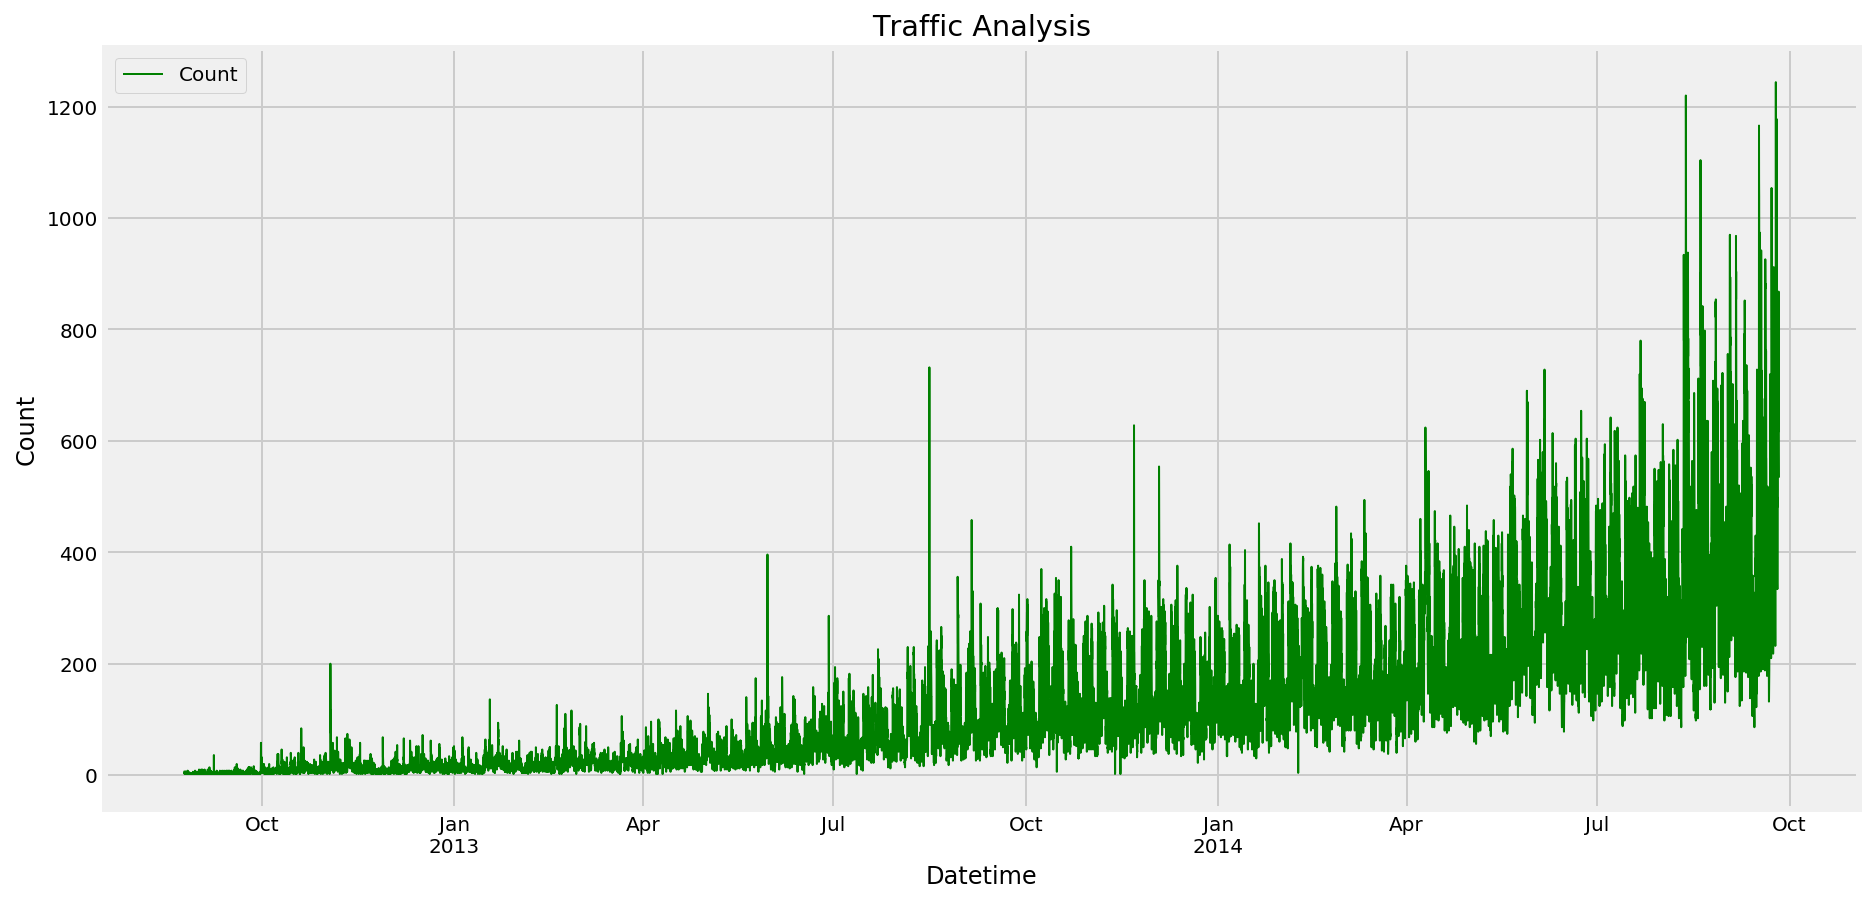

In [5]:
my_train = train_dataframe.copy()
display.display(my_train.head())

my_train = my_train.set_index(
    pd.to_datetime(my_train.Datetime, format='%d-%m-%Y %H:%M'))
display.display(my_train.head())
print("{}".format(my_train.dtypes))

my_train.Datetime = my_train.index
display.display(my_train.head())

my_train.drop('Datetime', axis=1, inplace=True)
display.display(my_train.head())

my_train.drop('ID', axis=1, inplace=True)
display.display(my_train.head())

print("{}".format(type(my_train)))
print("{}".format(my_train.dtypes))

my_train.plot(lw=1, c='g', figsize=(14, 7))
plt.title('Traffic Analysis')
plt.ylabel('Count')
plt.show()

### Feature Extraction

In [6]:
# Just changing the format of already existing Series.
train_dataframe['Datetime'] = pd.to_datetime(
    train_dataframe.Datetime, format='%d-%m-%Y %H:%M')
test_dataframe['Datetime'] = pd.to_datetime(
    test_dataframe.Datetime, format='%d-%m-%Y %H:%M')
test_original_data['Datetime'] = pd.to_datetime(
    test_original_data.Datetime, format='%d-%m-%Y %H:%M')

In [7]:
for dataframe in (train_dataframe, test_dataframe, test_original_data):
    dataframe['year'] = dataframe.Datetime.dt.year
    dataframe['month'] = dataframe.Datetime.dt.month
    dataframe['day'] = dataframe.Datetime.dt.day
    dataframe['Hour'] = dataframe.Datetime.dt.hour

print('Training Data: ')
display.display(train_dataframe.head())
print('Testing Data: ')
display.display(test_dataframe.head())

Training Data: 


ID            Datetime  Count  year  month  day  Hour
0   0 2012-08-25 00:00:00      8  2012      8   25     0
1   1 2012-08-25 01:00:00      2  2012      8   25     1
2   2 2012-08-25 02:00:00      6  2012      8   25     2
3   3 2012-08-25 03:00:00      2  2012      8   25     3
4   4 2012-08-25 04:00:00      2  2012      8   25     4

Testing Data: 


ID            Datetime  year  month  day  Hour
0  18288 2014-09-26 00:00:00  2014      9   26     0
1  18289 2014-09-26 01:00:00  2014      9   26     1
2  18290 2014-09-26 02:00:00  2014      9   26     2
3  18291 2014-09-26 03:00:00  2014      9   26     3
4  18292 2014-09-26 04:00:00  2014      9   26     4

In [8]:
train_dataframe['day_of_week'] = train_dataframe['Datetime'].dt.dayofweek
temp = train_dataframe['Datetime']
display.display(temp.head())
display.display(train_dataframe.head())

0   2012-08-25 00:00:00
1   2012-08-25 01:00:00
2   2012-08-25 02:00:00
3   2012-08-25 03:00:00
4   2012-08-25 04:00:00
Name: Datetime, dtype: datetime64[ns]

ID            Datetime  Count  year  month  day  Hour  day_of_week
0   0 2012-08-25 00:00:00      8  2012      8   25     0            5
1   1 2012-08-25 01:00:00      2  2012      8   25     1            5
2   2 2012-08-25 02:00:00      6  2012      8   25     2            5
3   3 2012-08-25 03:00:00      2  2012      8   25     3            5
4   4 2012-08-25 04:00:00      2  2012      8   25     4            5

In [9]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    return 0


train_dataframe['weekend'] = train_dataframe['Datetime'].apply(applyer)
display.display(train_dataframe.head())

ID            Datetime  Count  year  month  day  Hour  day_of_week  weekend
0   0 2012-08-25 00:00:00      8  2012      8   25     0            5        1
1   1 2012-08-25 01:00:00      2  2012      8   25     1            5        1
2   2 2012-08-25 02:00:00      6  2012      8   25     2            5        1
3   3 2012-08-25 03:00:00      2  2012      8   25     3            5        1
4   4 2012-08-25 04:00:00      2  2012      8   25     4            5        1

### Plot the Visualization

ID            Datetime  Count  year  month  day  Hour  \
Datetime                                                                     
2012-08-25 00:00:00   0 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00   1 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00   2 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00   3 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00   4 2012-08-25 04:00:00      2  2012      8   25     4   

                     day_of_week  weekend  
Datetime                                   
2012-08-25 00:00:00            5        1  
2012-08-25 01:00:00            5        1  
2012-08-25 02:00:00            5        1  
2012-08-25 03:00:00            5        1  
2012-08-25 04:00:00            5        1

Datetime  Count  year  month  day  Hour  \
Datetime                                                                 
2012-08-25 00:00:00 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00 2012-08-25 04:00:00      2  2012      8   25     4   

                     day_of_week  weekend  
Datetime                                   
2012-08-25 00:00:00            5        1  
2012-08-25 01:00:00            5        1  
2012-08-25 02:00:00            5        1  
2012-08-25 03:00:00            5        1  
2012-08-25 04:00:00            5        1

Datetime
2012-08-25 00:00:00    8
2012-08-25 01:00:00    2
2012-08-25 02:00:00    6
2012-08-25 03:00:00    2
2012-08-25 04:00:00    2
Name: Count, dtype: int64

pandas.core.series.Series

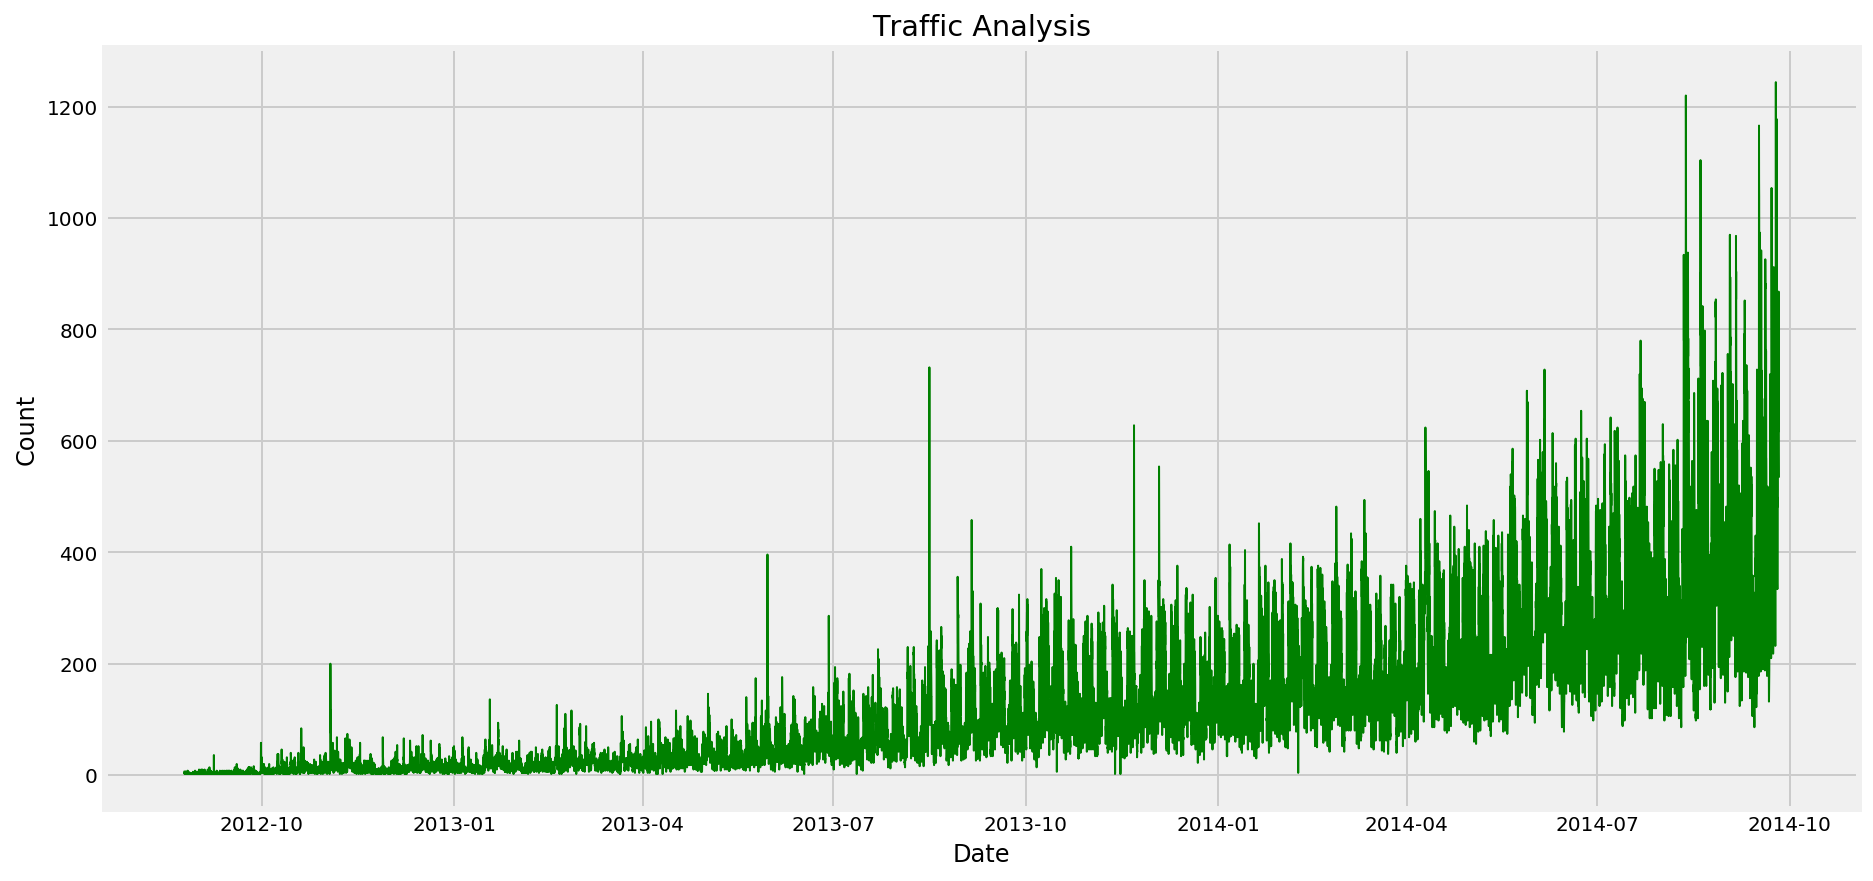

In [10]:
train_dataframe.index = train_dataframe['Datetime']
display.display(train_dataframe.head())

df = train_dataframe.drop('ID', axis=1)
display.display(df.head())

ts = df['Count']
display.display(ts.head())
display.display(type(ts))

plt.figure(figsize=(14, 7))
plt.plot(ts, lw=1, c='g')
plt.title('Traffic Analysis')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

### Exploratory Analysis
#### Hypothesis:
    1. Traffic will be high as the years pass by (increase in the population).
    2. Traffic will be high from May through October (tourism).
    3. Traffic on weekdays will be more (work and office).
    4. Traffic during the peak hours will be high (work and office).

In [11]:
display.display(train_dataframe.head())

ID            Datetime  Count  year  month  day  Hour  \
Datetime                                                                     
2012-08-25 00:00:00   0 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00   1 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00   2 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00   3 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00   4 2012-08-25 04:00:00      2  2012      8   25     4   

                     day_of_week  weekend  
Datetime                                   
2012-08-25 00:00:00            5        1  
2012-08-25 01:00:00            5        1  
2012-08-25 02:00:00            5        1  
2012-08-25 03:00:00            5        1  
2012-08-25 04:00:00            5        1

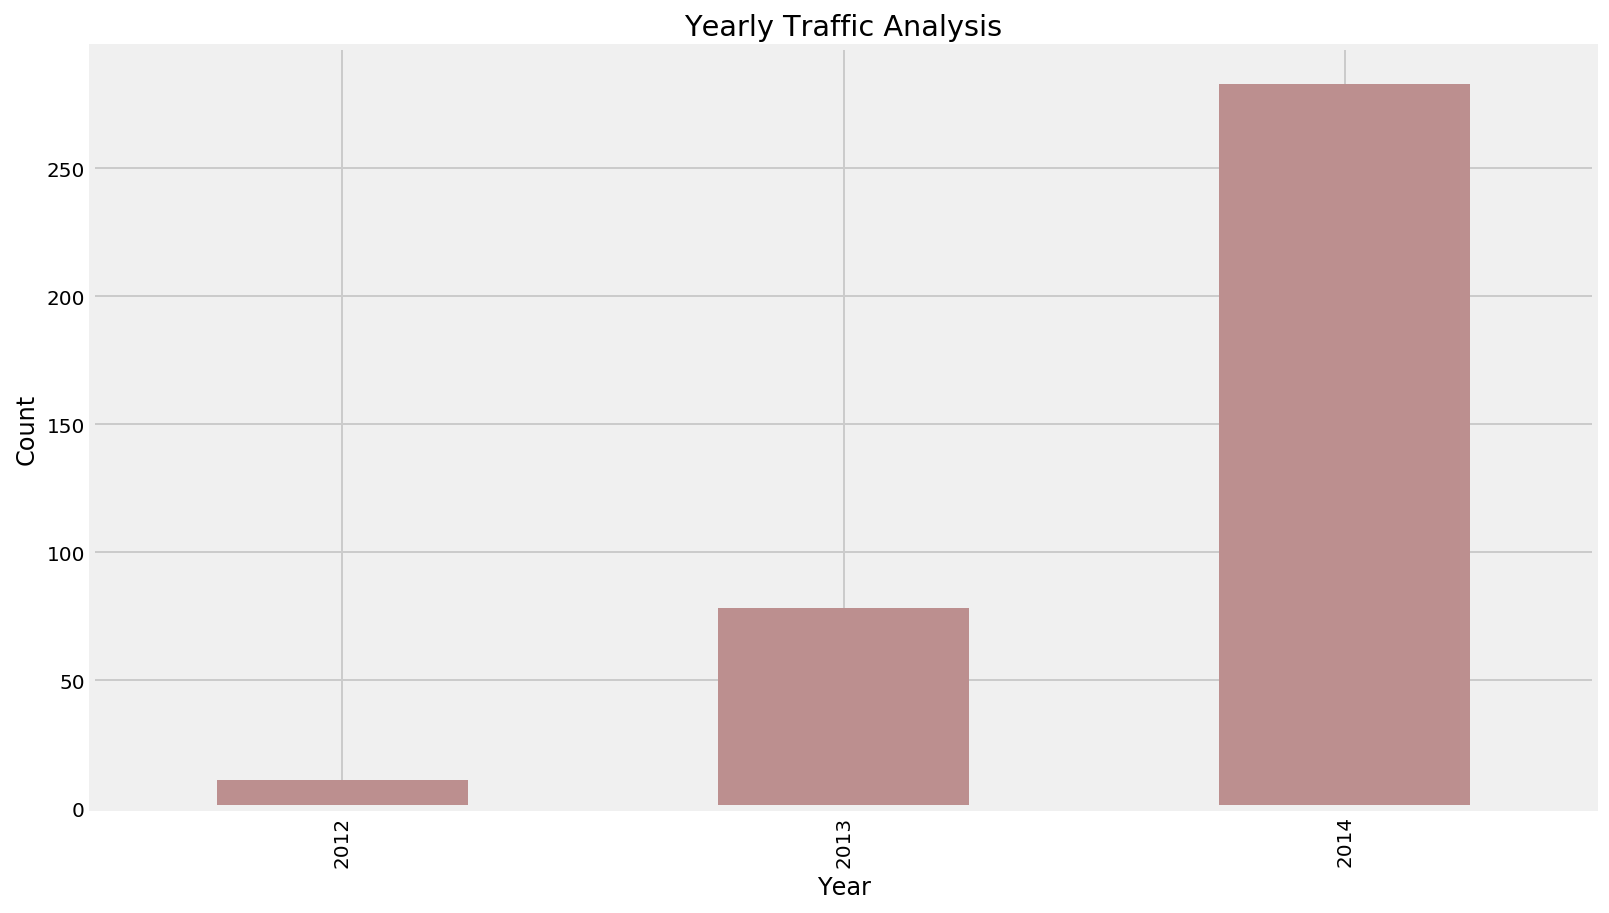

In [12]:
train_dataframe.groupby('year')['Count'].mean().plot.bar(
    figsize=(12, 7), color='rosybrown')
plt.title('Yearly Traffic Analysis')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

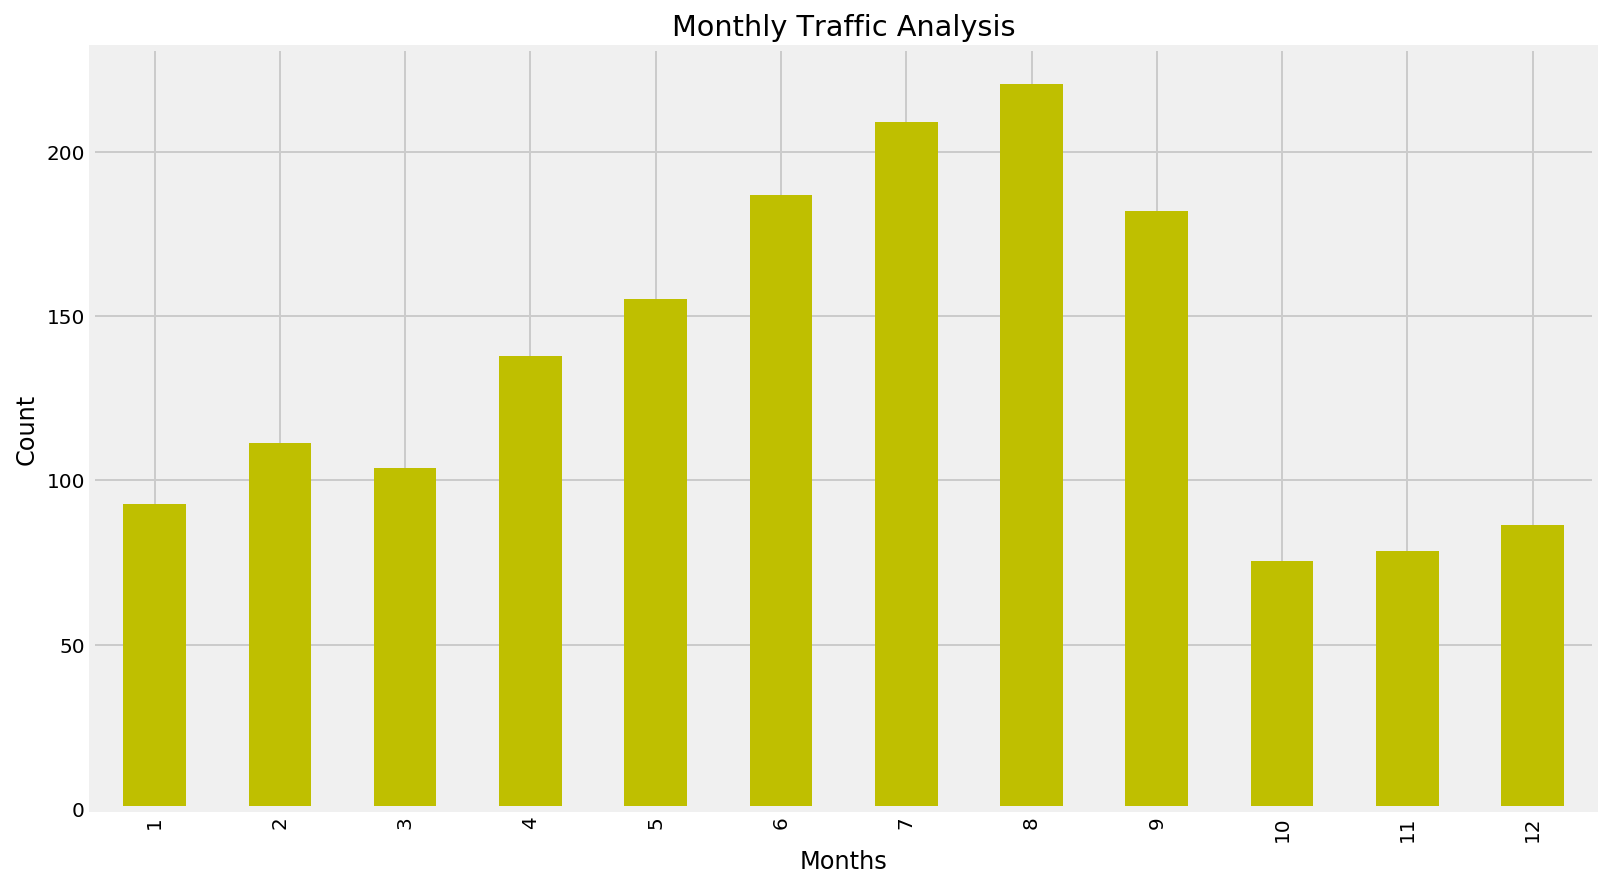

In [13]:
train_dataframe.groupby('month')['Count'].mean().plot.bar(
    figsize=(12, 7), color='y')
plt.title('Monthly Traffic Analysis')
plt.xlabel('Months')
plt.ylabel('Count')
plt.show()

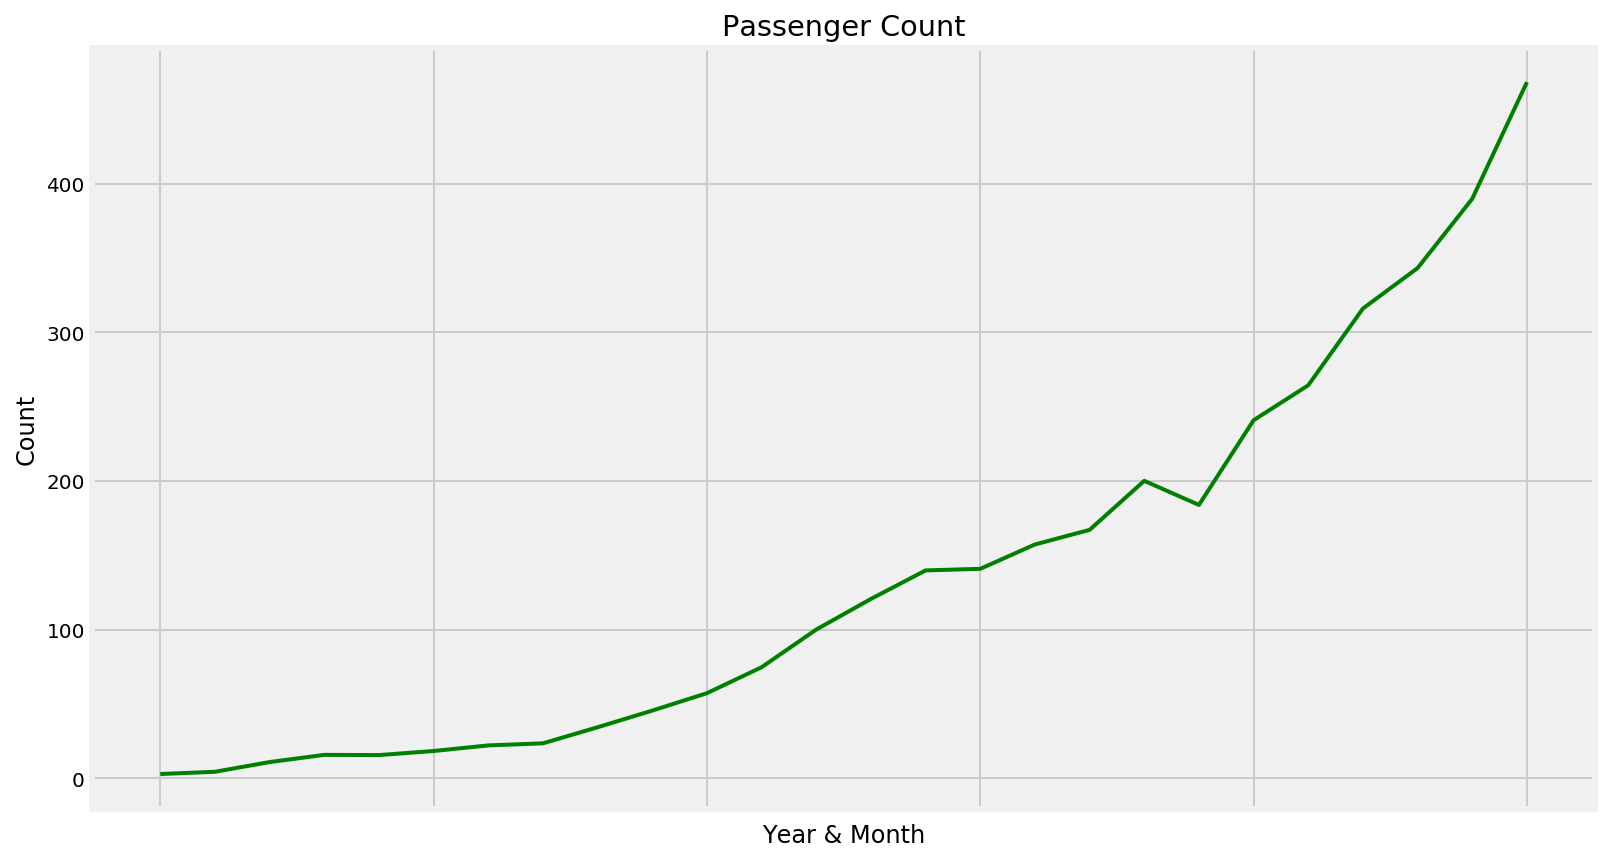

In [14]:
m_y = train_dataframe.groupby(['year', 'month'])['Count'].mean()
m_y.plot(figsize=(12, 7), title='Passenger Count', color='g', lw=2)
plt.ylabel('Count')
plt.xlabel('Year & Month')
plt.show()

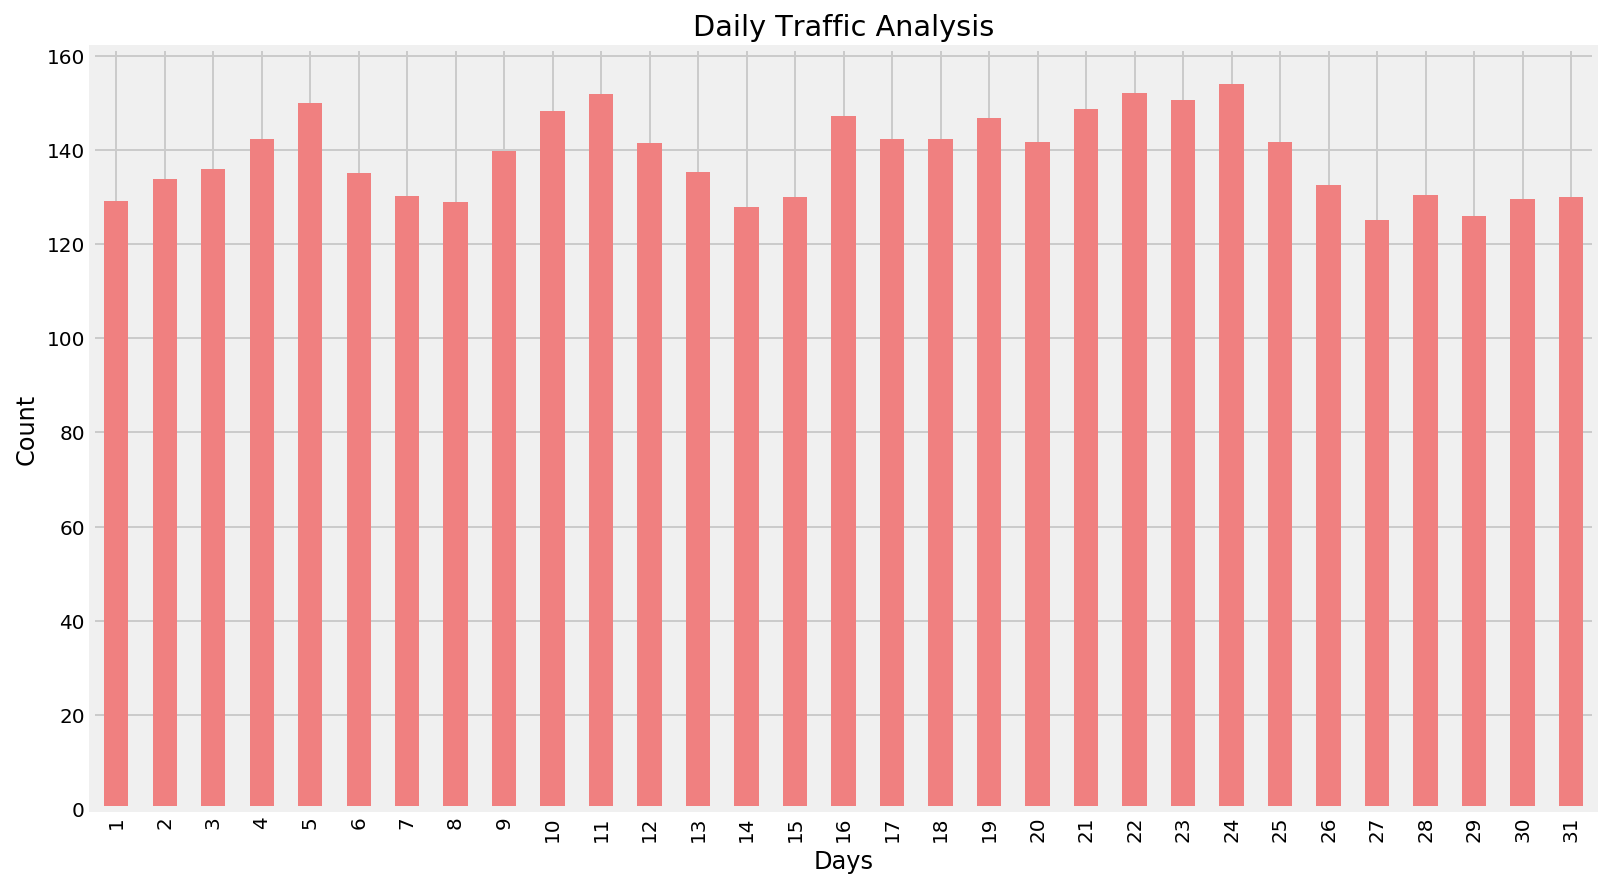

In [15]:
train_dataframe.groupby('day')['Count'].mean().plot.bar(
    figsize=(12, 7), color='lightcoral')
plt.title('Daily Traffic Analysis')
plt.xlabel('Days')
plt.ylabel('Count')
plt.show()

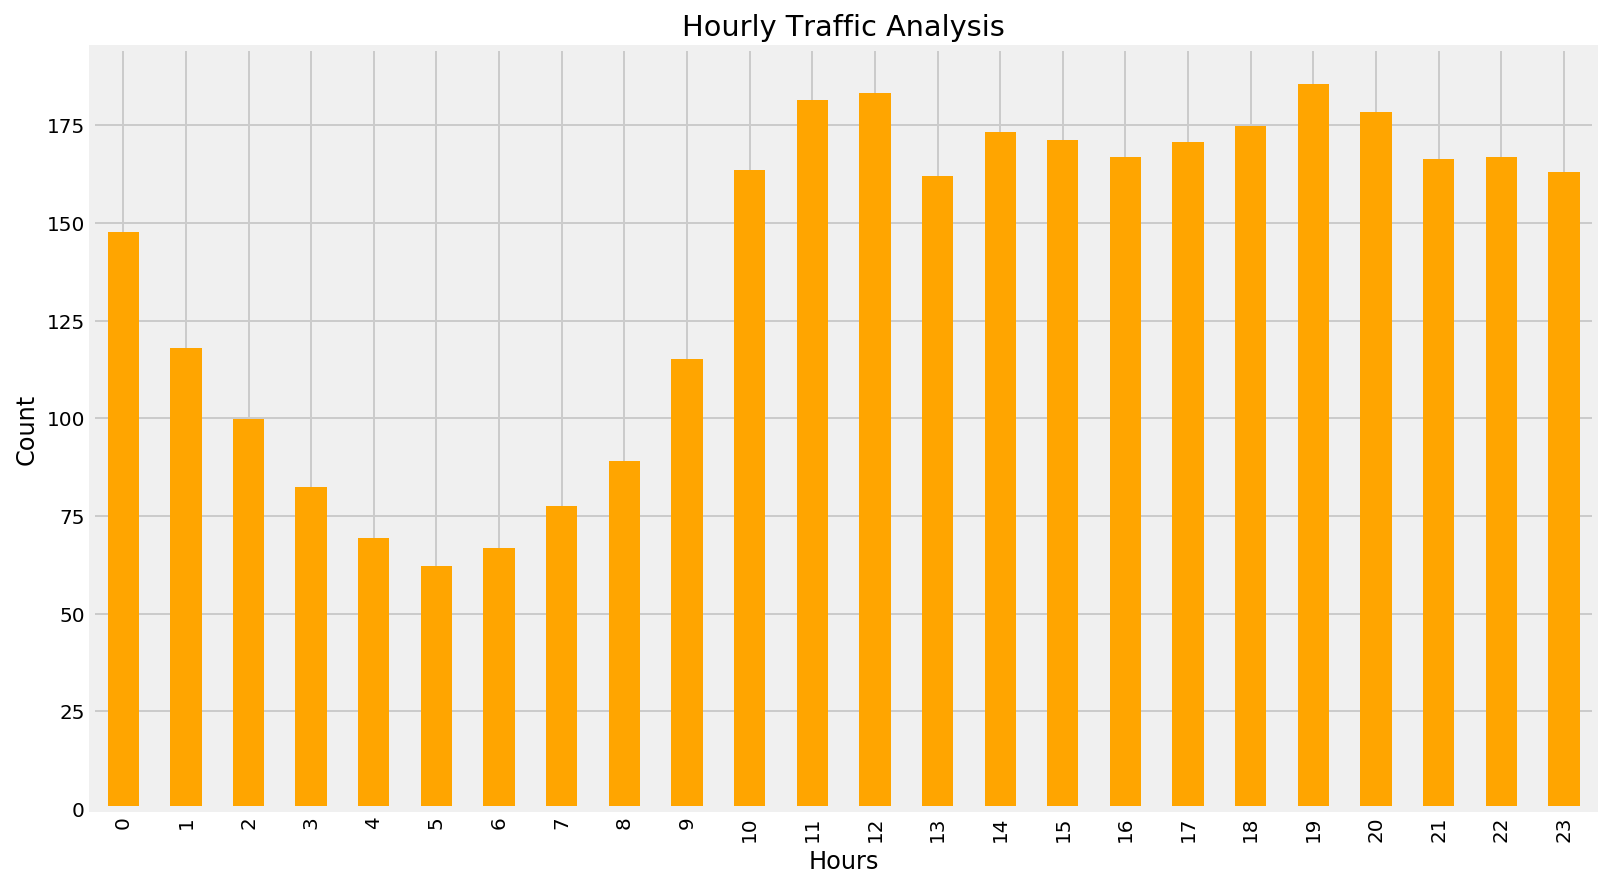

In [16]:
train_dataframe.groupby('Hour')['Count'].mean().plot.bar(
    figsize=(12, 7), color='orange')
plt.title('Hourly Traffic Analysis')
plt.xlabel('Hours')
plt.ylabel('Count')
plt.show()

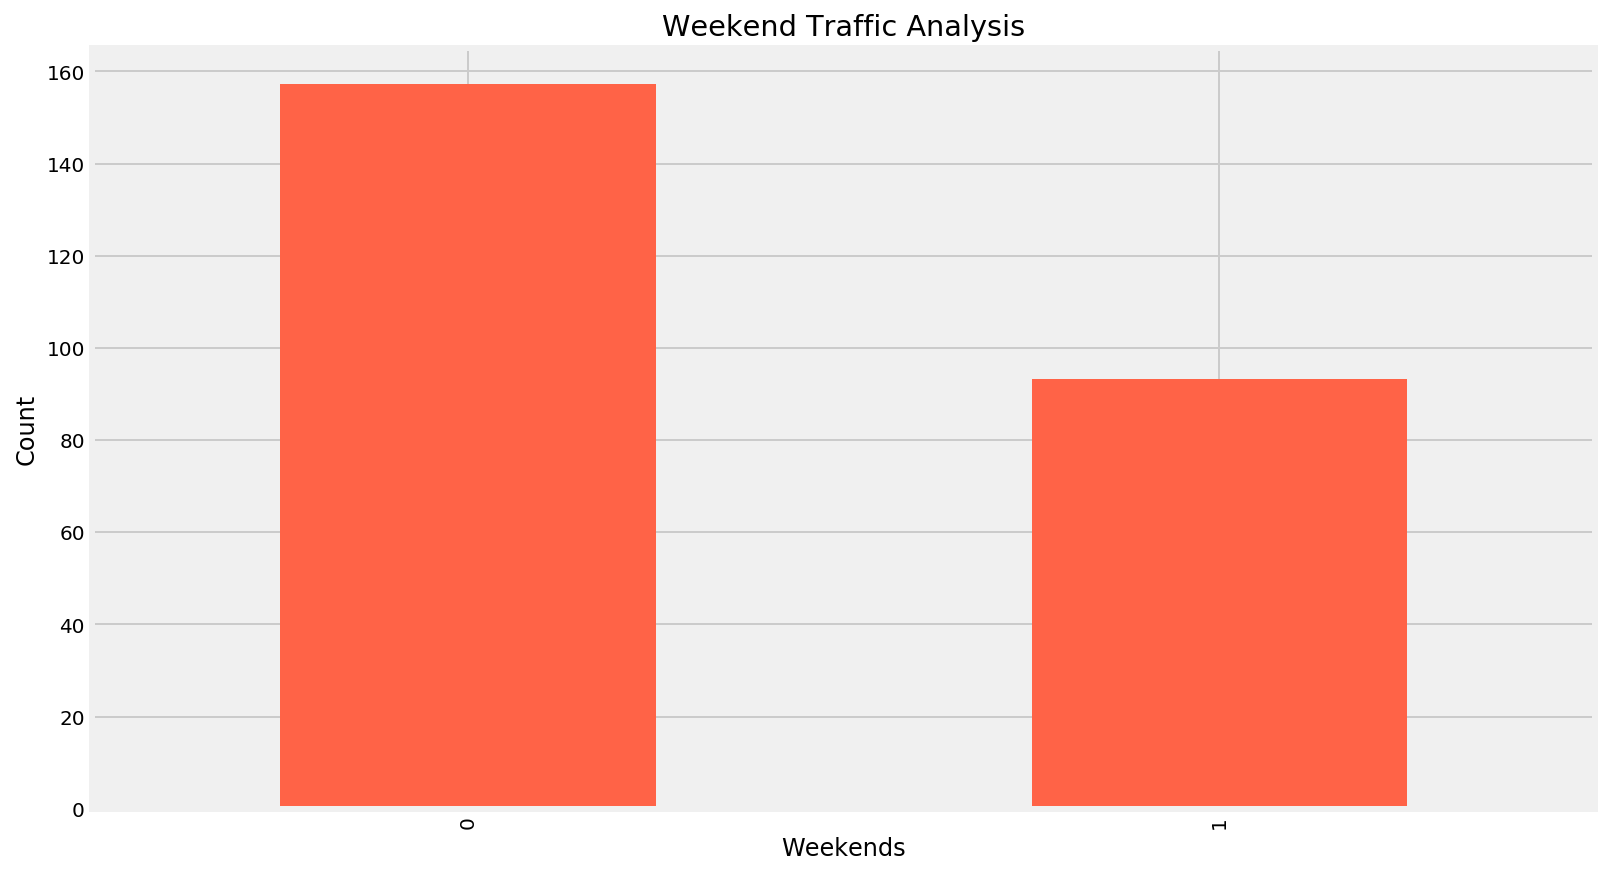

In [17]:
train_dataframe.groupby('weekend')['Count'].mean().plot.bar(
    figsize=(12, 7), color='tomato')
plt.title('Weekend Traffic Analysis')
plt.xlabel('Weekends')
plt.ylabel('Count')
plt.show()

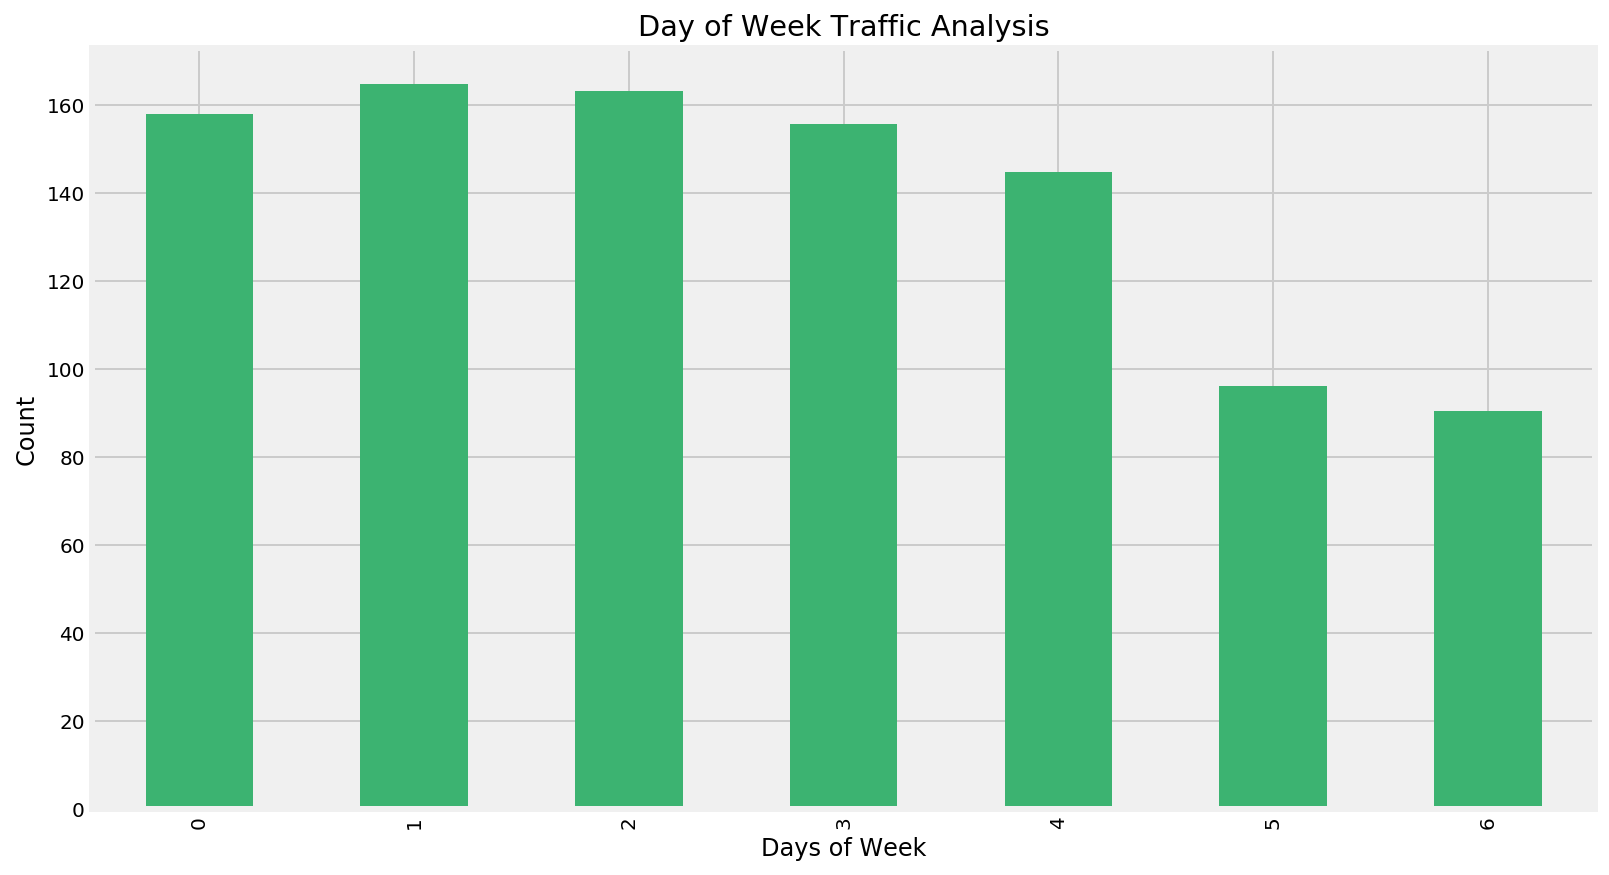

In [18]:
train_dataframe.groupby('day_of_week')['Count'].mean().plot.bar(
    figsize=(12, 7), color='mediumseagreen')
plt.title('Day of Week Traffic Analysis')
plt.xlabel('Days of Week')
plt.ylabel('Count')
plt.show()

In [19]:
train_dataframe = train_dataframe.drop('ID', axis=1)
display.display(train_dataframe.head())

Datetime  Count  year  month  day  Hour  \
Datetime                                                                 
2012-08-25 00:00:00 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00 2012-08-25 04:00:00      2  2012      8   25     4   

                     day_of_week  weekend  
Datetime                                   
2012-08-25 00:00:00            5        1  
2012-08-25 01:00:00            5        1  
2012-08-25 02:00:00            5        1  
2012-08-25 03:00:00            5        1  
2012-08-25 04:00:00            5        1

### Some Digging in Timeseries

In [20]:
display.display(train_dataframe.head())

Datetime  Count  year  month  day  Hour  \
Datetime                                                                 
2012-08-25 00:00:00 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00 2012-08-25 04:00:00      2  2012      8   25     4   

                     day_of_week  weekend  
Datetime                                   
2012-08-25 00:00:00            5        1  
2012-08-25 01:00:00            5        1  
2012-08-25 02:00:00            5        1  
2012-08-25 03:00:00            5        1  
2012-08-25 04:00:00            5        1

In [21]:
train_dataframe['Timestamp'] = pd.to_datetime(
    train_dataframe.Datetime, format='%d-%m-%y %H:%M')
display.display(train_dataframe['Timestamp'].head())

train_dataframe.index = train_dataframe.Timestamp
display.display(train_dataframe.head())

Datetime
2012-08-25 00:00:00   2012-08-25 00:00:00
2012-08-25 01:00:00   2012-08-25 01:00:00
2012-08-25 02:00:00   2012-08-25 02:00:00
2012-08-25 03:00:00   2012-08-25 03:00:00
2012-08-25 04:00:00   2012-08-25 04:00:00
Name: Timestamp, dtype: datetime64[ns]

Datetime  Count  year  month  day  Hour  \
Timestamp                                                                
2012-08-25 00:00:00 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00 2012-08-25 04:00:00      2  2012      8   25     4   

                     day_of_week  weekend           Timestamp  
Timestamp                                                      
2012-08-25 00:00:00            5        1 2012-08-25 00:00:00  
2012-08-25 01:00:00            5        1 2012-08-25 01:00:00  
2012-08-25 02:00:00            5        1 2012-08-25 02:00:00  
2012-08-25 03:00:00            5        1 2012-08-25 03:00:00  
2012-08-25 04:00:00            5        1 2012-08-25 04:00:00

Count  year  month  day  Hour  day_of_week  weekend
Timestamp                                                               
2012-08-25 00:00:00      8  2012      8   25     0            5        1
2012-08-25 01:00:00      2  2012      8   25     1            5        1
2012-08-25 02:00:00      6  2012      8   25     2            5        1
2012-08-25 03:00:00      2  2012      8   25     3            5        1
2012-08-25 04:00:00      2  2012      8   25     4            5        1

18288


Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2012-08-25   3.17 2012.00   8.00 25.00 11.50         5.00     1.00
2012-08-26   3.67 2012.00   8.00 26.00 11.50         6.00     1.00
2012-08-27   2.58 2012.00   8.00 27.00 11.50         0.00     0.00
2012-08-28   2.42 2012.00   8.00 28.00 11.50         1.00     0.00
2012-08-29   2.50 2012.00   8.00 29.00 11.50         2.00     0.00

762


Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2012-08-26   3.42 2012.00   8.00 25.50 11.50         5.50     1.00
2012-09-02   3.35 2012.00   8.29 21.14 11.50         3.00     0.29
2012-09-09   3.65 2012.00   9.00  6.00 11.50         3.00     0.29
2012-09-16   3.12 2012.00   9.00 13.00 11.50         3.00     0.29
2012-09-23   4.71 2012.00   9.00 20.00 11.50         3.00     0.29

110


Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2012-08-31   2.95 2012.00   8.00 28.00 11.50         3.00     0.29
2012-09-30   4.44 2012.00   9.00 15.50 11.50         3.17     0.33
2012-10-31  10.99 2012.00  10.00 16.00 11.50         2.81     0.26
2012-11-30  15.83 2012.00  11.00 15.50 11.50         3.03     0.27
2012-12-31  15.68 2012.00  12.00 16.00 11.50         3.06     0.32

26


Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2012-12-31  11.28 2012.00  10.37 16.42 11.50         3.02     0.29
2013-12-31  78.31 2013.00   6.53 15.72 11.50         2.99     0.28
2014-12-31 283.02 2014.00   4.94 15.45 11.50         3.00     0.28

3


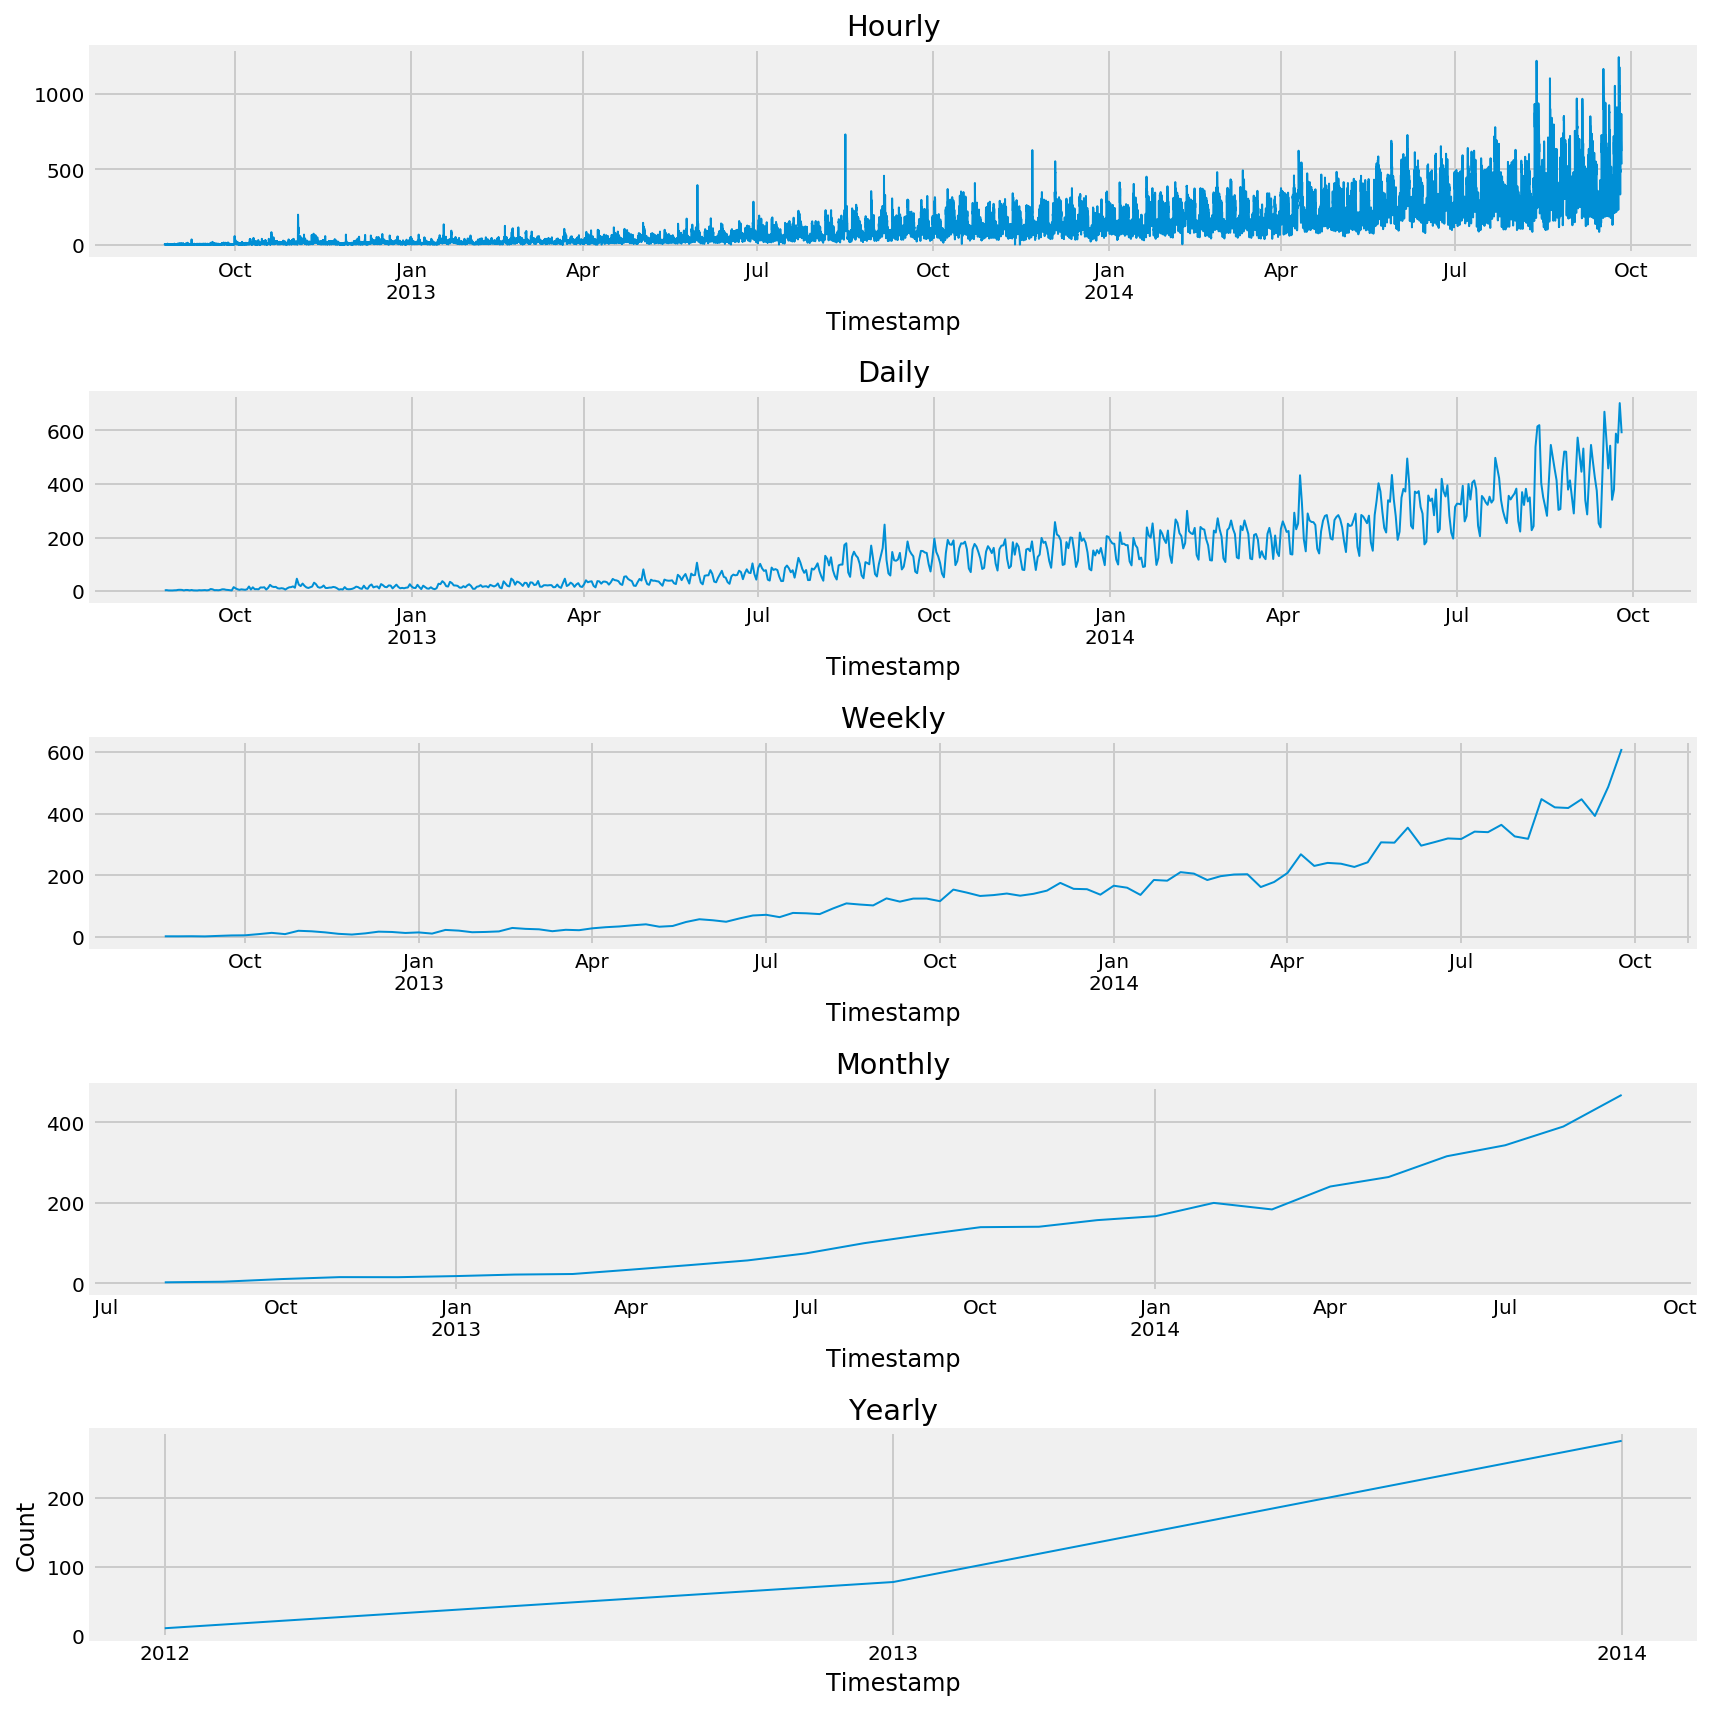

In [22]:
# Hourly Timeseries
hourly = train_dataframe.resample('H').mean()
display.display(hourly.head())
print(len(hourly))

# Daily Timeseries
daily = train_dataframe.resample('D').mean()
display.display(daily.head())
print(len(daily))

# Weekly Timeseries
weekly = train_dataframe.resample('W').mean()
display.display(weekly.head())
print(len(weekly))

# Monthly Timeseries
monthly = train_dataframe.resample('M').mean()
display.display(monthly.head())
print(len(monthly))

# Yearly Timeseries
yearly = train_dataframe.resample('A').mean()
display.display(yearly.head())
print(len(yearly))

fig, axs = plt.subplots(nrows=5, ncols=1)
hourly['Count'].plot(figsize=(12, 12), title='Hourly', lw=1, ax=axs[0])
daily['Count'].plot(figsize=(12, 12), title='Daily', lw=1, ax=axs[1])
weekly['Count'].plot(figsize=(12, 12), title='Weekly', lw=1, ax=axs[2])
monthly['Count'].plot(figsize=(12, 12), title='Monthly', lw=1, ax=axs[3])
yearly['Count'].plot(figsize=(12, 12), title='Yearly', lw=1, ax=axs[4])
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Working on Daily Timeseries

In [23]:
display.display(test_dataframe.head())

test_dataframe['Timestamp'] = pd.to_datetime(
    test_dataframe.Datetime, format='%d-%m-%y %H:%M')
display.display(test_dataframe.head())

test_dataframe.index = test_dataframe.Timestamp
display.display(test_dataframe.head())

test_dataframe = test_dataframe.resample('D').mean()  # **important
display.display(test_dataframe.head())

display.display(train_dataframe.head())

train_dataframe['Timestamp'] = pd.to_datetime(
    train_dataframe.Datetime, format='%d-%m-%y %H:%M')
display.display(train_dataframe.head())

train_dataframe.index = train_dataframe.Timestamp
display.display(train_dataframe.head())

train_dataframe = train_dataframe.resample('D').mean()  # **important
display.display(train_dataframe.head())

ID            Datetime  year  month  day  Hour
0  18288 2014-09-26 00:00:00  2014      9   26     0
1  18289 2014-09-26 01:00:00  2014      9   26     1
2  18290 2014-09-26 02:00:00  2014      9   26     2
3  18291 2014-09-26 03:00:00  2014      9   26     3
4  18292 2014-09-26 04:00:00  2014      9   26     4

ID            Datetime  year  month  day  Hour           Timestamp
0  18288 2014-09-26 00:00:00  2014      9   26     0 2014-09-26 00:00:00
1  18289 2014-09-26 01:00:00  2014      9   26     1 2014-09-26 01:00:00
2  18290 2014-09-26 02:00:00  2014      9   26     2 2014-09-26 02:00:00
3  18291 2014-09-26 03:00:00  2014      9   26     3 2014-09-26 03:00:00
4  18292 2014-09-26 04:00:00  2014      9   26     4 2014-09-26 04:00:00

ID            Datetime  year  month  day  Hour  \
Timestamp                                                                
2014-09-26 00:00:00  18288 2014-09-26 00:00:00  2014      9   26     0   
2014-09-26 01:00:00  18289 2014-09-26 01:00:00  2014      9   26     1   
2014-09-26 02:00:00  18290 2014-09-26 02:00:00  2014      9   26     2   
2014-09-26 03:00:00  18291 2014-09-26 03:00:00  2014      9   26     3   
2014-09-26 04:00:00  18292 2014-09-26 04:00:00  2014      9   26     4   

                              Timestamp  
Timestamp                                
2014-09-26 00:00:00 2014-09-26 00:00:00  
2014-09-26 01:00:00 2014-09-26 01:00:00  
2014-09-26 02:00:00 2014-09-26 02:00:00  
2014-09-26 03:00:00 2014-09-26 03:00:00  
2014-09-26 04:00:00 2014-09-26 04:00:00

ID    year  month   day  Hour
Timestamp                                     
2014-09-26 18299.50 2014.00   9.00 26.00 11.50
2014-09-27 18323.50 2014.00   9.00 27.00 11.50
2014-09-28 18347.50 2014.00   9.00 28.00 11.50
2014-09-29 18371.50 2014.00   9.00 29.00 11.50
2014-09-30 18395.50 2014.00   9.00 30.00 11.50

Datetime  Count  year  month  day  Hour  \
Timestamp                                                                
2012-08-25 00:00:00 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00 2012-08-25 04:00:00      2  2012      8   25     4   

                     day_of_week  weekend           Timestamp  
Timestamp                                                      
2012-08-25 00:00:00            5        1 2012-08-25 00:00:00  
2012-08-25 01:00:00            5        1 2012-08-25 01:00:00  
2012-08-25 02:00:00            5        1 2012-08-25 02:00:00  
2012-08-25 03:00:00            5        1 2012-08-25 03:00:00  
2012-08-25 04:00:00            5        1 2012-08-25 04:00:00

Datetime  Count  year  month  day  Hour  \
Timestamp                                                                
2012-08-25 00:00:00 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00 2012-08-25 04:00:00      2  2012      8   25     4   

                     day_of_week  weekend           Timestamp  
Timestamp                                                      
2012-08-25 00:00:00            5        1 2012-08-25 00:00:00  
2012-08-25 01:00:00            5        1 2012-08-25 01:00:00  
2012-08-25 02:00:00            5        1 2012-08-25 02:00:00  
2012-08-25 03:00:00            5        1 2012-08-25 03:00:00  
2012-08-25 04:00:00            5        1 2012-08-25 04:00:00

Datetime  Count  year  month  day  Hour  \
Timestamp                                                                
2012-08-25 00:00:00 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00 2012-08-25 04:00:00      2  2012      8   25     4   

                     day_of_week  weekend           Timestamp  
Timestamp                                                      
2012-08-25 00:00:00            5        1 2012-08-25 00:00:00  
2012-08-25 01:00:00            5        1 2012-08-25 01:00:00  
2012-08-25 02:00:00            5        1 2012-08-25 02:00:00  
2012-08-25 03:00:00            5        1 2012-08-25 03:00:00  
2012-08-25 04:00:00            5        1 2012-08-25 04:00:00

Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2012-08-25   3.17 2012.00   8.00 25.00 11.50         5.00     1.00
2012-08-26   3.67 2012.00   8.00 26.00 11.50         6.00     1.00
2012-08-27   2.58 2012.00   8.00 27.00 11.50         0.00     0.00
2012-08-28   2.42 2012.00   8.00 28.00 11.50         1.00     0.00
2012-08-29   2.50 2012.00   8.00 29.00 11.50         2.00     0.00

### Training and Validation sets

Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2012-08-25   3.17 2012.00   8.00 25.00 11.50         5.00     1.00
2012-08-26   3.67 2012.00   8.00 26.00 11.50         6.00     1.00
2012-08-27   2.58 2012.00   8.00 27.00 11.50         0.00     0.00
2012-08-28   2.42 2012.00   8.00 28.00 11.50         1.00     0.00
2012-08-29   2.50 2012.00   8.00 29.00 11.50         2.00     0.00

Count    year  month    day   Hour  day_of_week  weekend
count 669.00  669.00 669.00 669.00 669.00       669.00   669.00
mean  104.16 2013.07   6.46  15.72  11.50         3.00     0.29
std    96.99    0.67   3.59   8.80   0.00         2.01     0.45
min     2.42 2012.00   1.00   1.00  11.50         0.00     0.00
25%    20.58 2013.00   3.00   8.00  11.50         1.00     0.00
50%    76.25 2013.00   6.00  16.00  11.50         3.00     0.00
75%   171.17 2014.00  10.00  23.00  11.50         5.00     1.00
max   495.25 2014.00  12.00  31.00  11.50         6.00     1.00

Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00

Count    year  month   day  Hour  day_of_week  weekend
count  93.00   93.00  93.00 93.00 93.00        93.00    93.00
mean  389.30 2014.00   7.81 15.94 11.50         2.99     0.28
std   111.07    0.00   0.91  8.91  0.00         1.99     0.45
min   196.25 2014.00   6.00  1.00 11.50         0.00     0.00
25%   321.83 2014.00   7.00  8.00 11.50         1.00     0.00
50%   364.17 2014.00   8.00 16.00 11.50         3.00     0.00
75%   448.50 2014.00   9.00 24.00 11.50         5.00     1.00
max   702.33 2014.00   9.00 31.00 11.50         6.00     1.00

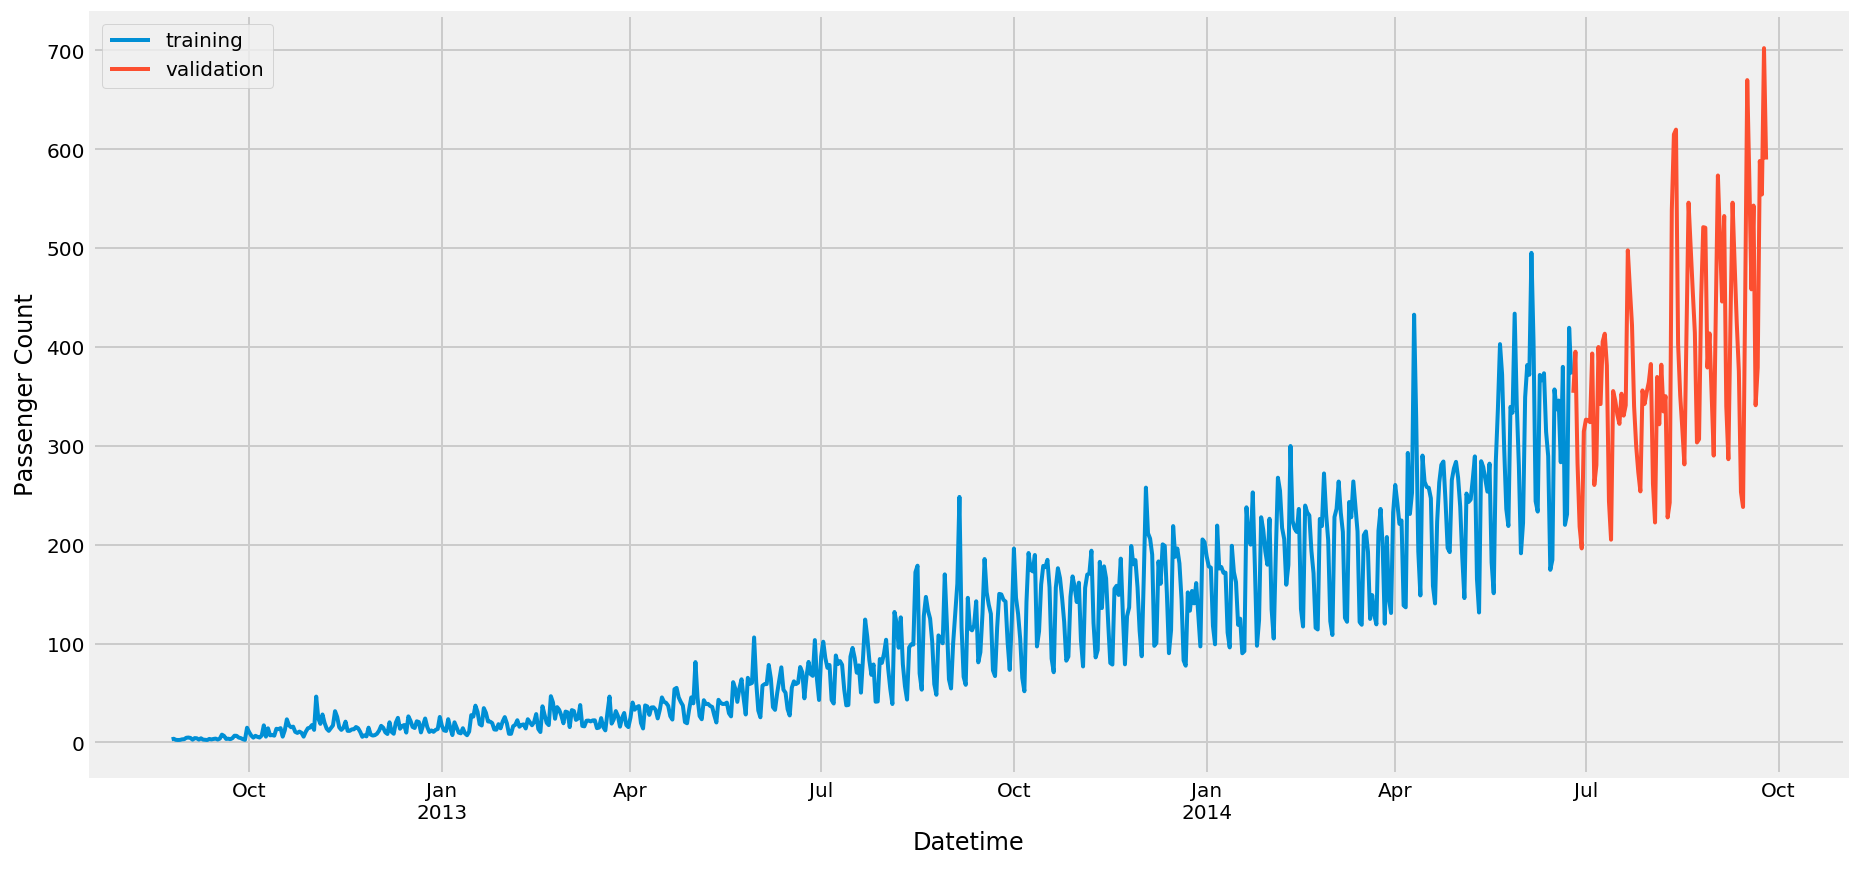

In [24]:
train_set_dataframe = train_dataframe.loc['2012-08-25':'2014-06-24']
validation_Set_dataframe = train_dataframe.loc['2014-06-25':'2014-09-25']

display.display(train_set_dataframe.head())
display.display(train_set_dataframe.describe())
display.display(validation_Set_dataframe.head())
display.display(validation_Set_dataframe.describe())

train_set_dataframe.Count.plot(figsize=(14, 7), lw=2, label='training')
validation_Set_dataframe.Count.plot(figsize=(14, 7), lw=2, label='validation')
plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.legend()
plt.show()

### Modelling Techniques
#### Average Approach
In this approach, the `predictions` of all future values are equal to the __`mean` of the past data__. This approach can be used with any sort of data where past data are available.

$$\hat{Y}_{T + h|T} = \bar{Y} = \frac{(Y_1+\dots+Y_T)}{T}$$
$Y_1, \dots, Y_T $ are past data.
#### Naiive Approach
Naiive forcasts are the most cost-effective forcasting model, and provide a benchmark against which are more sophisticated models can be compared. Suitable for time-series data. __Using this approach forcasts are produced that are equal to the last observed value.__ If `seasonality` is found, then we practice __Seasonality Approach__.

$$\hat{Y}_{T + h|T} = Y_{T}$$
$\hat{Y}_{T + h|T} = $ Forcast value<br />
$Y_{T} = $ Previous value
#### Seasonality Naiive Approach
The seasonal naiive method accounts for seasonality by setting each __`prediction` to be equal to the last observed value of the same season__.

$$\hat{Y}_{T+h|T} = Y_{T+h-km}$$
$m = $ seasonal period<br />
$k = $ smallest integer greater than $\frac{(h-1)}{m}$<br /><br />
Suitable for data that has high-level of seasonality.
#### Drift Method
A variation on the naiive method is to allow the __forecasts to increase or decrease overtime, where the amount of change overtime (called `drift`) is set to be average change__ seen in the historical data. So, the forcast for time $T + h$ is given by

$$\hat{Y}_{T + h|T} = Y_T + \frac{h}{T-1}\sum^{T}_{t=2}(Y_t - Y_{t-1}) = Y_T + h\Big(\frac{Y_T - Y_1}{T-1}\Big)$$ <br />
This method will take __`last observation` $+$ `average change` from the first observation to last observation__.

### Naiive Forecasts of Traffic

Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2014-06-20 379.92 2014.00   6.00 20.00 11.50         4.00     0.00
2014-06-21 220.08 2014.00   6.00 21.00 11.50         5.00     1.00
2014-06-22 230.83 2014.00   6.00 22.00 11.50         6.00     1.00
2014-06-23 419.42 2014.00   6.00 23.00 11.50         0.00     0.00
2014-06-24 372.17 2014.00   6.00 24.00 11.50         1.00     0.00

Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00

Count    year  month   day  Hour  day_of_week  weekend  naive
Timestamp                                                                
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00 372.17
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00 372.17
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00 372.17
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00 372.17
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00 372.17

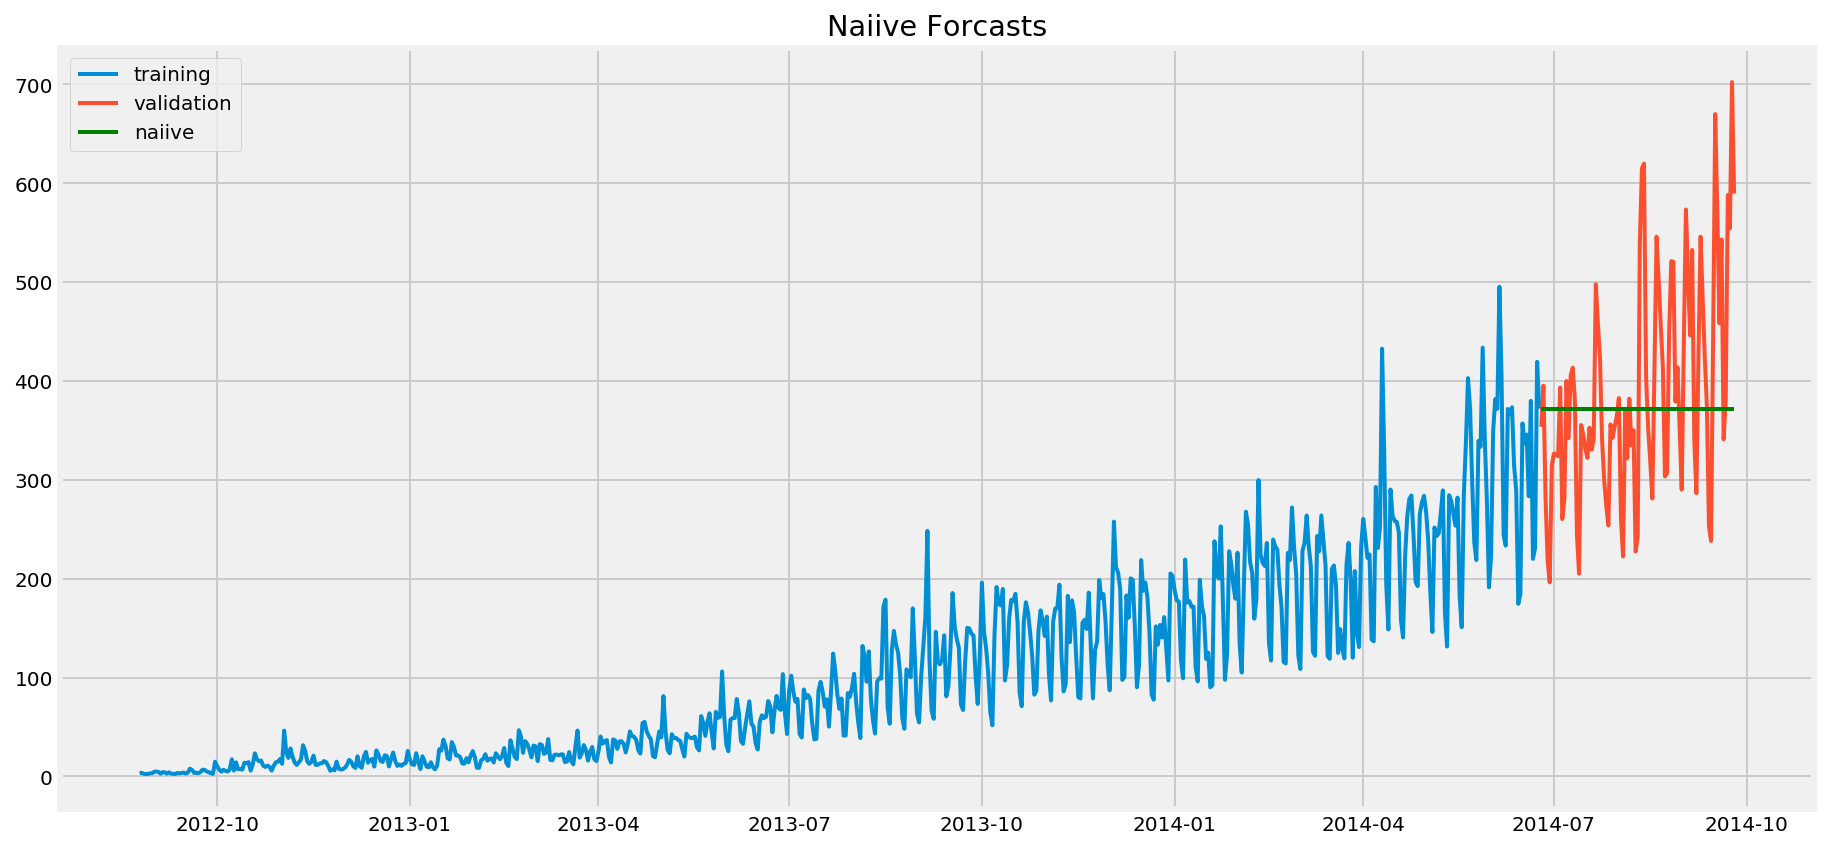

Root Mean Squared Error : 111.79050


In [25]:
display.display(train_set_dataframe.tail())
dd = np.asarray(train_set_dataframe.Count)
y_hat = validation_Set_dataframe.copy()
display.display(y_hat.head())

y_hat['naive'] = dd[len(dd) - 1]
display.display(y_hat.head())

plt.figure(figsize=(14, 7))
plt.plot(
    train_set_dataframe.index,
    train_set_dataframe.Count,
    lw=2,
    label='training')
plt.plot(
    validation_Set_dataframe.index,
    validation_Set_dataframe.Count,
    lw=2,
    label='validation')
plt.plot(y_hat.index, y_hat.naive, c='g', lw=2, label='naiive')
plt.title('Naiive Forcasts')
plt.legend()
plt.show()

# Root Mean Squared Error
rmse_naive = math.sqrt(
    metrics.mean_squared_error(y_hat.naive, validation_Set_dataframe.Count))
print('Root Mean Squared Error : {:.5f}'.format(rmse_naive))

### Moving Averages or Rolling Means Forecasts of Traffic

313.0333333333333

319.91666666666663

296.62666666666655

Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00

Count    year  month   day  Hour  day_of_week  weekend  \
Timestamp                                                            
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00   
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00   
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00   
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00   
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00   

            moving_avg_10  
Timestamp                  
2014-06-25         313.03  
2014-06-26         313.03  
2014-06-27         313.03  
2014-06-28         313.03  
2014-06-29         313.03

Count    year  month   day  Hour  day_of_week  weekend  \
Timestamp                                                            
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00   
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00   
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00   
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00   
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00   

            moving_avg_10  moving_avg_20  
Timestamp                                 
2014-06-25         313.03         319.92  
2014-06-26         313.03         319.92  
2014-06-27         313.03         319.92  
2014-06-28         313.03         319.92  
2014-06-29         313.03         319.92

Count    year  month   day  Hour  day_of_week  weekend  \
Timestamp                                                            
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00   
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00   
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00   
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00   
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00   

            moving_avg_10  moving_avg_20  moving_avg_50  
Timestamp                                                
2014-06-25         313.03         319.92         296.63  
2014-06-26         313.03         319.92         296.63  
2014-06-27         313.03         319.92         296.63  
2014-06-28         313.03         319.92         296.63  
2014-06-29         313.03         319.92         296.63

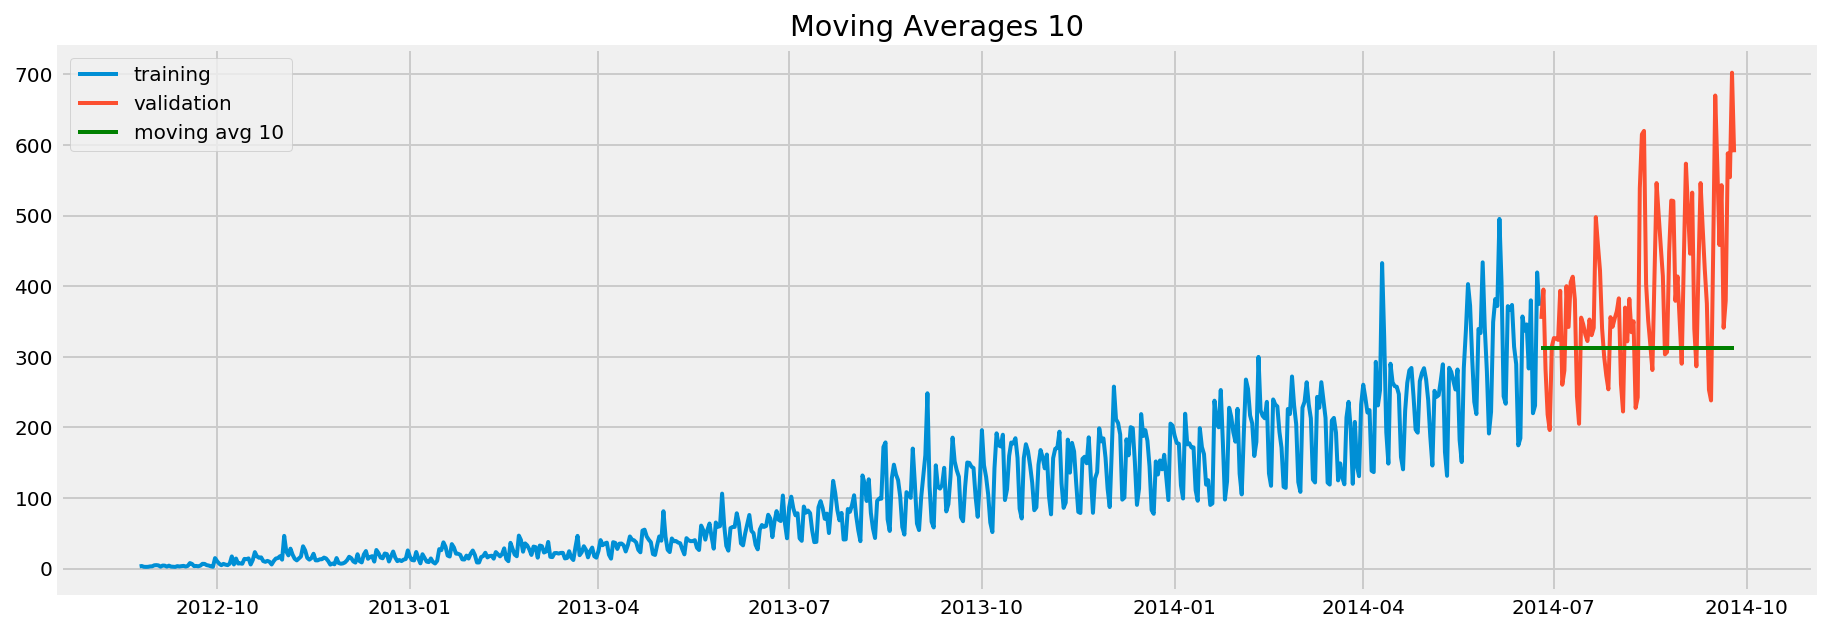

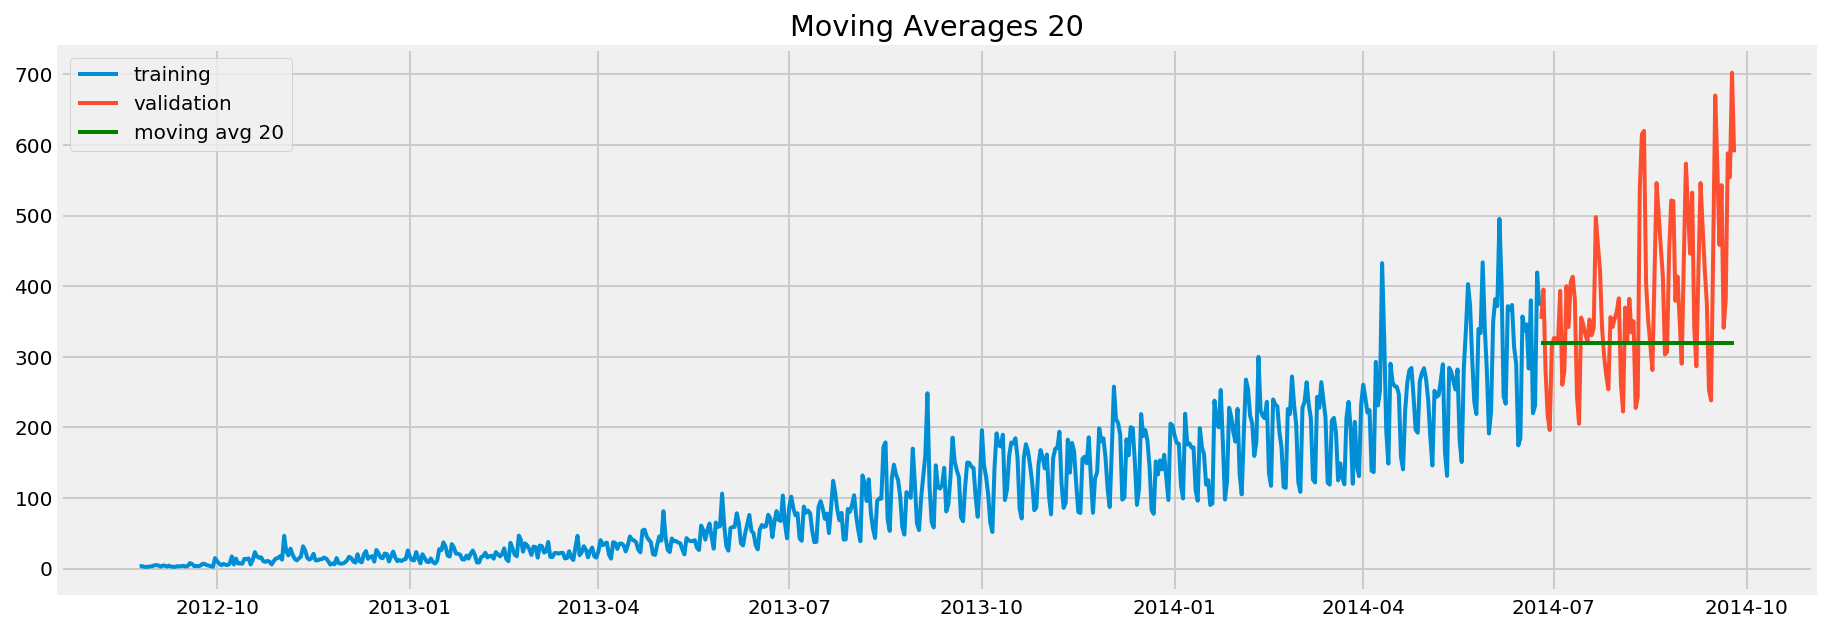

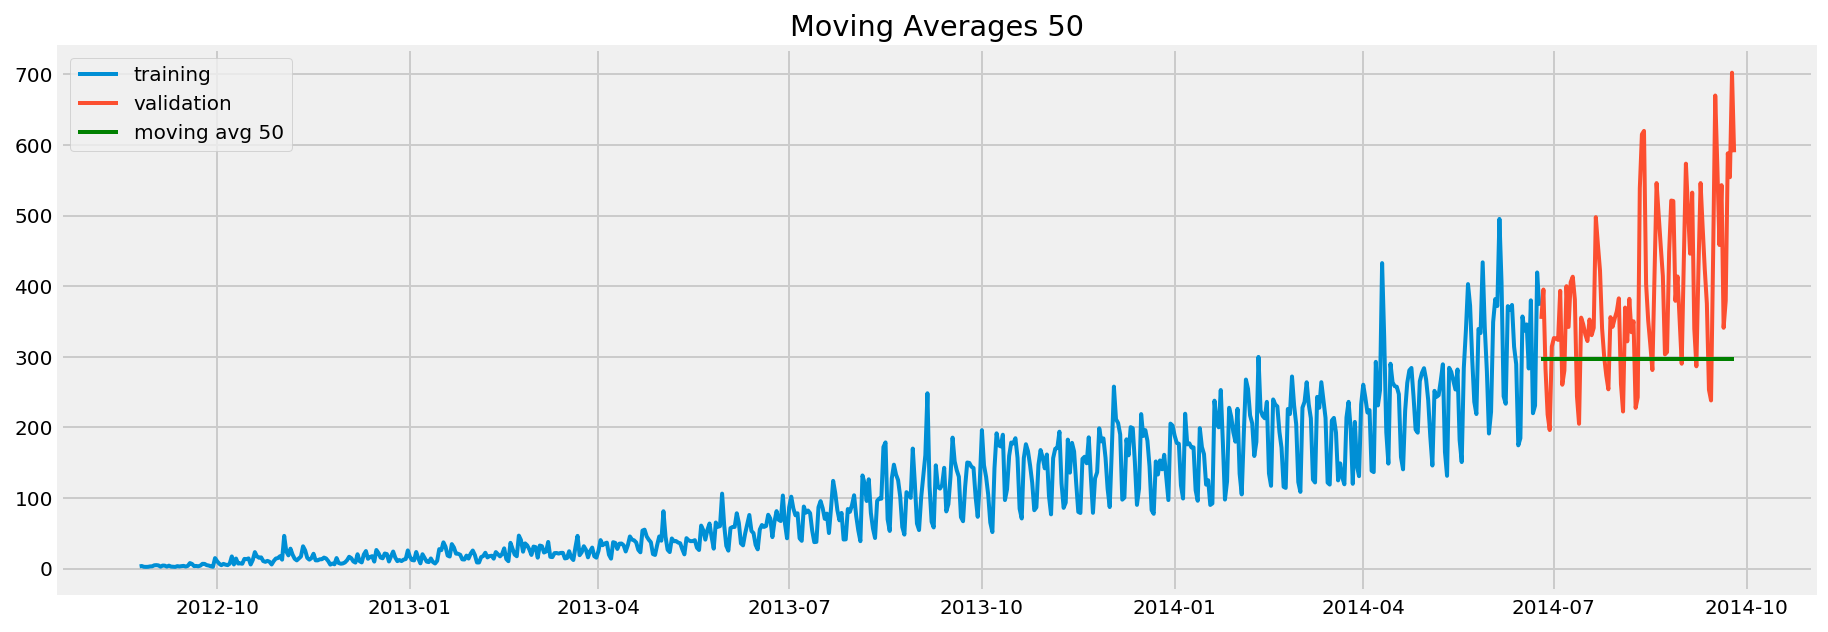

Root Mean Squared Error : 144.19176


In [26]:
# Rolling mean for last 10, 20, 50 days
display.display(
    train_set_dataframe['Count'].rolling(window=10).mean().iloc[-1])
display.display(
    train_set_dataframe['Count'].rolling(window=20).mean().iloc[-1])
display.display(
    train_set_dataframe['Count'].rolling(window=50).mean().iloc[-1])

y_hat_avg = validation_Set_dataframe.copy()
display.display(y_hat_avg.head())

y_hat_avg['moving_avg_10'] = train_set_dataframe['Count'].rolling(
    window=10).mean().iloc[-1]  # last of 10 days
display.display(y_hat_avg.head())

y_hat_avg['moving_avg_20'] = train_set_dataframe['Count'].rolling(
    window=20).mean().iloc[-1]  # last of 20 days
display.display(y_hat_avg.head())

y_hat_avg['moving_avg_50'] = train_set_dataframe['Count'].rolling(
    window=50).mean().iloc[-1]  # last of 50 days
display.display(y_hat_avg.head())

plt.figure(figsize=(14, 5))
plt.plot(
    train_set_dataframe.index,
    train_set_dataframe.Count,
    lw=2,
    label='training')
plt.plot(
    validation_Set_dataframe.index,
    validation_Set_dataframe.Count,
    lw=2,
    label='validation')
plt.plot(
    y_hat_avg.index,
    y_hat_avg.moving_avg_10,
    lw=2,
    c='g',
    label='moving avg 10')
plt.title('Moving Averages 10')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(
    train_set_dataframe.index,
    train_set_dataframe.Count,
    lw=2,
    label='training')
plt.plot(
    validation_Set_dataframe.index,
    validation_Set_dataframe.Count,
    lw=2,
    label='validation')
plt.plot(
    y_hat_avg.index,
    y_hat_avg.moving_avg_20,
    lw=2,
    c='g',
    label='moving avg 20')
plt.title('Moving Averages 20')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(
    train_set_dataframe.index,
    train_set_dataframe.Count,
    lw=2,
    label='training')
plt.plot(
    validation_Set_dataframe.index,
    validation_Set_dataframe.Count,
    lw=2,
    label='validation')
plt.plot(
    y_hat_avg.index,
    y_hat_avg.moving_avg_50,
    lw=2,
    c='g',
    label='moving avg 50')
plt.title('Moving Averages 50')
plt.legend()
plt.show()

rmse_avg = math.sqrt(
    metrics.mean_squared_error(y_hat_avg.moving_avg_50,
                               validation_Set_dataframe.Count))
print('Root Mean Squared Error : {:.5f}'.format(rmse_avg))

### Simple Exponential Smoothing Approach
Rule of thumb technique for smoothing time-series data using exponential `window functions`. Whereas in the `simple moving average` the past observations are weighted equally,. `Exponential` functions are used to assign `exponentially decreasing weights over time`.<br />
* In this technique, we assign larger weights to more recent observations than to observations from the distant past.
* The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

__NOTE__ - If we give the entire weight to the last observed value only, this method will be similar to the naive approach. So, we can say that naive approach is also a simple exponential smoothing technique where the entire weight is given to the last observed value.
#### Window Functions
Window functions (`apodization` or `tapering` functions) is a mathematical function that is `zero-valued` outside of some chosen `interval`. For instance, a function that is `constant` inside the interval and zero elsewhere is called `rectangular window`, which describes the shape of its graphical representation when another function or waveform or data-sequence is multiplied by a window function the product is also zero-valued outside the interval: all that is left in the part where `overlap` is `view through the window`.
#### Fourier Transform
Fourier Transform decomposes a function of `time (signal)` into `frequencies` that make it up.

Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00

Count    year  month   day  Hour  day_of_week  weekend    SES
Timestamp                                                                
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00 363.52
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00 363.52
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00 363.52
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00 363.52
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00 363.52

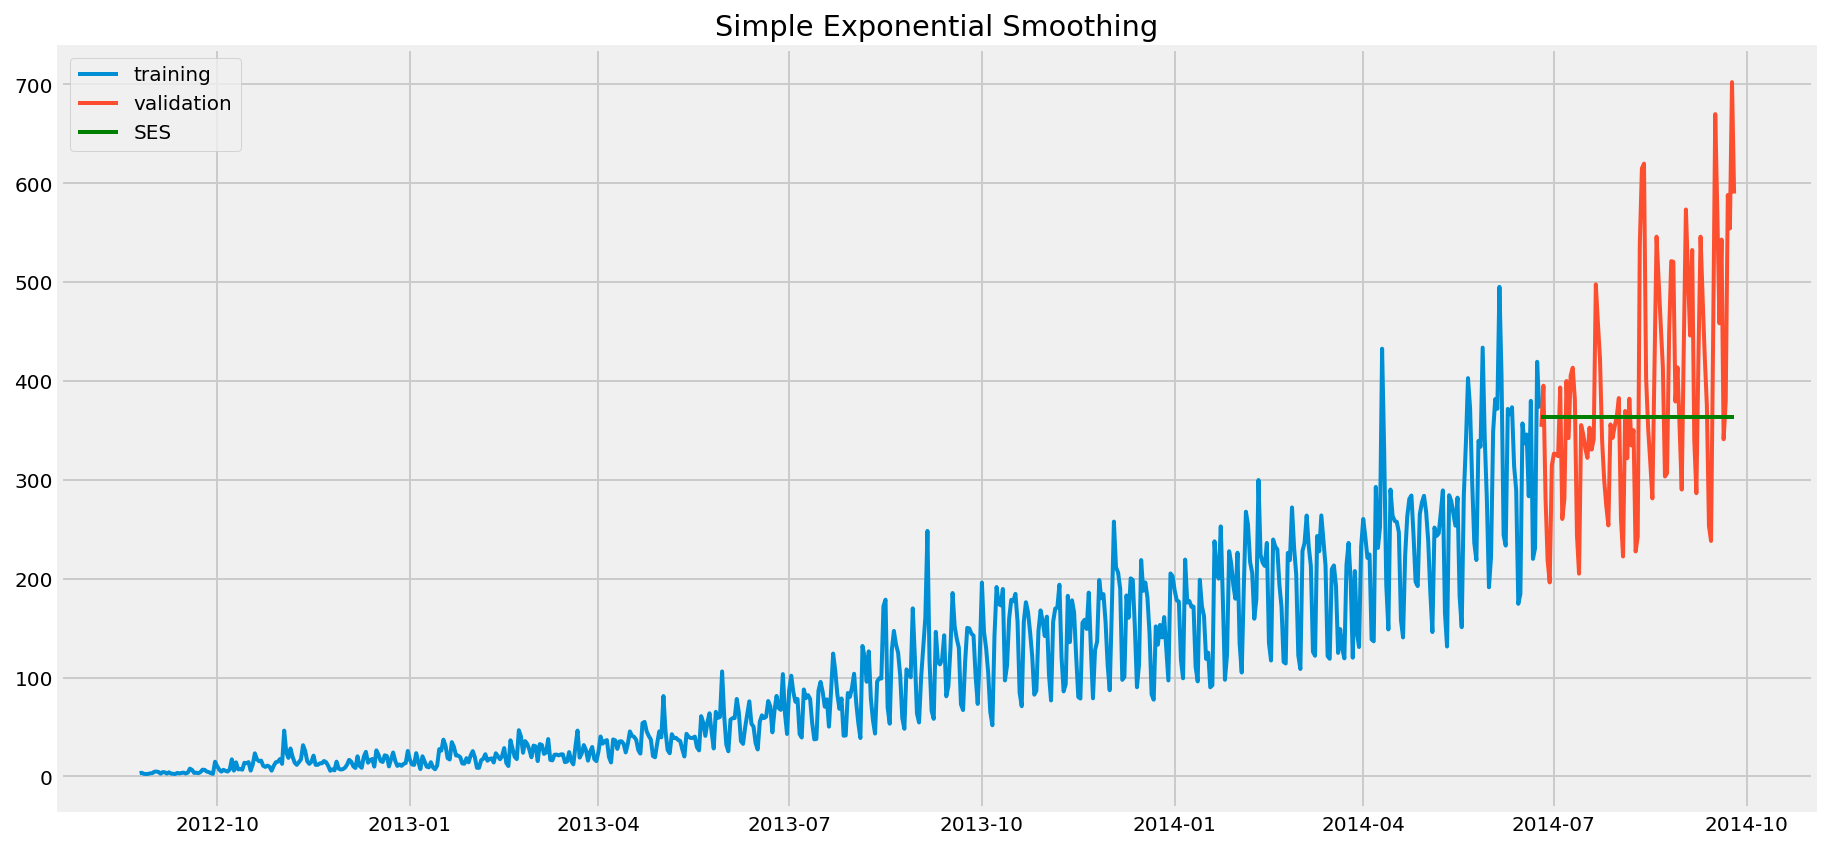

Root Mean Squared Error : 113.43708


In [27]:
y_hat_exp = validation_Set_dataframe.copy()
display.display(y_hat_exp.head())

fit_exp = SimpleExpSmoothing(np.asarray(train_set_dataframe['Count'])).fit(
    smoothing_level=0.6, optimized=False)

y_hat_exp['SES'] = fit_exp.forecast(len(validation_Set_dataframe))
display.display(y_hat_exp.head())

plt.figure(figsize=(14, 7))
plt.plot(
    train_set_dataframe.index,
    train_set_dataframe.Count,
    lw=2,
    label='training')
plt.plot(
    validation_Set_dataframe.index,
    validation_Set_dataframe.Count,
    lw=2,
    label='validation')
plt.plot(y_hat_exp.index, y_hat_exp.SES, lw=2, c='g', label='SES')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

rmse_exp = math.sqrt(
    metrics.mean_squared_error(y_hat_exp.SES, validation_Set_dataframe.Count))
print('Root Mean Squared Error : {:.5f}'.format(rmse_exp))

### Some Statistics with Statsmodels

Result: 
(2.9863509590138575, 1.0, 20, 741, {'1%': -3.4392057325732104, '5%': -2.8654483492874236, '10%': -2.5688512291811225}, 7212.068059584323)


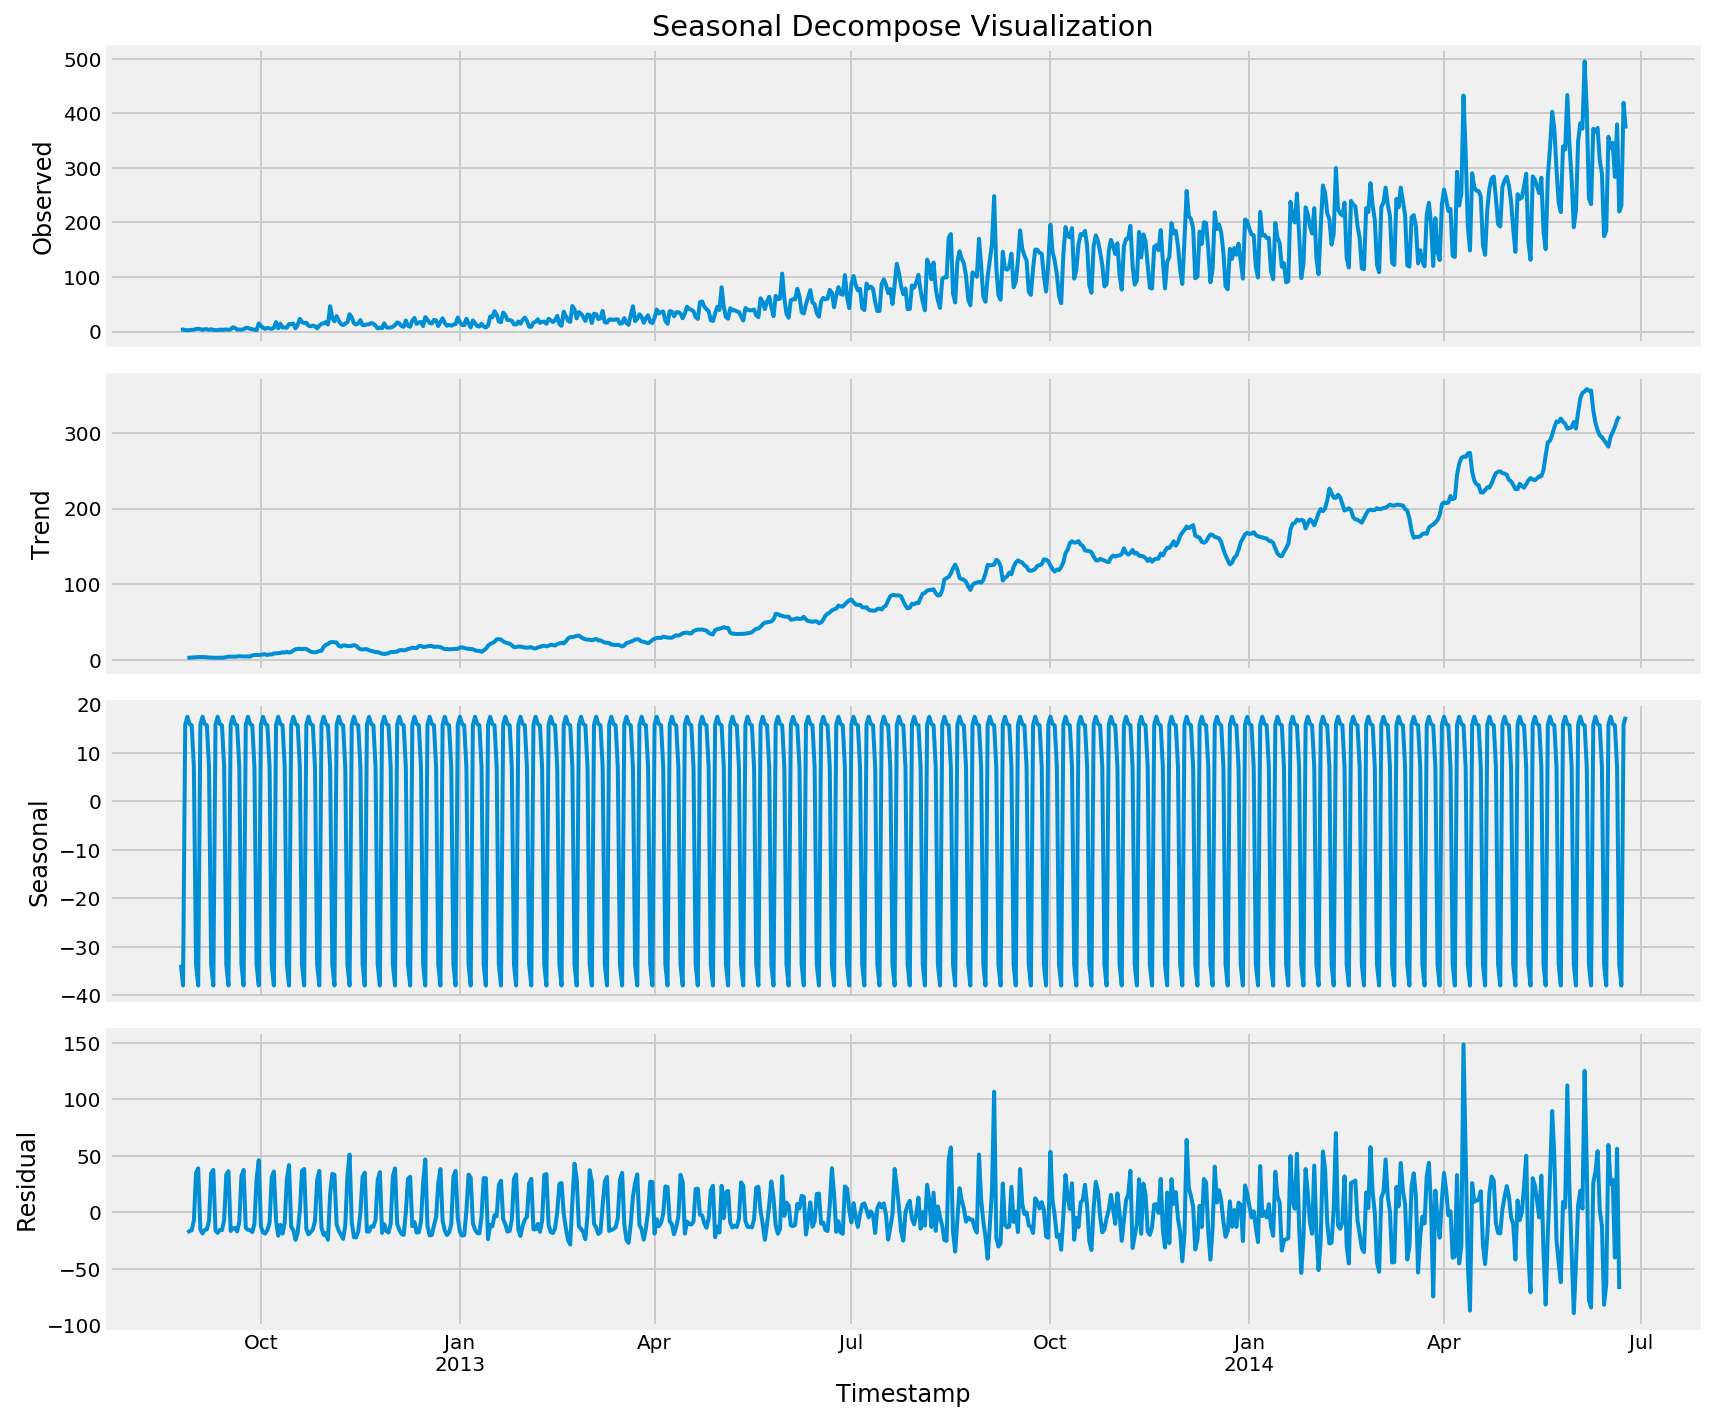

In [28]:
# seasonal_decompose(train_set_dataframe.Count).plot()
result = adfuller(train_dataframe.Count)
print("Result: \n{}".format(result))
# plt.show()

dta = seasonal_decompose(train_set_dataframe.Count)
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), sharex=True)

dta.observed.plot(ax=axs[0], legend=False, lw=2)
axs[0].set_title('Seasonal Decompose Visualization')
axs[0].set_ylabel('Observed')

dta.trend.plot(ax=axs[1], legend=False, lw=2)
axs[1].set_ylabel('Trend')

dta.seasonal.plot(ax=axs[2], legend=False, lw=2)
axs[2].set_ylabel('Seasonal')

dta.resid.plot(ax=axs[3], legend=False, lw=2)
axs[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

### Double Exponential Smoothing or Holt's Trend Corrected Exponential Smoothing

Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00

Count    year  month   day  Hour  day_of_week  weekend  \
Timestamp                                                            
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00   
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00   
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00   
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00   
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00   

            holt_linear  
Timestamp                
2014-06-25       334.65  
2014-06-26       337.16  
2014-06-27       339.67  
2014-06-28       342.18  
2014-06-29       344.68

Count    year  month   day  Hour  day_of_week  weekend  \
Timestamp                                                            
2014-09-21 379.25 2014.00   9.00 21.00 11.50         6.00     1.00   
2014-09-22 588.17 2014.00   9.00 22.00 11.50         0.00     0.00   
2014-09-23 554.33 2014.00   9.00 23.00 11.50         1.00     0.00   
2014-09-24 702.33 2014.00   9.00 24.00 11.50         2.00     0.00   
2014-09-25 589.67 2014.00   9.00 25.00 11.50         3.00     0.00   

            holt_linear  
Timestamp                
2014-09-21       555.38  
2014-09-22       557.88  
2014-09-23       560.39  
2014-09-24       562.90  
2014-09-25       565.41

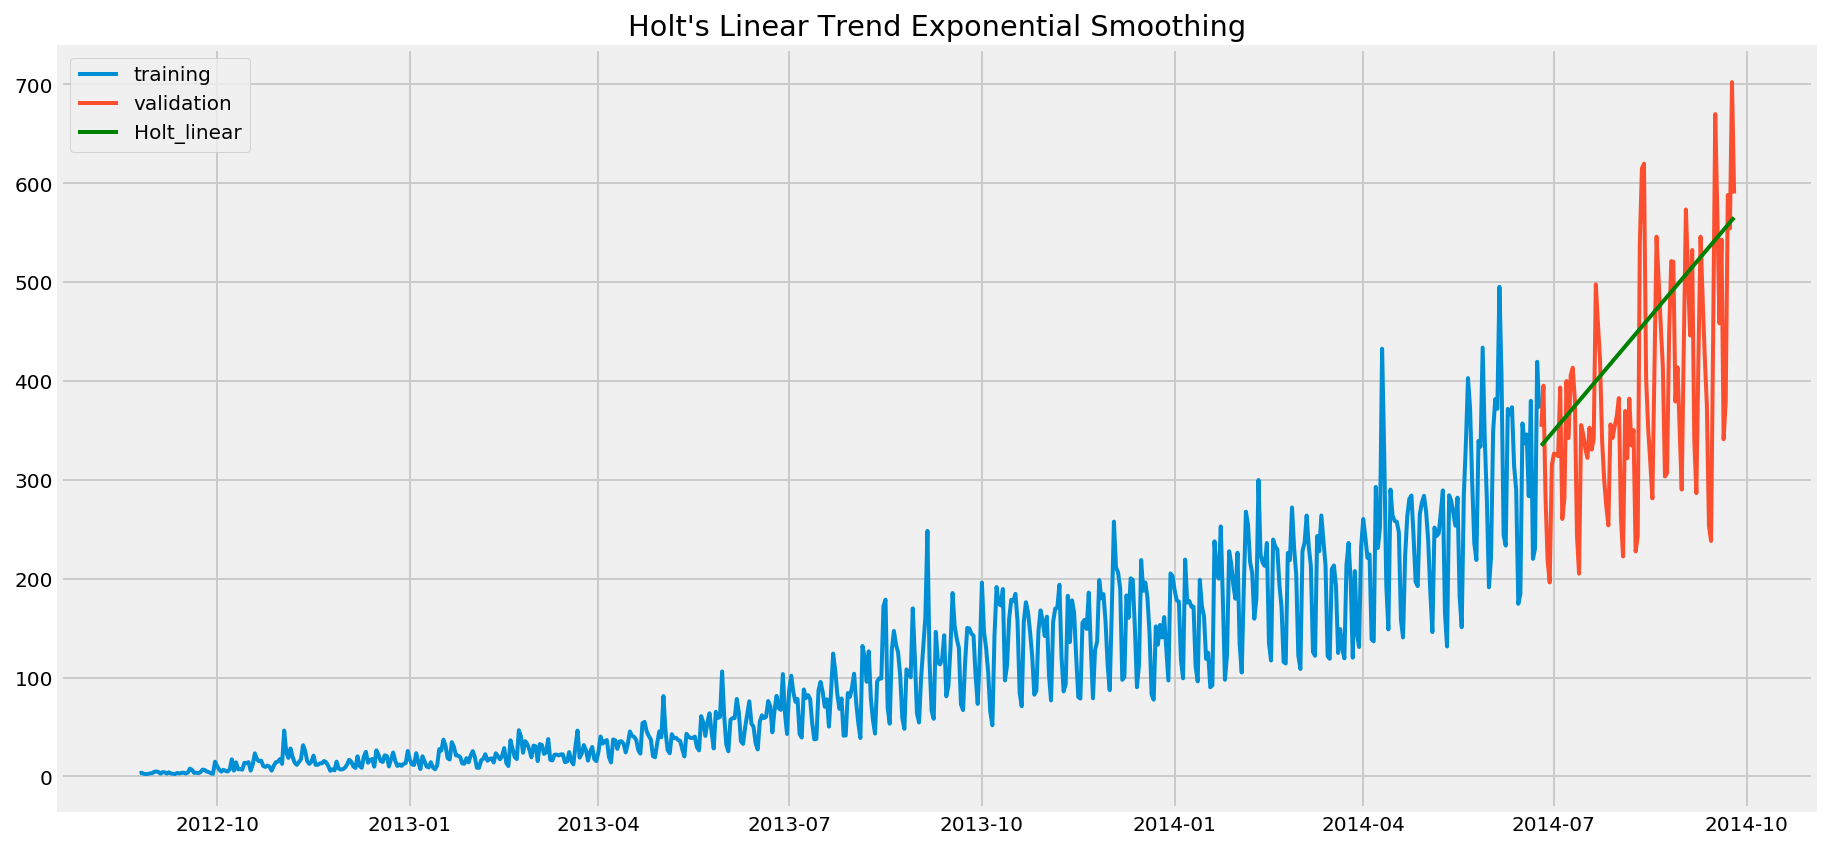

Root Mean Squared Error : 112.94278


In [29]:
y_hat_holt = validation_Set_dataframe.copy()
display.display(y_hat_holt.head())

fit_holt = Holt(np.asarray(train_set_dataframe.Count)).fit(
    smoothing_level=0.3, smoothing_slope=0.1)
y_hat_holt['holt_linear'] = fit_holt.forecast(len(validation_Set_dataframe))
display.display(y_hat_holt.head())
display.display(y_hat_holt.tail())

plt.figure(figsize=(14, 7))
plt.plot(
    train_set_dataframe.index,
    train_set_dataframe.Count,
    lw=2,
    label='training')
plt.plot(
    validation_Set_dataframe.index,
    validation_Set_dataframe.Count,
    lw=2,
    label='validation')
plt.plot(
    y_hat_holt.index, y_hat_holt.holt_linear, c='g', lw=2, label='Holt_linear')
plt.title('Holt\'s Linear Trend Exponential Smoothing')
plt.legend()
plt.show()

rmse_holt = math.sqrt(
    metrics.mean_squared_error(y_hat_holt.holt_linear,
                               validation_Set_dataframe.Count))
print('Root Mean Squared Error : {:.5f}'.format(rmse_holt))

### Holt Winter's Model

Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00

Count    year  month   day  Hour  day_of_week  weekend  \
Timestamp                                                            
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00   
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00   
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00   
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00   
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00   

            holt_winter  
Timestamp                
2014-06-25       387.36  
2014-06-26       369.14  
2014-06-27       355.56  
2014-06-28       247.09  
2014-06-29       246.19

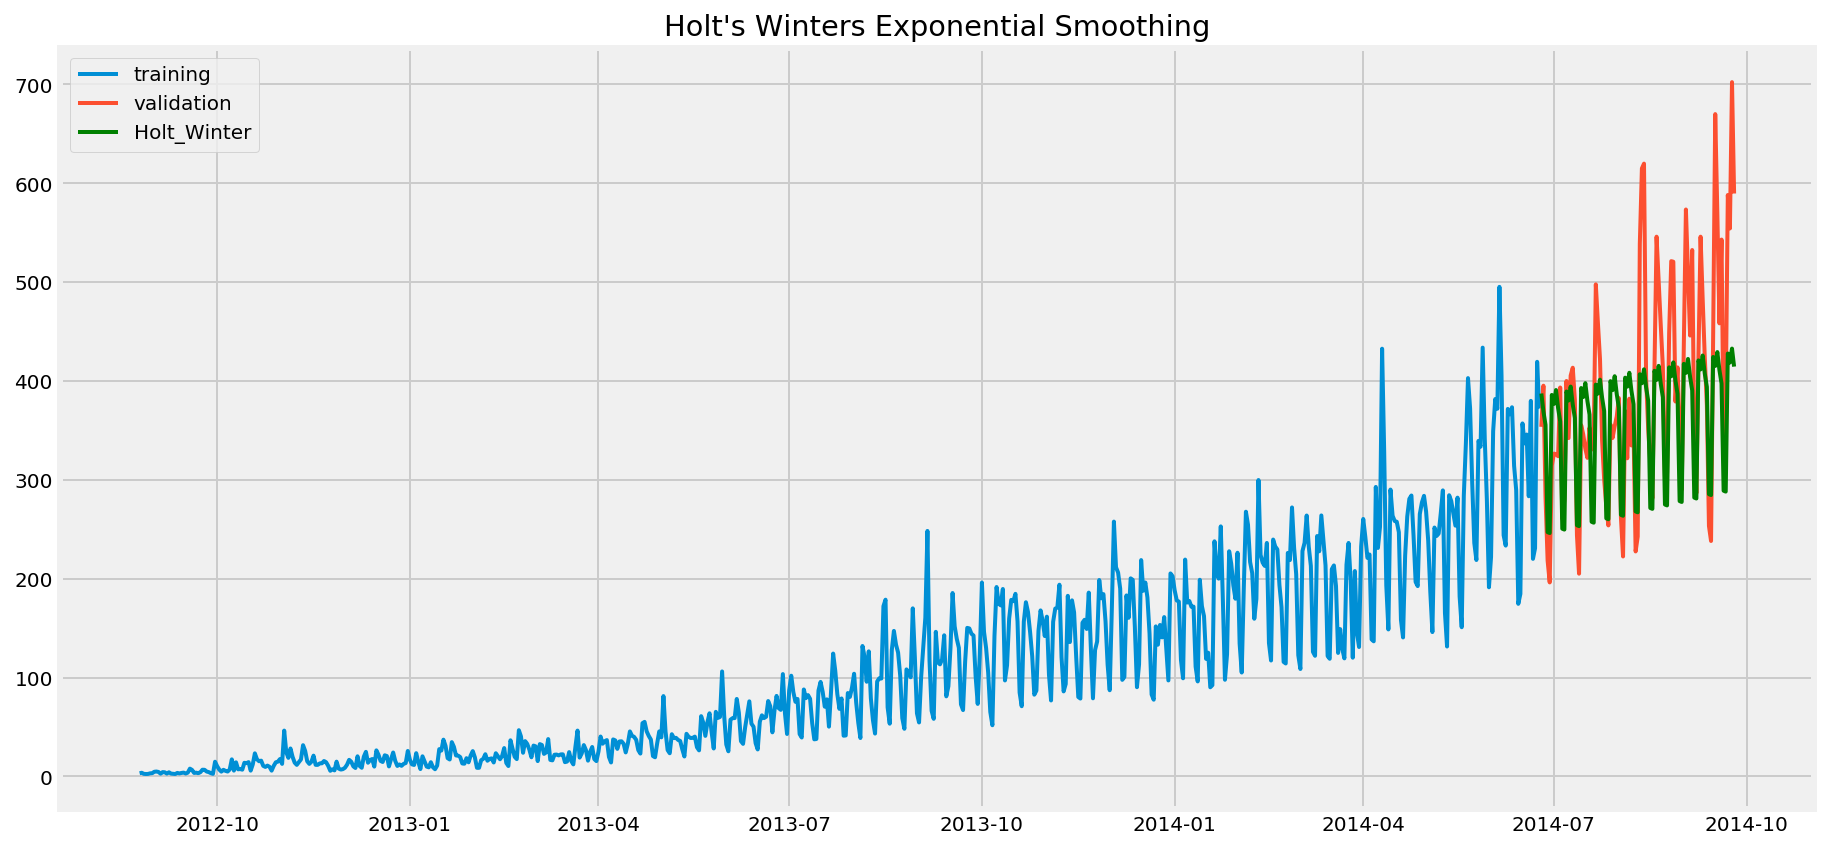

Root Mean Squared Error : 82.37901


In [30]:
y_hat_holt_win = validation_Set_dataframe.copy()
display.display(y_hat_holt_win.head())

fit_holt_win = ExponentialSmoothing(
    np.asarray(train_set_dataframe.Count),
    seasonal_periods=7,
    trend='add',
    seasonal='add').fit()
y_hat_holt_win['holt_winter'] = fit_holt_win.forecast(
    len(validation_Set_dataframe))
display.display(y_hat_holt_win.head())

plt.figure(figsize=(14, 7))
plt.plot(
    train_set_dataframe.index,
    train_set_dataframe.Count,
    lw=2,
    label='training')
plt.plot(
    validation_Set_dataframe.index,
    validation_Set_dataframe.Count,
    lw=2,
    label='validation')
plt.plot(
    y_hat_holt_win.index,
    y_hat_holt_win.holt_winter,
    c='g',
    lw=2,
    label='Holt_Winter')
plt.title('Holt\'s Winters Exponential Smoothing')
plt.legend()
plt.show()

rmse_holt_win = math.sqrt(
    metrics.mean_squared_error(y_hat_holt_win.holt_winter,
                               validation_Set_dataframe.Count))
print("Root Mean Squared Error : {:.5f}".format(rmse_holt_win))

### Autoregressive Integrated Moving Average (ARIMA)
#### Stationarity process
Stationarity process is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently parameters such as mean and variance, if they are present, also do not change over time.
* The mean of the time series should not be a function of time. It should be constant.
* The variance of the time series should not be a function of time.
* The covariance of the $ith$ term and the $(i+m)th$ term should not be a function of time.

Converting a time series into stationary form will make all the variables independent. Independent variables give much more information about data. Removing trend and seasonality will make the time series stationary.
#### Differencing
Differencing is a method of transforming a time series dataset. It can be used to remove the series dependence on time, so called temporal dependence. This includes structures like `trends` and `seasonality`.

__Differencing can help stabilize the mean of the time series by removing changes in the level of time series, and so eleminating (or reducing) trend and seasonality.__
```python
>>> difference(t) = observation(t) - observation(t-1)
```
#### Lag Difference
Taking the difference between consecutive observations is called a __lag-1 Difference__. Lag difference can be adjusted to suit the specific temporal structure. For time series with a seasonal component, the lag may be expected to be the period (width) of the seasonality.
#### Differencing Order
Temporal structure may still exist after performing a difference operations, such as in the case of a `non-linear trend`. As such, the process of differencing can be repeated more than once untill all temporal dependence has been removed. The number of times that differencing is performed is called the __differencing order__.
#### Autocorrelation
It is a charactersitics of data in which the correlation between the values of the same variables is based on related objects. It violates the assumptions of instance independence, which underlies most of the conventional models. It generally exists in those types of datasets in which the data, instead of being randomly selected, is from the same source.<br />In time series data, it generally occurs due to sluggishness or inertia within the data. Correlation between the elements of a series and others from the same series separated from them by a given interval.
#### ARIMA
Autoregressive Integrated Moving Average model is generalisation of an Autoregressive Moving Average (ARMA) model. Both of these models are fitted to timeseries data either to better understand the data or to predict future points in the timeseries(forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the integrated part of the model) can be applied one or more times to eliminate non-stationarity.
* __AR__ $-$ Evolving variables of interest is regressed on its own lagged (i.e., prior) values. `Lags of stationarized series are called "auto-regressive"`.
* __MA__ $-$ Regression error is actually a linear combination of error terms whose values occured contemporaneously and at various times in the past. `Lags of the forecast erros are called "moving average"`.
* __I__ $-$ Data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once). `A series which needs to be differenced to be made stationary is an "integrated" series`.

The ARIMA forecasting for a stationary time series is a linear (like a linear regression) equation.

$ARIMA(p, d, q)$<br>
$p$ $:$ orderof autoregressive model (number of time lags)<br>
$d$ $:$ degree of differencing (number of times the data have had past values substracted)<br>
$q$ $:$ order of moving average<br>
#### Dickey-Fuller Test
Dickey-Fuller Test tests $H_0$ that a `unit root` is present (non-stationary) in an `autoregressive` model. $H_1$ is different depending on which versions of the test is used, but is usually stationarity or trend-stationarity.<br> A simple $AR(1)$ model is $$y_t=\rho y_{t-1}+u_t$$ where, $y_t$ is variable of interest $t$ is time index $u_t$ is error term.<br><br> A `unit root` is present if $\rho = 1$. The model would be non-stationary in this case.<br>
A `regression model` can be written as $$\triangledown y_t=(\rho-1)y_{t-1}+u_t=\delta y_{t-1}+u_t$$ where, $\delta$ is the difference operator.
#### Unit root test
Unit root test, tests whether a time series variable is non-stationary and possess a `unit root`. $H_0$ is generally defined as the presence of unit root and $H_1$ is either stationarity. trend stationarity or explosive root depending on the test used.

In [31]:
def test_stationarity(time_Series):
    """A function to test stationarity of time-series variable."""

    # rolling statistics
    rolmean = time_Series.rolling(window=24).mean()
    rolstd = time_Series.rolling(window=24).std()

    # plot rolling statistics
    orig = plt.plot(time_Series, c='b', lw=2, label='Original')
    mean = plt.plot(rolmean, c='r', lw=2, label='Rolling Mean')
    std = plt.plot(rolstd, c='k', lw=2, label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show(block=False)

    # perform Dickey-Fuller test
    print('-' * 29)
    print('Result of Dickey-Fuller Test:')
    print('-' * 29)
    dftest = adfuller(time_Series, autolag='AIC')
    # display.display(dftest)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            'Test Statistic', 'p-value', '#Lags Used',
            'Number of Observations Used'
        ])
    # display.display(dfoutput.head())
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = "{:.5f}".format(value)
    print(dfoutput)

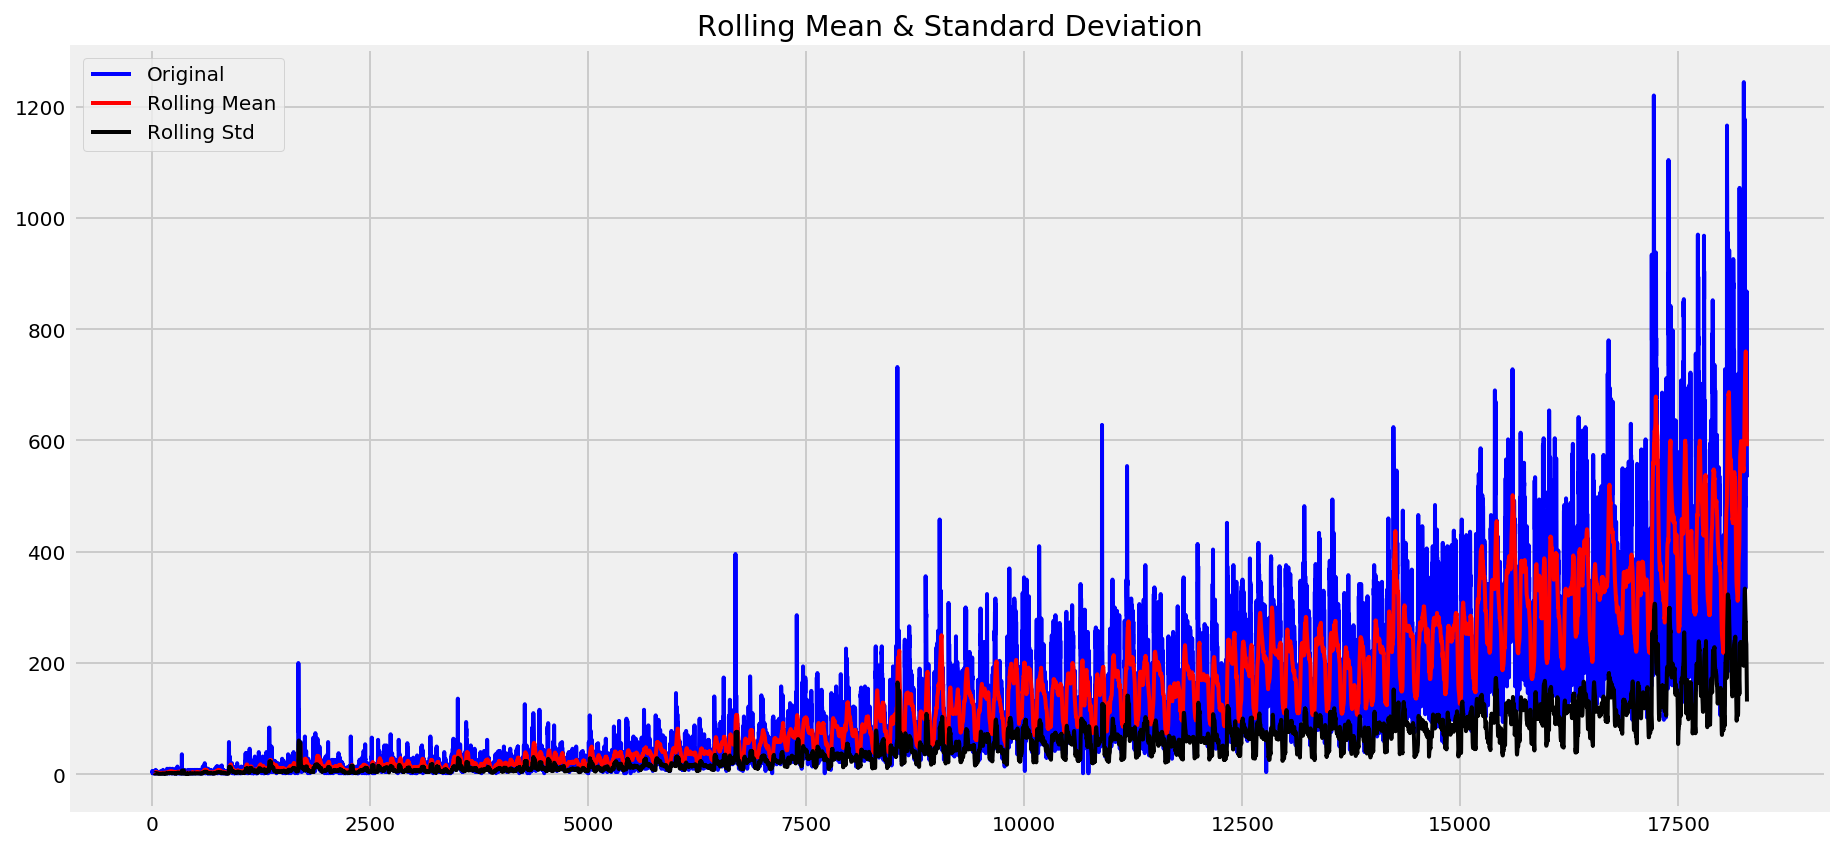

-----------------------------
Result of Dickey-Fuller Test:
-----------------------------
Test Statistic                    -4.46
p-value                            0.00
#Lags Used                        45.00
Number of Observations Used    18242.00
Critical Value (1%)            -3.43071
Critical Value (5%)            -2.86170
Critical Value (10%)           -2.56685
dtype: object


In [32]:
rcParams['figure.figsize'] = 14, 7
test_stationarity(train_original_data['Count'])

### Removal of Trend
* A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.
* We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.
* We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that each day has 24 hours.

Timestamp
2012-08-25   1.15
2012-08-26   1.30
2012-08-27   0.95
2012-08-28   0.88
2012-08-29   0.92
Freq: D, Name: Count, dtype: float64

Timestamp
2014-06-25   5.87
2014-06-26   5.98
2014-06-27   5.64
2014-06-28   5.39
2014-06-29   5.28
Freq: D, Name: Count, dtype: float64

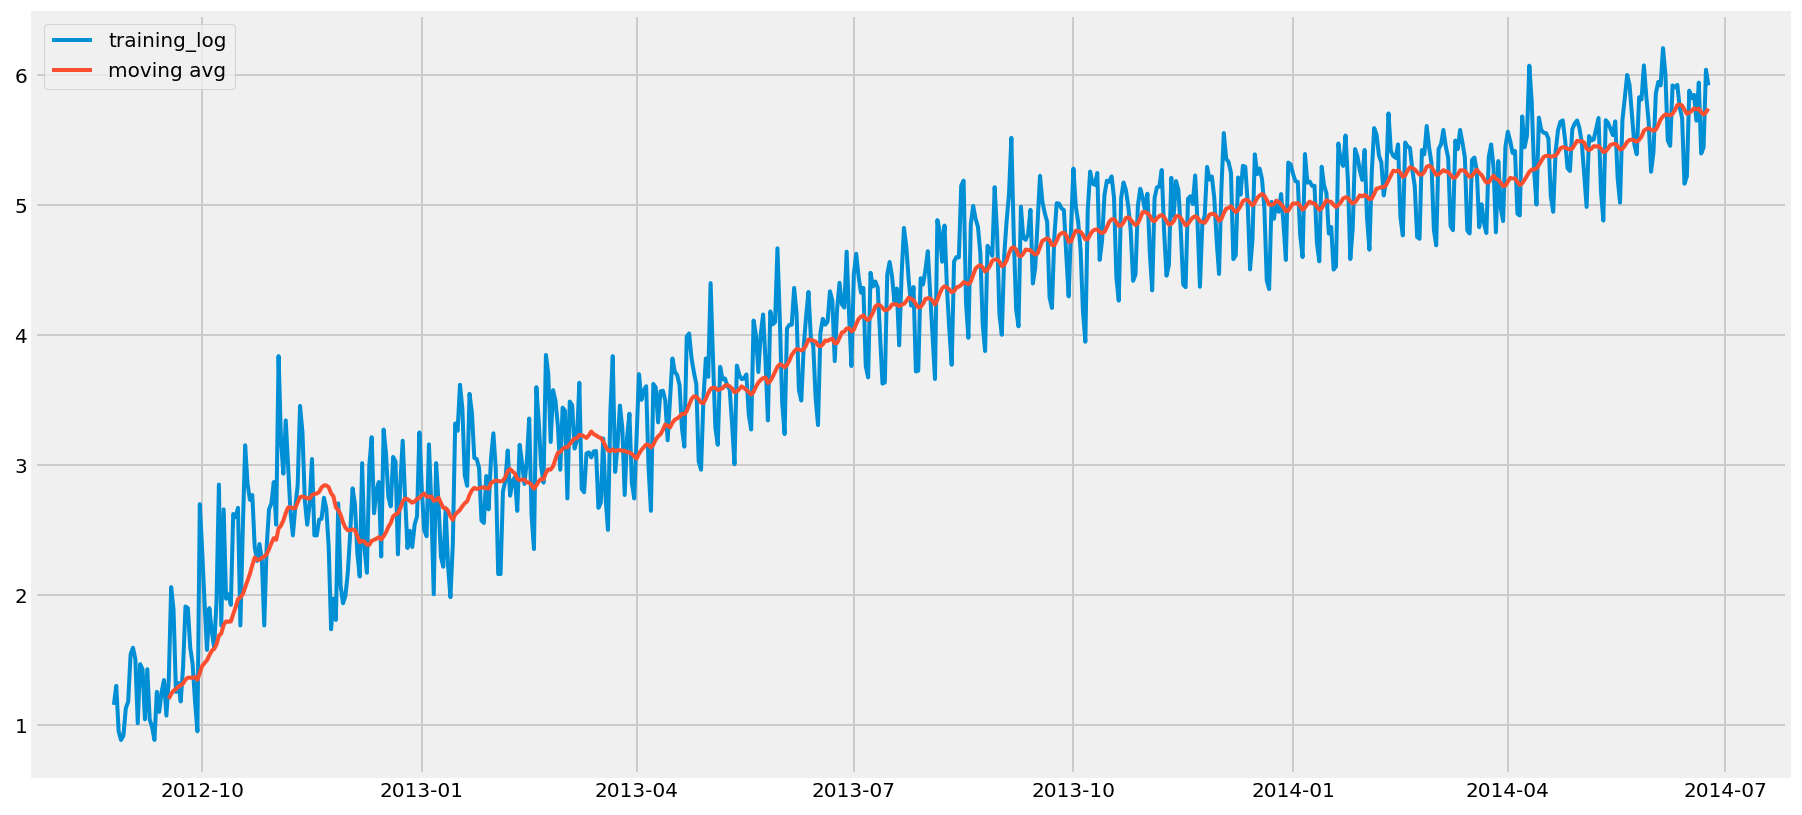

Timestamp
2014-06-20    0.20
2014-06-21   -0.32
2014-06-22   -0.25
2014-06-23    0.33
2014-06-24    0.18
Freq: D, Name: Count, dtype: float64

Timestamp
2012-09-17    0.14
2012-09-18    0.82
2012-09-19    0.62
2012-09-20   -0.02
2012-09-21    0.03
Freq: D, Name: Count, dtype: float64

Removal of Trend: 
-----------------


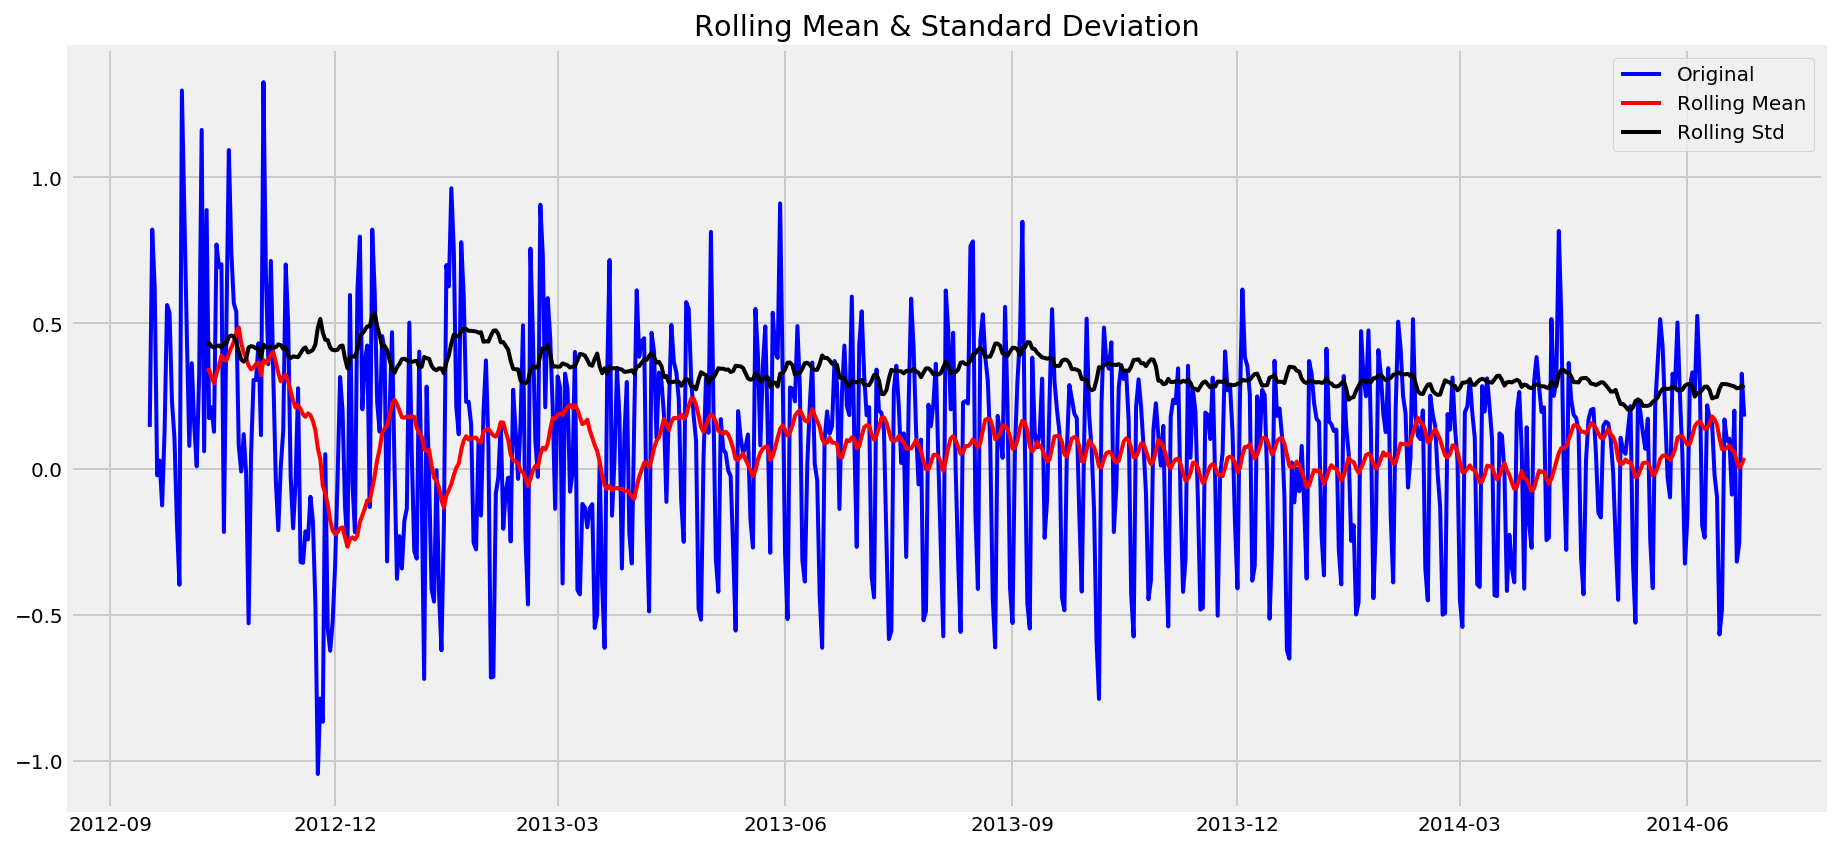

-----------------------------
Result of Dickey-Fuller Test:
-----------------------------
Test Statistic                    -5.86
p-value                            0.00
#Lags Used                        20.00
Number of Observations Used      625.00
Critical Value (1%)            -3.44086
Critical Value (5%)            -2.86618
Critical Value (10%)           -2.56924
dtype: object

Stablizing by Differencing: 
---------------------------


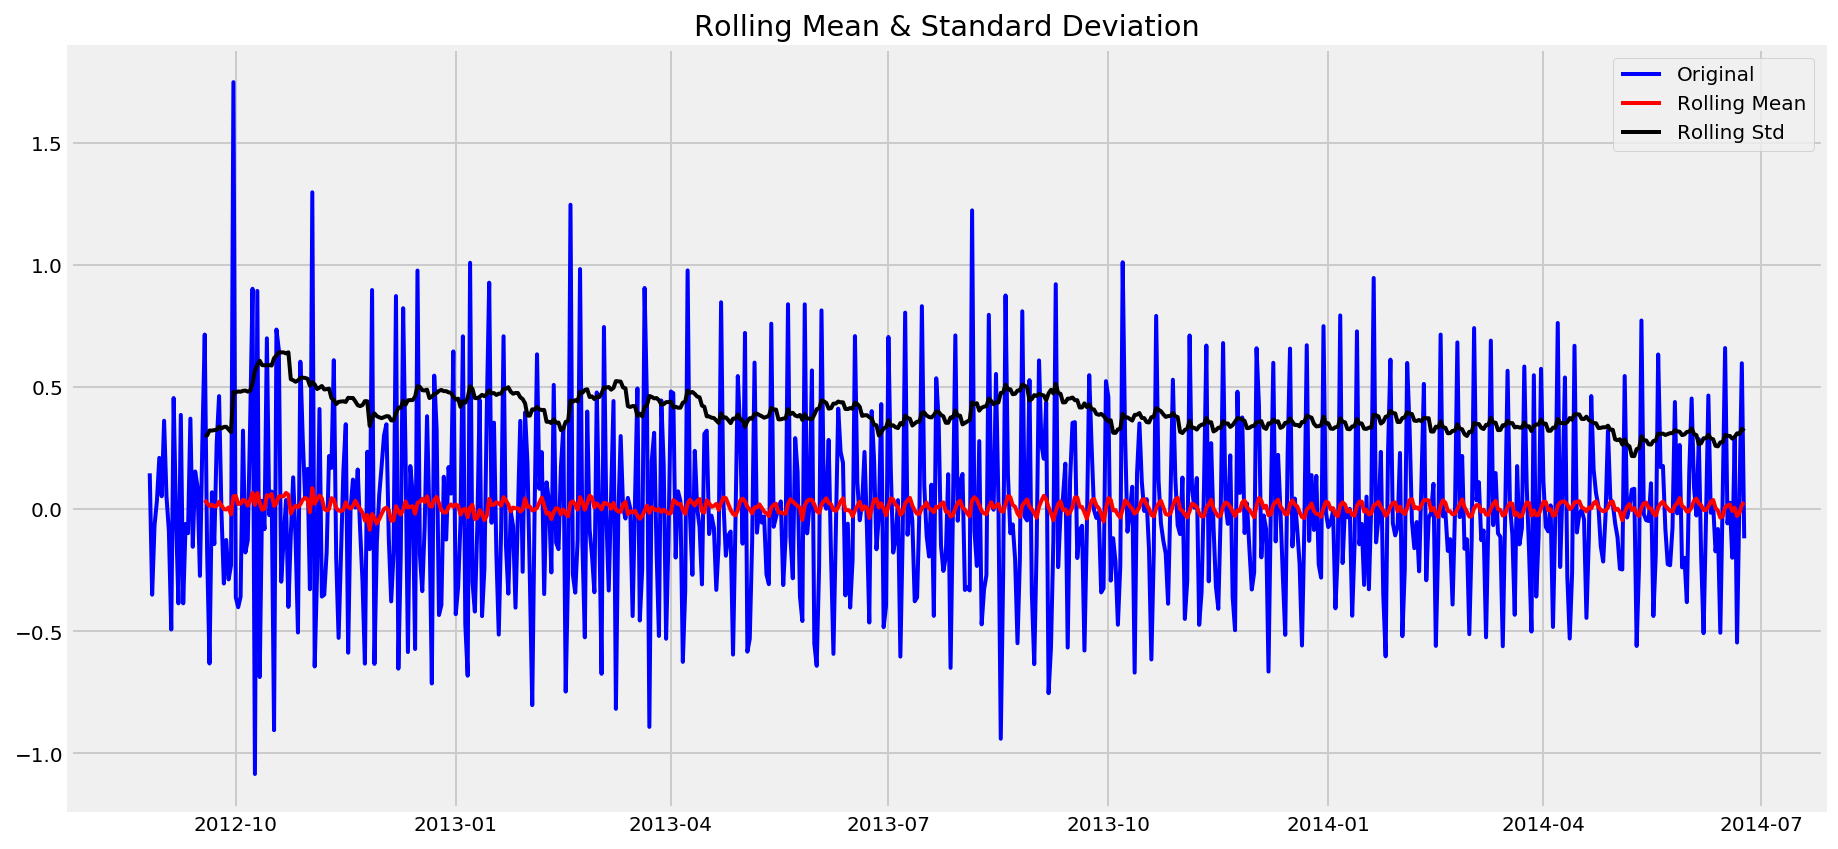

-----------------------------
Result of Dickey-Fuller Test:
-----------------------------
Test Statistic                    -8.24
p-value                            0.00
#Lags Used                        19.00
Number of Observations Used      648.00
Critical Value (1%)            -3.44048
Critical Value (5%)            -2.86601
Critical Value (10%)           -2.56915
dtype: object


In [33]:
train_log_set = np.log(train_set_dataframe['Count'])
validation_log_set = np.log(validation_Set_dataframe['Count'])
display.display(train_log_set.head())
display.display(validation_log_set.head())

mov_avg = train_log_set.rolling(window=24).mean()

plt.figure(figsize=(14, 7))
plt.plot(train_log_set, lw=2, label='training_log')
plt.plot(mov_avg, lw=2, label='moving avg')
plt.legend()
plt.show()

# removes trend
train_log_mov_avg_diff = train_log_set - mov_avg
display.display(train_log_mov_avg_diff.tail())

train_log_mov_avg_diff.dropna(inplace=True)
display.display(train_log_mov_avg_diff.head())
print("Removal of Trend: ")
print('-' * len('Removal of Trend:'))
test_stationarity(train_log_mov_avg_diff)

# Stablizing with differencing
train_log_diff = train_log_set - train_log_set.shift(1)
print("\nStablizing by Differencing: ")
print('-' * len('Stablizing by Differencing:'))
test_stationarity(train_log_diff.dropna())

### Removal of Seasonality
* By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
* Seasonality is always of a fixed and known period.
* We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.

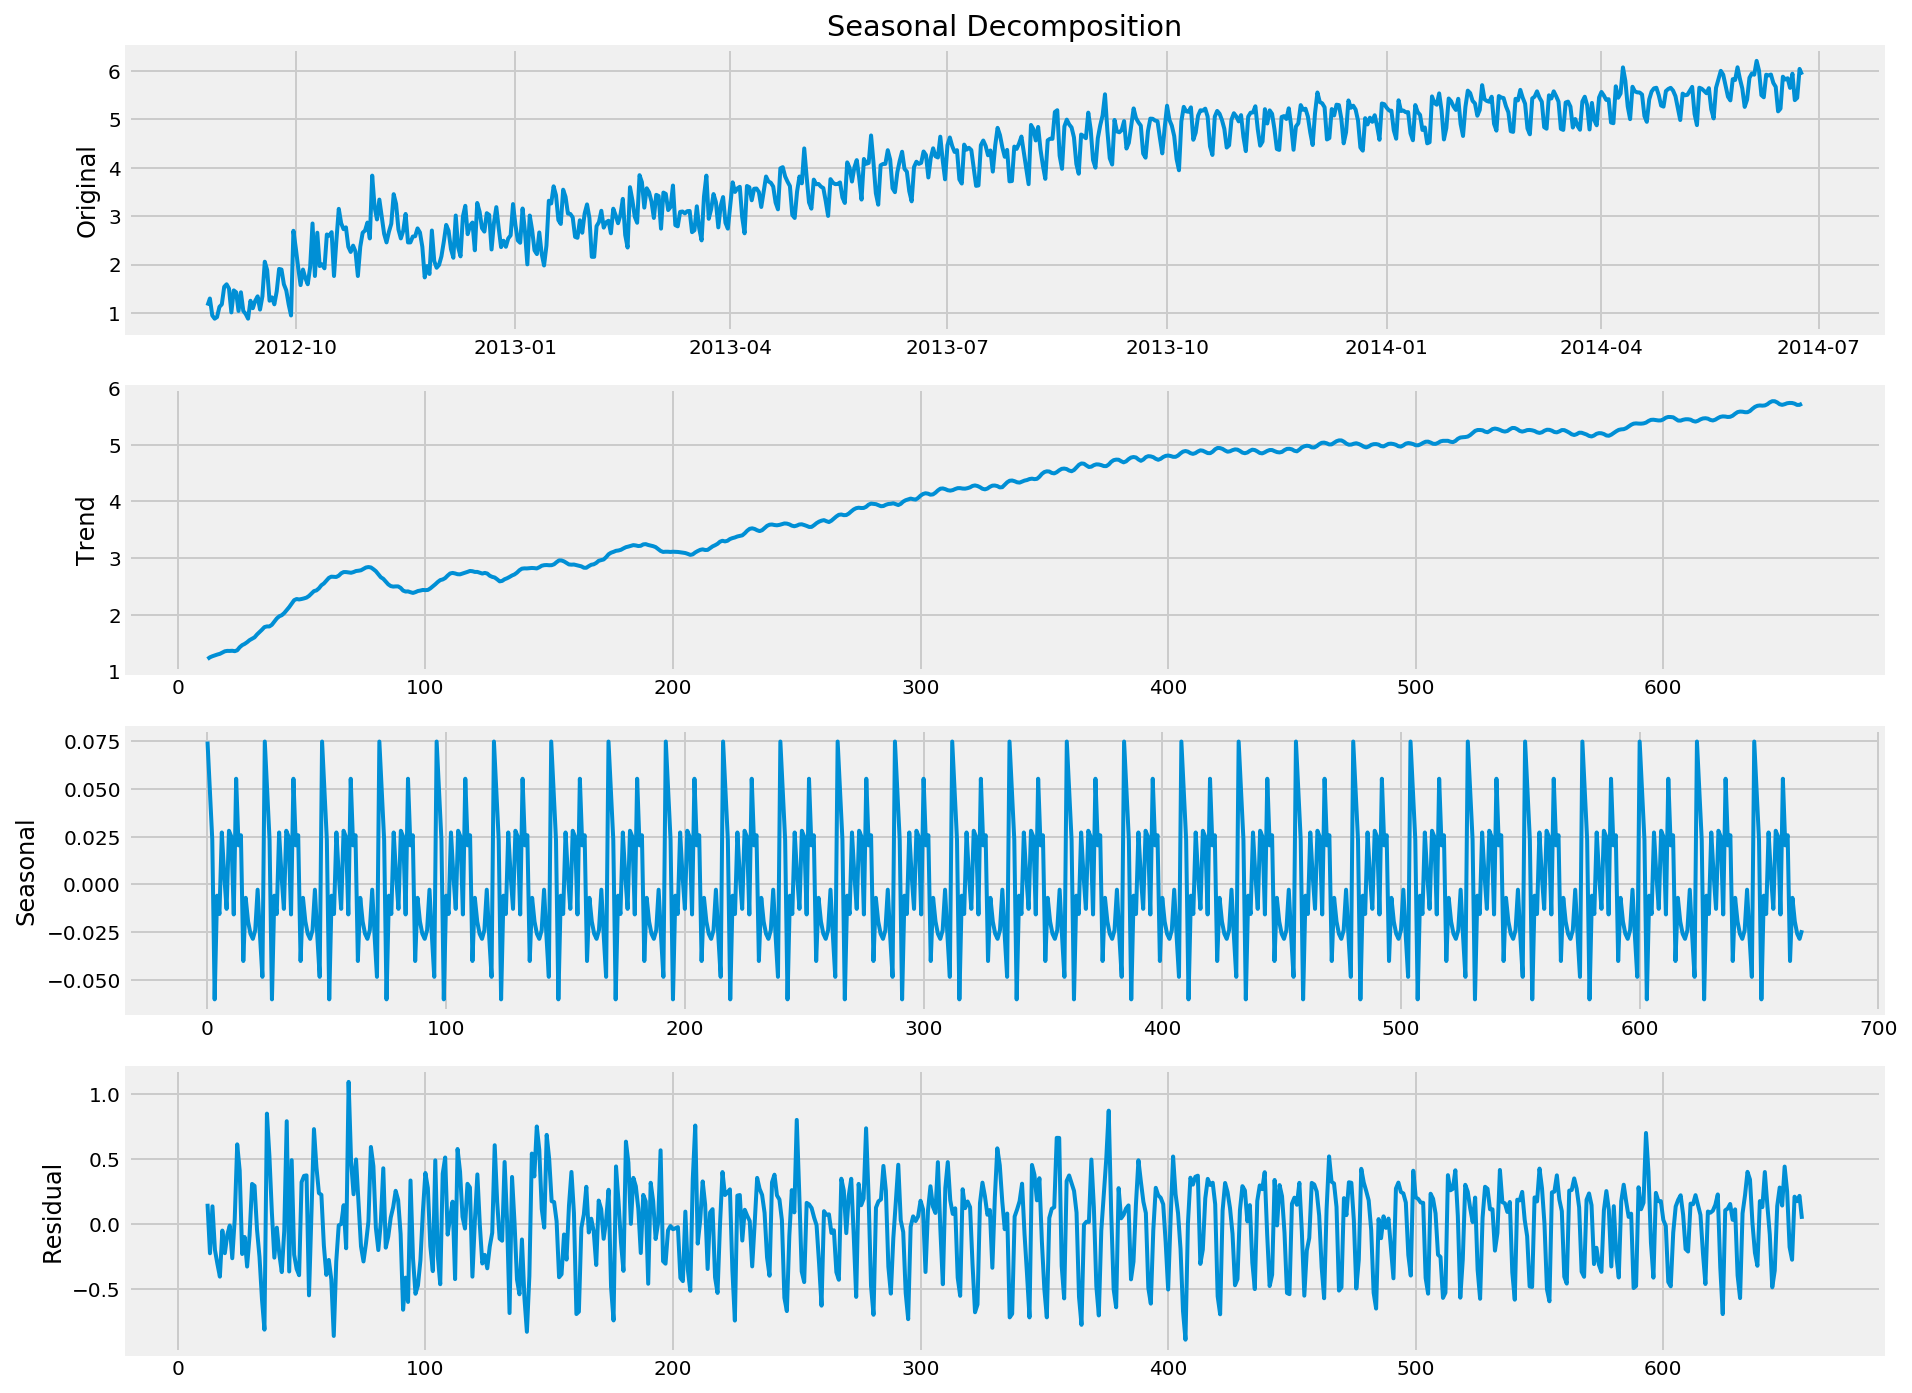

In [34]:
decomposition = seasonal_decompose(
    pd.DataFrame(train_log_set).Count.values, freq=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14, 12))

plt.subplot(411)
plt.plot(train_log_set, lw=2)
plt.ylabel('Original')
plt.title('Seasonal Decomposition')

plt.subplot(412)
plt.plot(trend, lw=2)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(seasonal, lw=2)
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(residual, lw=2)
plt.ylabel('Residual')
plt.show()

### Check the Stationarity of Residual

residual
date                
2012-09-06      0.15
2012-09-07     -0.23
2012-09-08      0.13
2012-09-09     -0.20
2012-09-10     -0.31

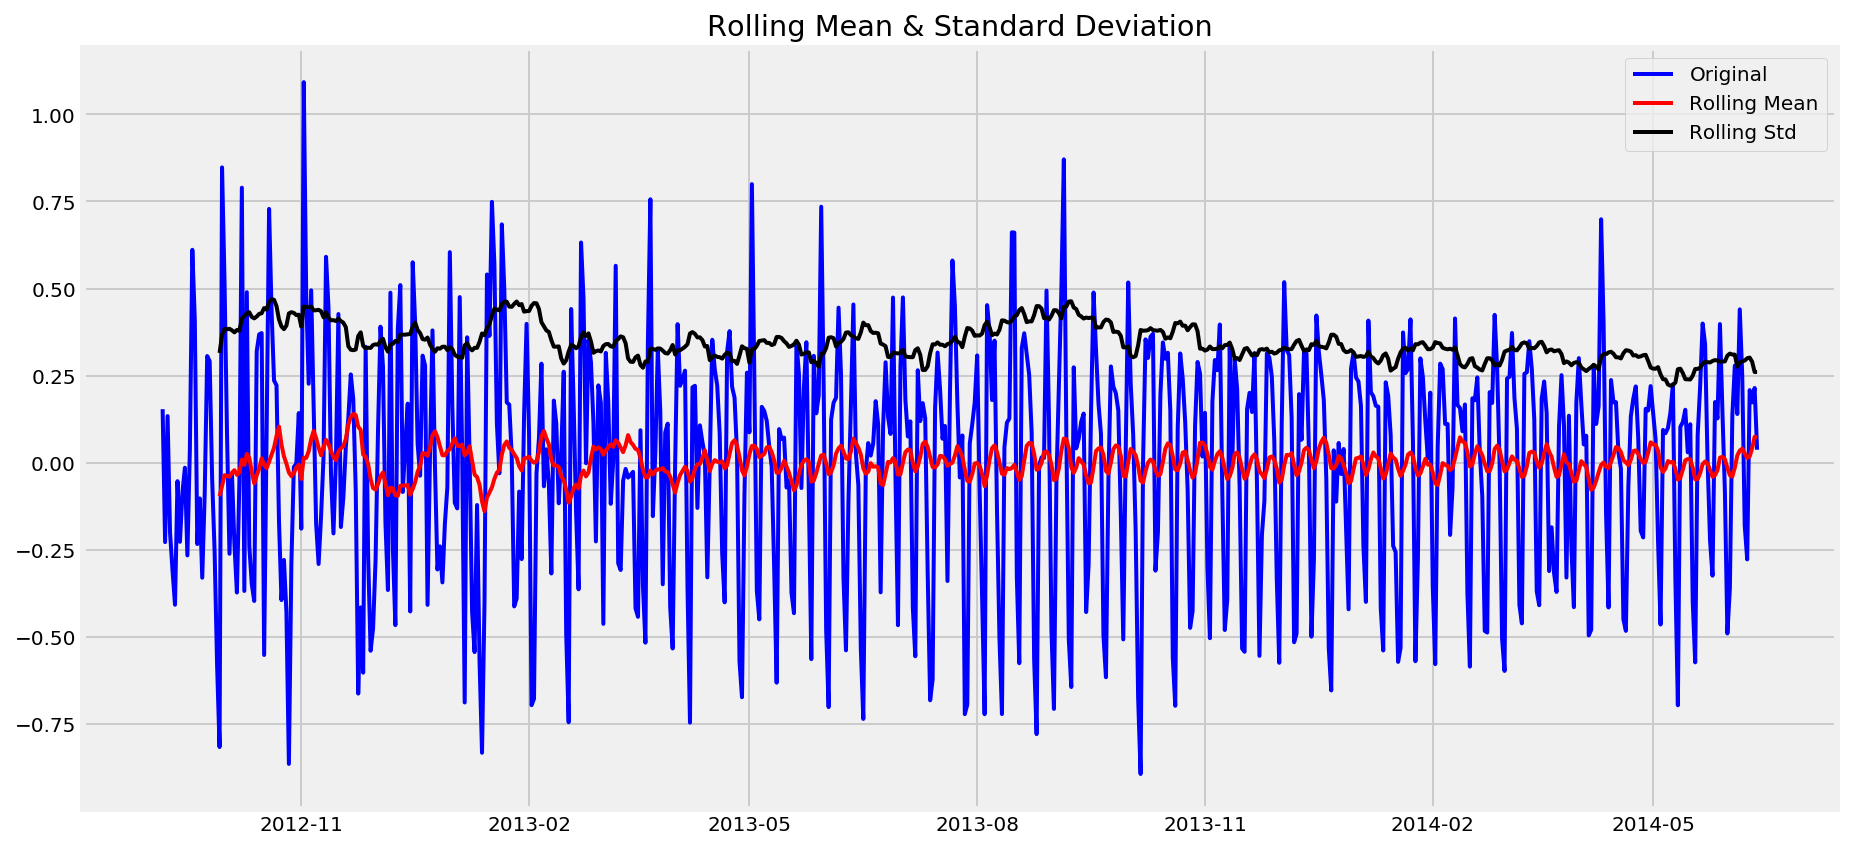

-----------------------------
Result of Dickey-Fuller Test:
-----------------------------
Test Statistic                    -7.82
p-value                            0.00
#Lags Used                        20.00
Number of Observations Used      624.00
Critical Value (1%)            -3.44087
Critical Value (5%)            -2.86618
Critical Value (10%)           -2.56924
dtype: object


In [35]:
train_log_decompose = pd.DataFrame(residual, columns=['residual'])
train_log_decompose['date'] = train_log_set.index
train_log_decompose.set_index('date', inplace=True)
train_log_decompose.dropna(inplace=True)
display.display(train_log_decompose.head())

test_stationarity(train_log_decompose['residual'])

### Forecasting Timeseries using ARIMA
* Find optimized $p, d, q$ parameter values.
* Fit ARIMA model to these parameter values.

__ACF__ is a measure of the correlation between the time series with a lagged version of itself.<br>
__PACF__ measures the correlation between the time series with a lagged versions of itself but after eliminating the variations already explained by the intervening comparisons.

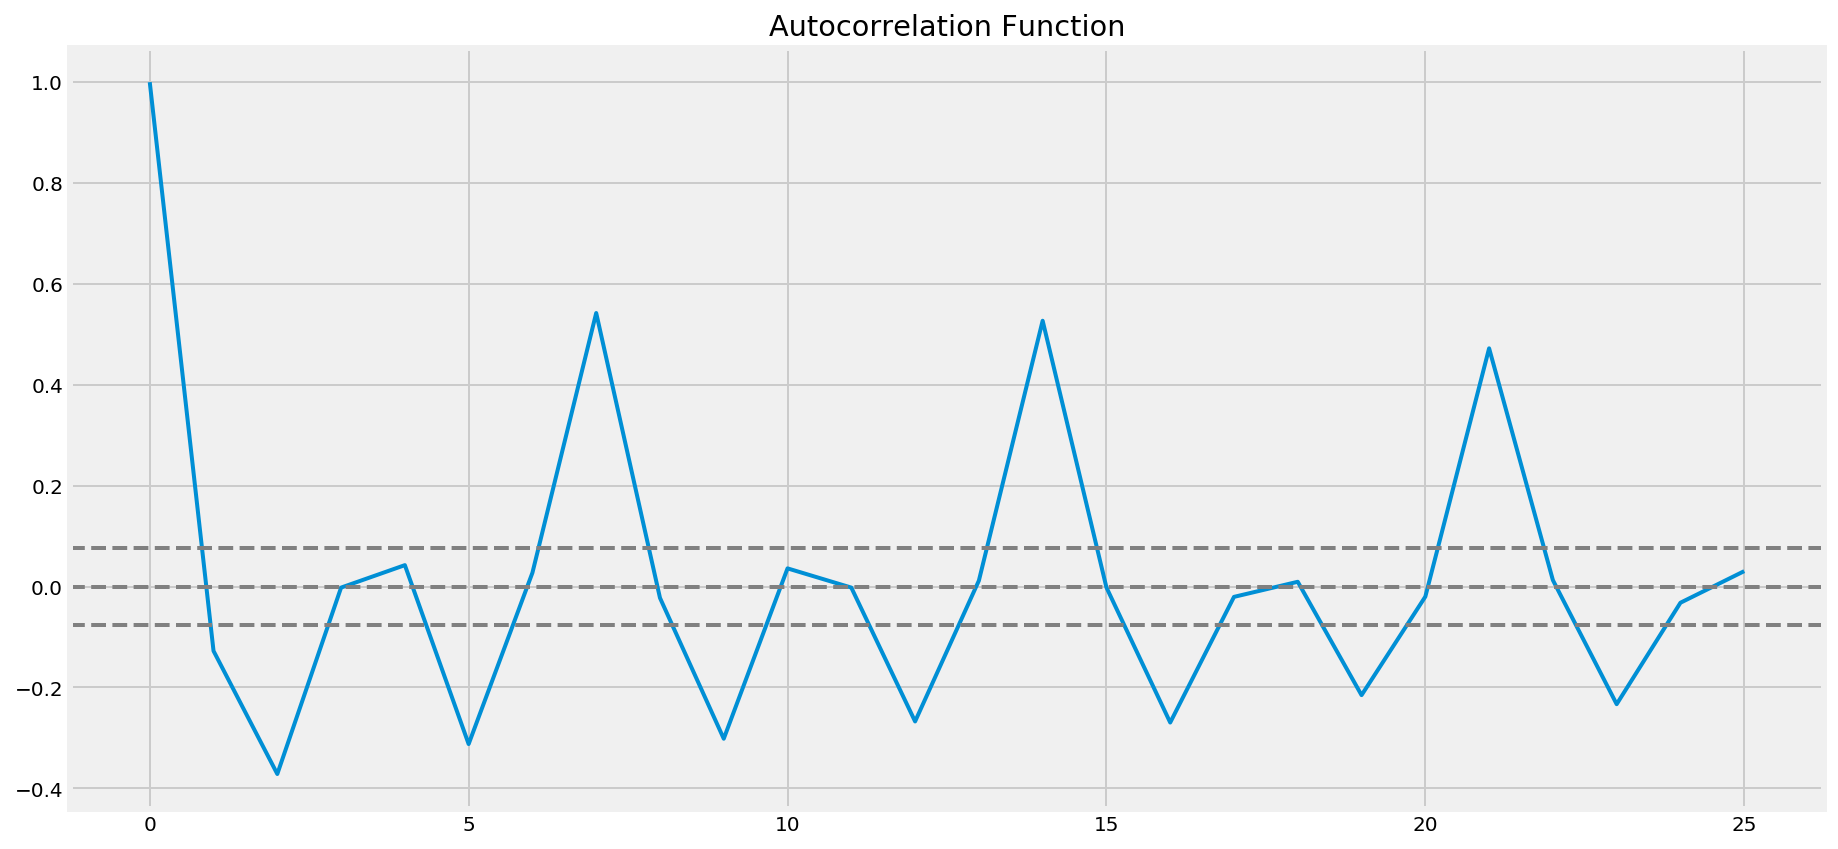

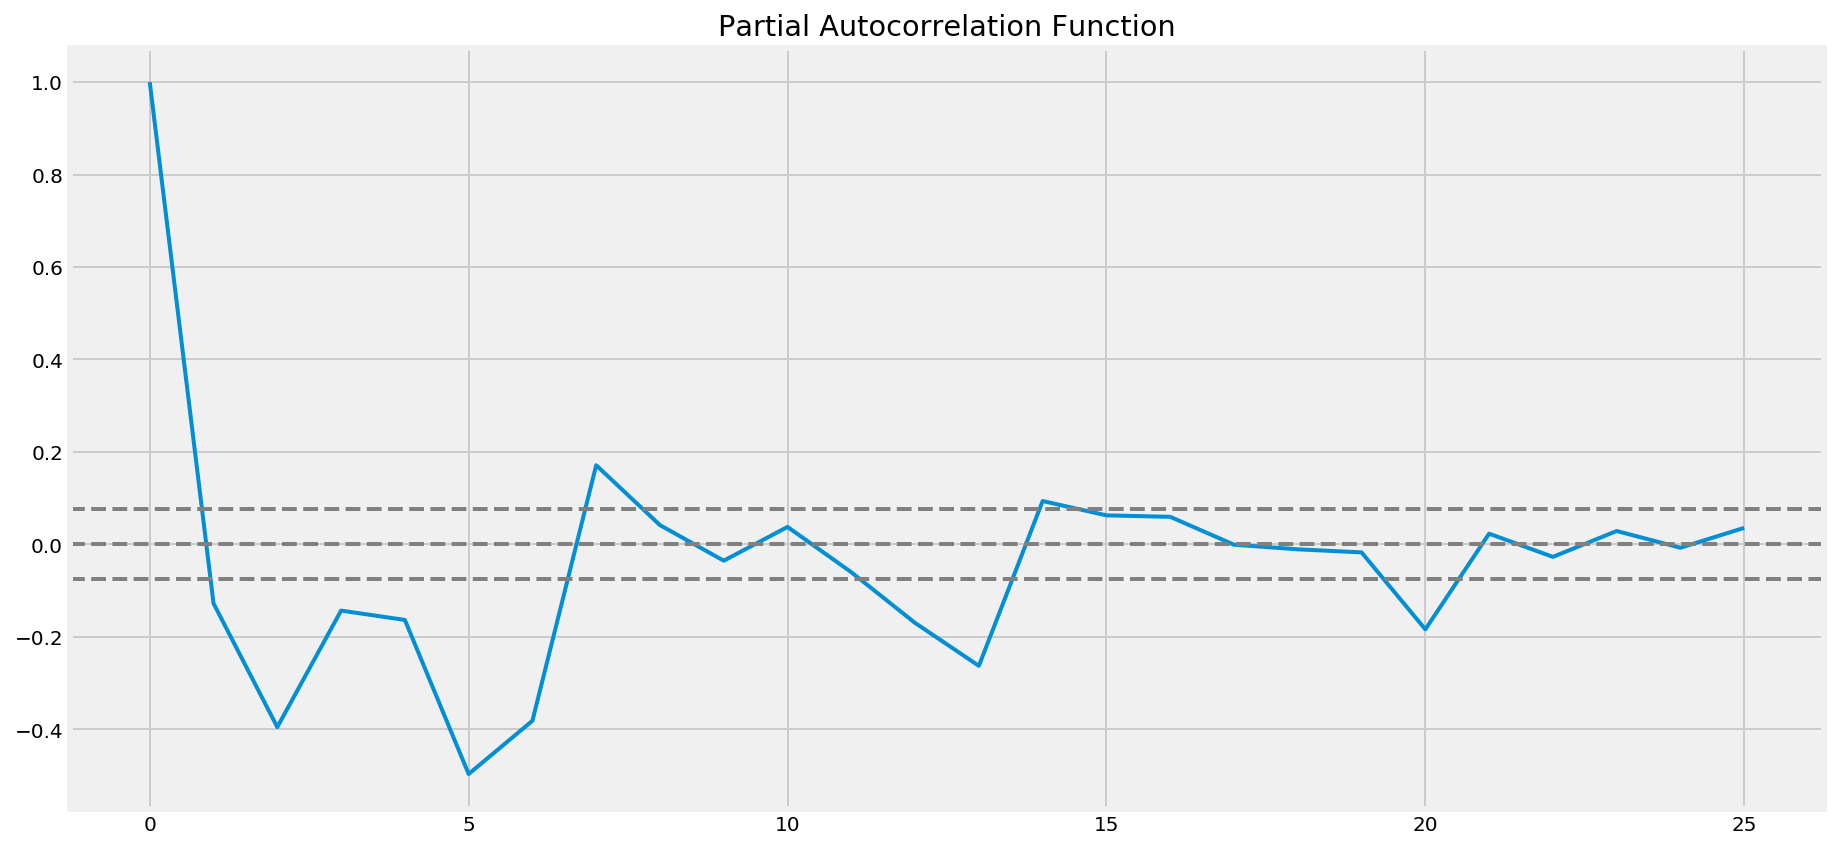

In [36]:
lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25)

plt.figure(figsize=(14, 7))
plt.plot(lag_acf, lw=2)
plt.axhline(y=0, linestyle='--', c='gray', lw=2)
plt.axhline(
    y=-1.96 / np.sqrt(len(train_log_diff.dropna())), ls='--', c='gray', lw=2)
plt.axhline(
    y=1.96 / np.sqrt(len(train_log_diff.dropna())), ls='--', c='gray', lw=2)
plt.title('Autocorrelation Function')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(lag_pacf, lw=2)
plt.axhline(y=0, linestyle='--', c='gray', lw=2)
plt.axhline(
    y=-1.96 / np.sqrt(len(train_log_diff.dropna())), ls='--', c='gray', lw=2)
plt.axhline(
    y=1.96 / np.sqrt(len(train_log_diff.dropna())), ls='--', c='gray', lw=2)
plt.title('Partial Autocorrelation Function')
plt.show()

* $p$ value is the lag value where the PACF chart crosses the upper confidence interval for the first time. $p=1$
* $q$ value is the lag value where the ACF chart crosses the uuper confidence interval for the first time. $q=1$

### AR Model

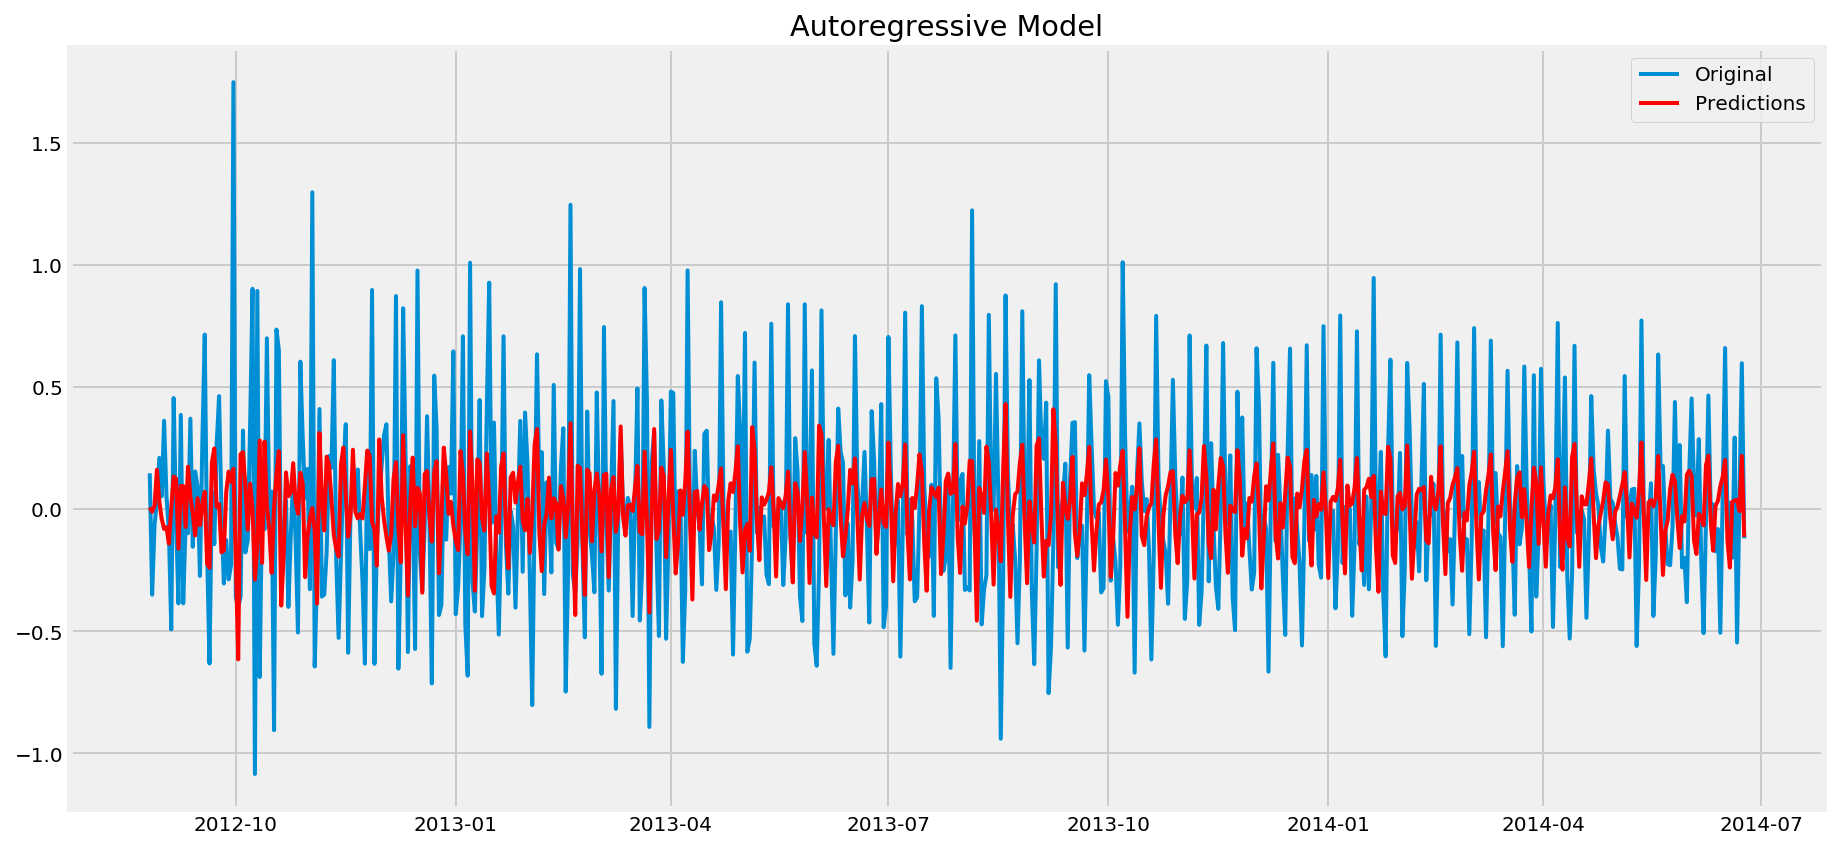

In [37]:
model = ARIMA(train_log_set, order=(2, 1, 0))
result_AR = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), lw=2, label='Original')
plt.plot(result_AR.fittedvalues, c='r', lw=2, label='Predictions')
plt.title('Autoregressive Model')
plt.legend()
plt.show()

### Validation Plot of AR Model

Timestamp
2014-06-25   353.67
2014-06-26   288.55
2014-06-27   317.09
2014-06-28   341.68
2014-06-29   328.48
              ...  
2014-09-21   593.38
2014-09-22   597.57
2014-09-23   601.79
2014-09-24   606.05
2014-09-25   610.33
Freq: D, Length: 93, dtype: float64


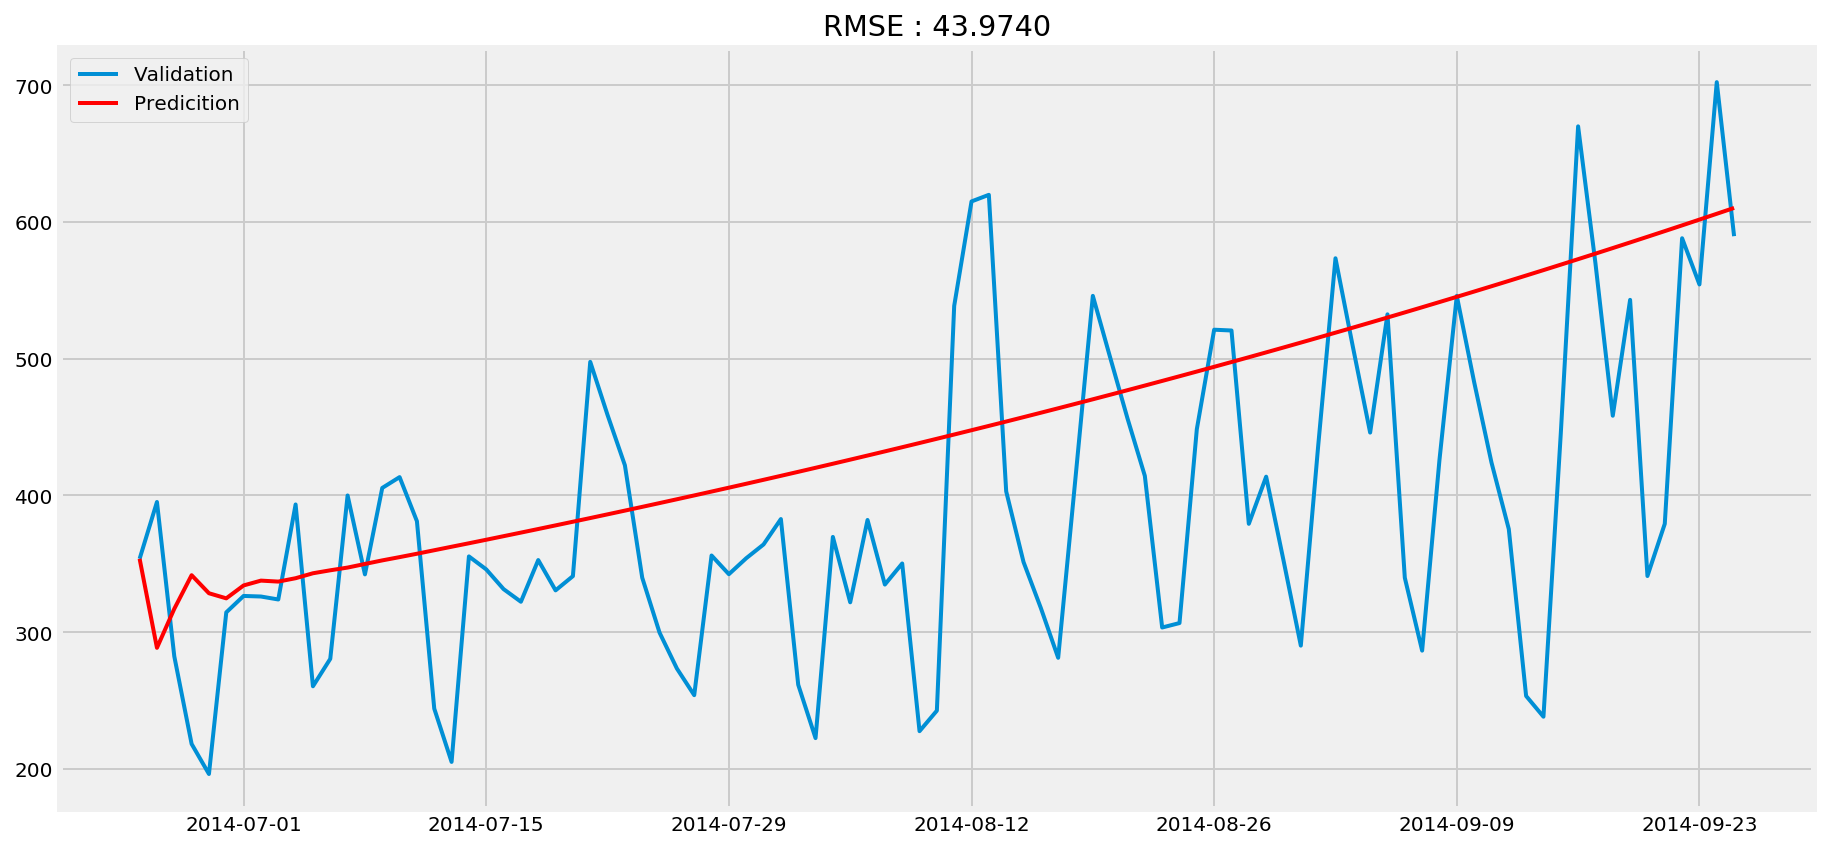

In [38]:
AR_predict = result_AR.predict(start='2014-06-25', end='2014-09-25')
# print(AR_predict)
AR_predict = AR_predict.cumsum().shift().fillna(0)
# print(AR_predict)
AR_predict1 = pd.Series(
    np.ones(validation_Set_dataframe.shape[0]) * np.log(
        validation_Set_dataframe['Count'])[0],
    index=validation_Set_dataframe.index)
# print(AR_predict1)
AR_predict1 = AR_predict1.add(AR_predict, fill_value=0)
# print(AR_predict1)
AR_predict = np.exp(AR_predict1)
print(AR_predict)

plt.figure(figsize=(14, 7))
plt.plot(validation_Set_dataframe['Count'], lw=2, label='Validation')
plt.plot(AR_predict, c='r', lw=2, label='Predicition')
plt.title('RMSE : {:.4f}'.format(
    (np.sqrt(np.dot(AR_predict, validation_Set_dataframe['Count'])) /
     validation_Set_dataframe.shape[0])))
plt.legend()
plt.show()

### MA Model

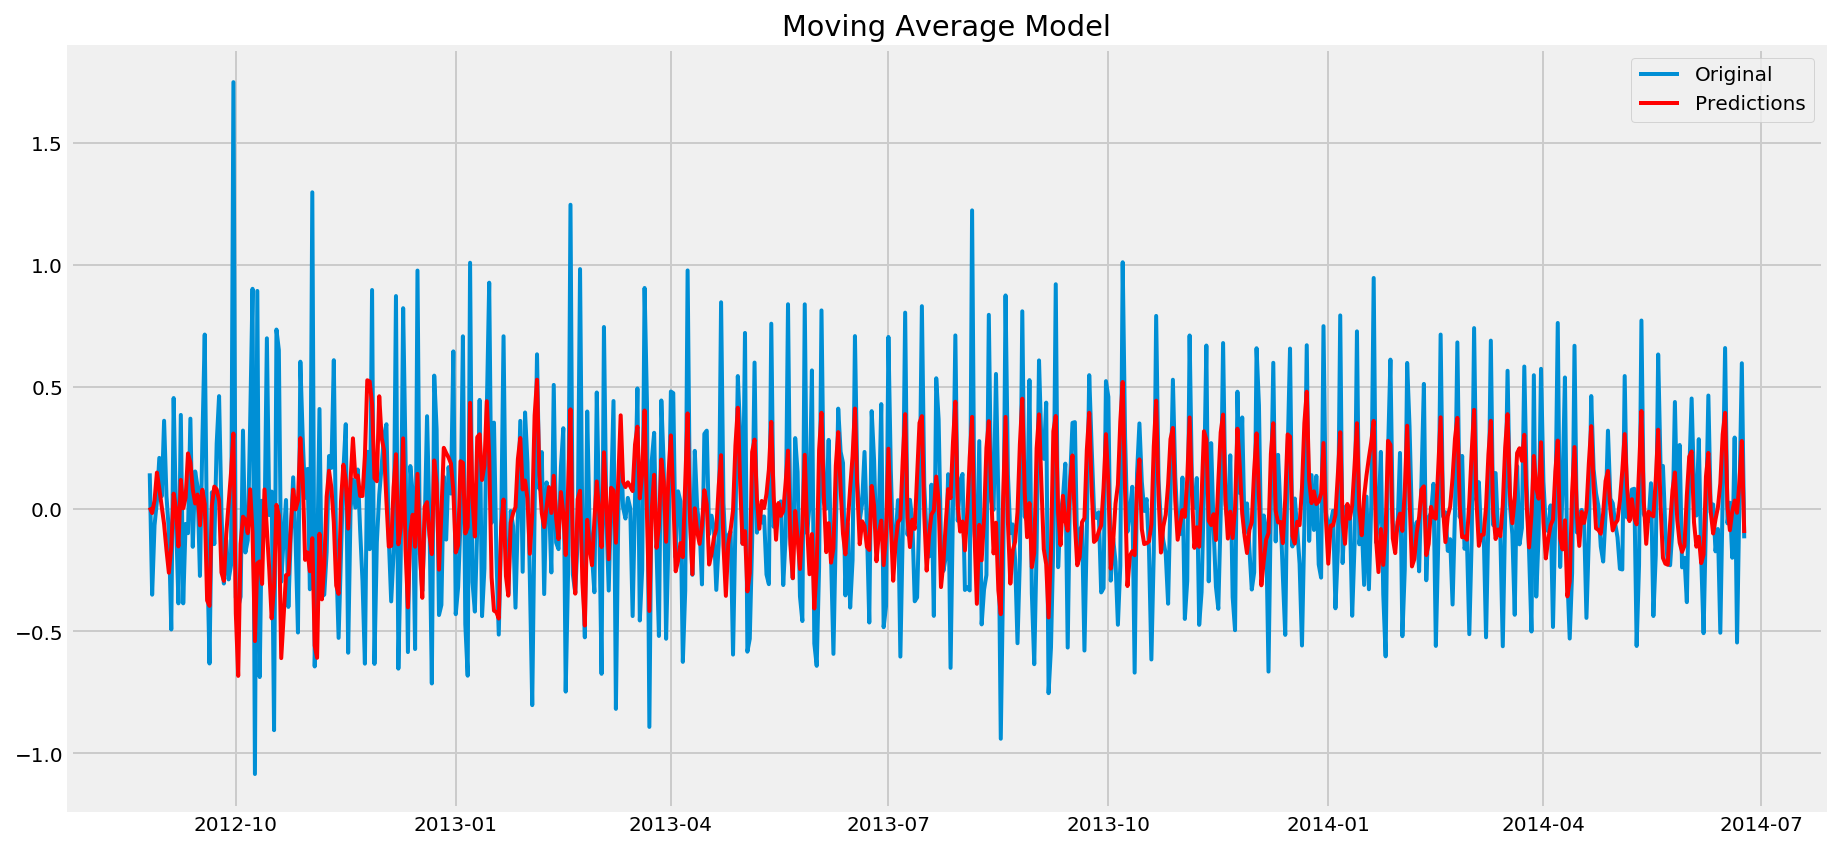

In [39]:
model = ARIMA(train_log_set, order=(0, 1, 2))
result_MA = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), lw=2, label='Original')
plt.plot(result_MA.fittedvalues, lw=2, c='r', label='Predictions')
plt.title('Moving Average Model')
plt.legend()
plt.show()

### Validation Plot of MA Model

Timestamp
2014-06-25   353.67
2014-06-26   310.45
2014-06-27   315.75
2014-06-28   317.94
2014-06-29   320.14
              ...  
2014-09-21   571.20
2014-09-22   575.15
2014-09-23   579.13
2014-09-24   583.13
2014-09-25   587.17
Freq: D, Length: 93, dtype: float64


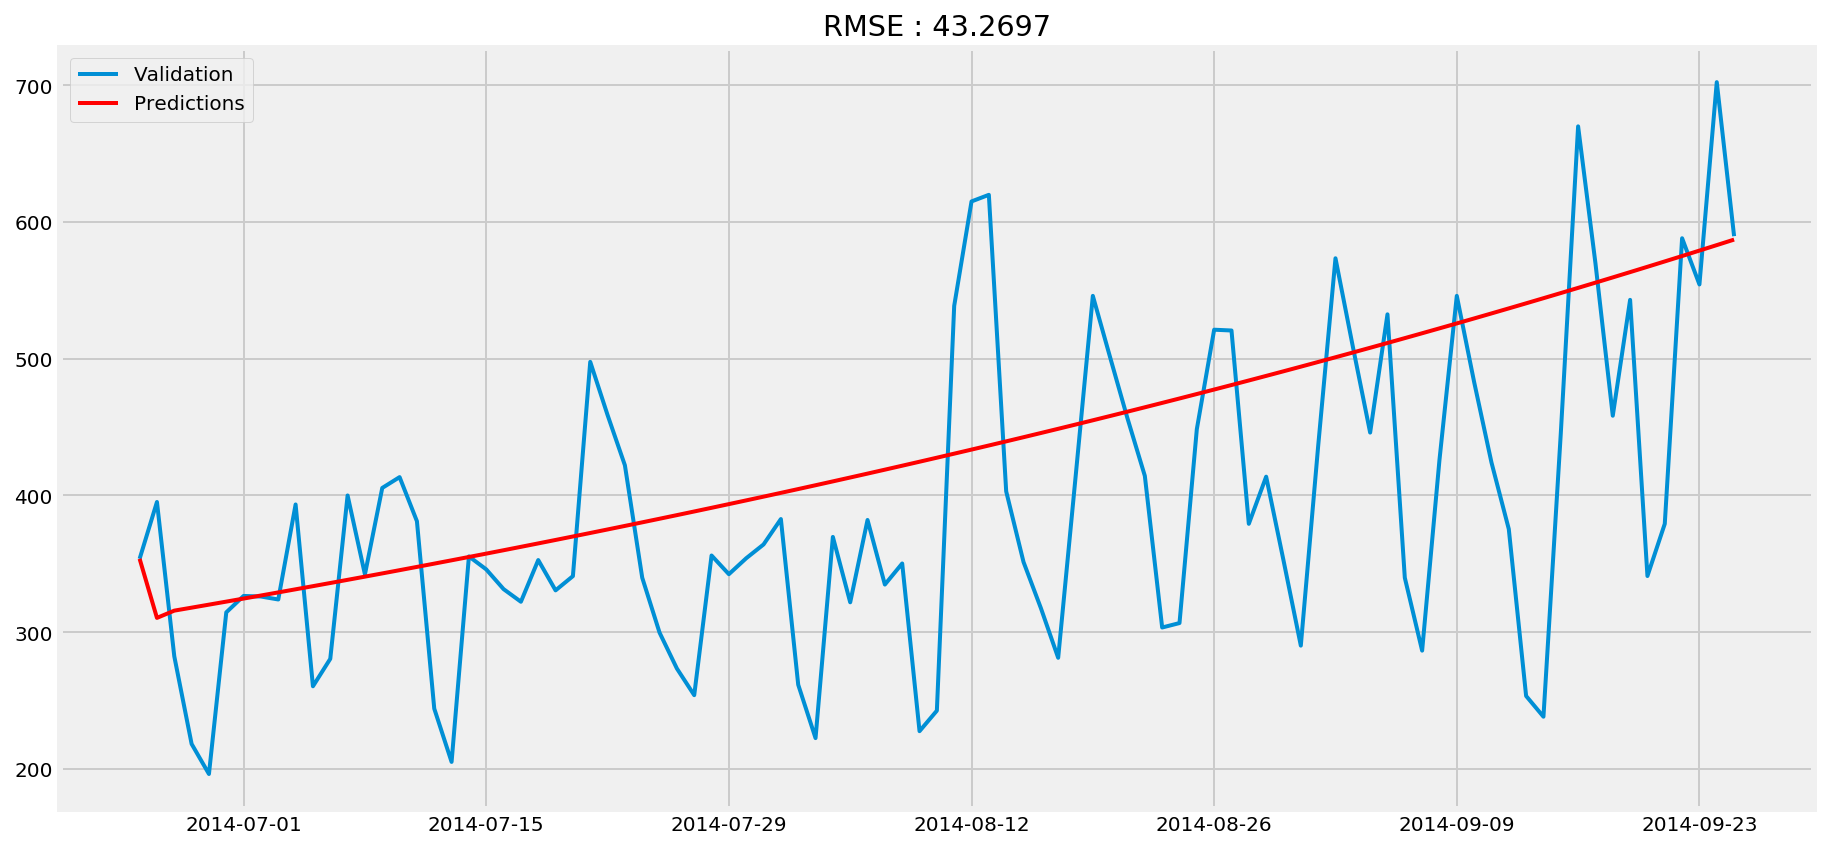

In [40]:
MA_predict = result_MA.predict(start='2014-06-25', end='2014-09-25')
# print(MA_predict)
MA_predict = MA_predict.cumsum().shift().fillna(0)
# print(MA_predict)
MA_predict1 = pd.Series(
    np.ones(validation_Set_dataframe.shape[0]) * np.log(
        validation_Set_dataframe['Count'])[0],
    index=validation_Set_dataframe.index)
# print(MA_predict1)
MA_predict1 = MA_predict1.add(MA_predict, fill_value=0)
# print(MA_predict1)
MA_predict = np.exp(MA_predict1)
print(MA_predict)

plt.plot(validation_Set_dataframe['Count'], lw=2, label='Validation')
plt.plot(MA_predict, c='r', lw=2, label='Predictions')
plt.title('RMSE : {:.4f}'.format(
    np.sqrt(np.dot(MA_predict, validation_Set_dataframe['Count'])) /
    validation_Set_dataframe.shape[0]))
plt.legend()
plt.show()

### Combined Model

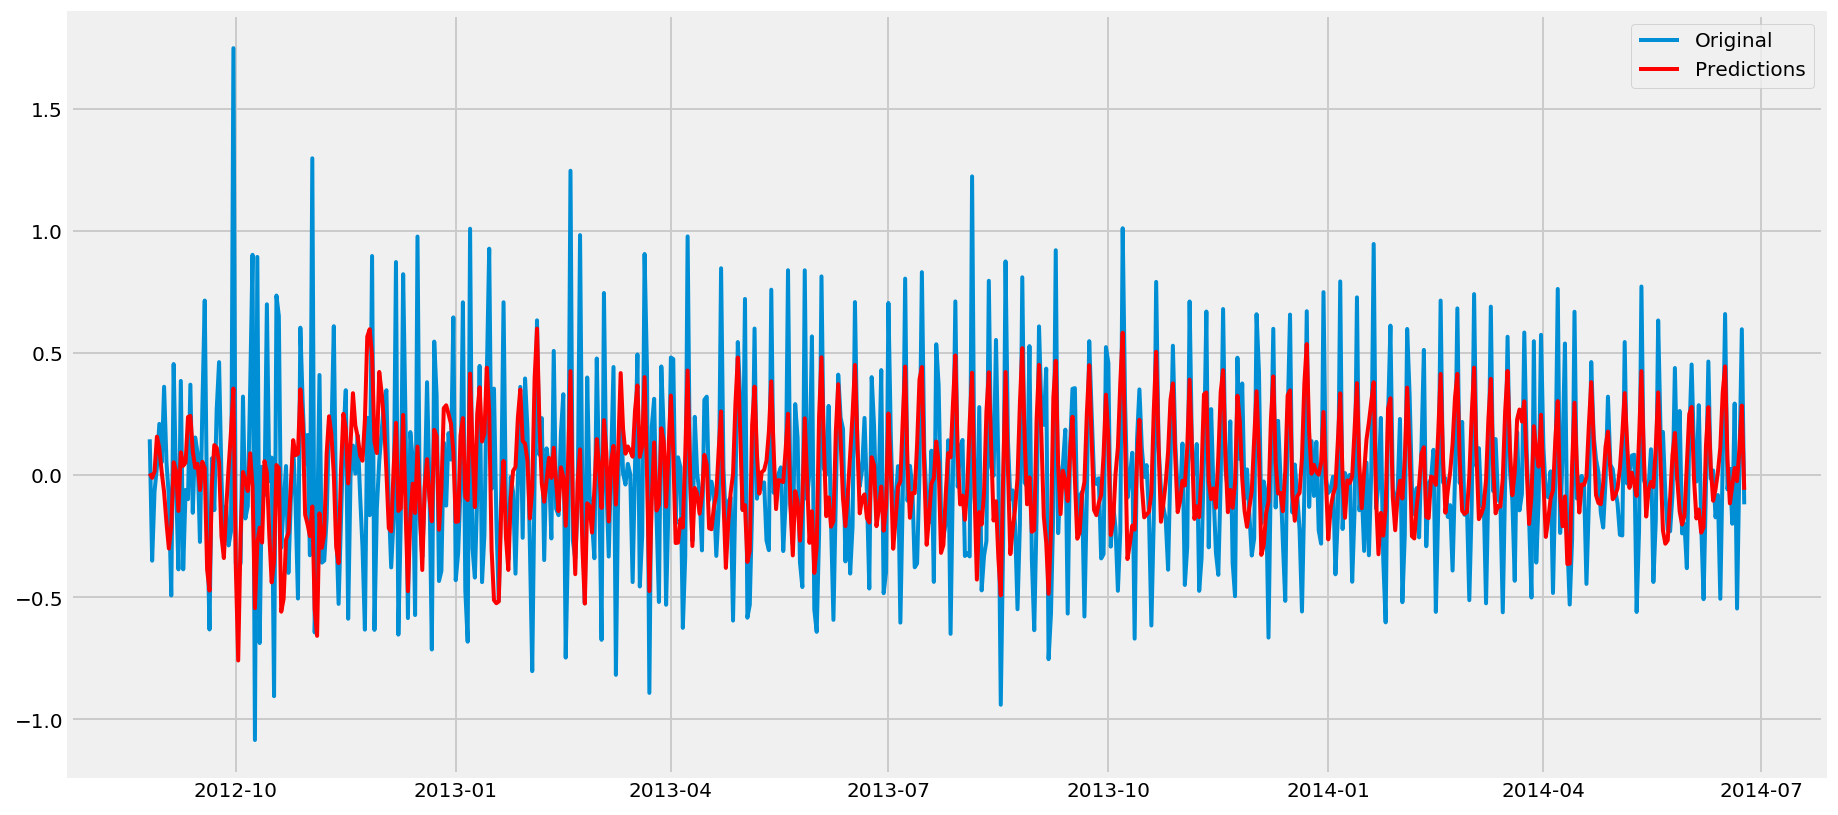

In [41]:
model = ARIMA(train_log_set, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(14, 7))
plt.plot(train_log_diff.dropna(), lw=2, label='Original')
plt.plot(results_ARIMA.fittedvalues, c='r', lw=2, label='Predictions')
plt.legend()
plt.show()

In [42]:
# Organisation of the ARIMA Model code
def check_predictions(predict_diff, given_set):
    """This function is just to organize the code of ARIMA Model."""
    predict_diff = predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(
        np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0],
        index=given_set.index)
    predict_log = predict_base.add(predict_diff, fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(given_set['Count'], lw=2, label='Given set')
    plt.plot(predict, c='r', lw=2, label='Predictions')
    plt.title('RMSE : {:.4f}'.format(
        np.sqrt(np.dot(predict, given_set['Count'])) / given_set.shape[0]))
    plt.legend()
    plt.show()

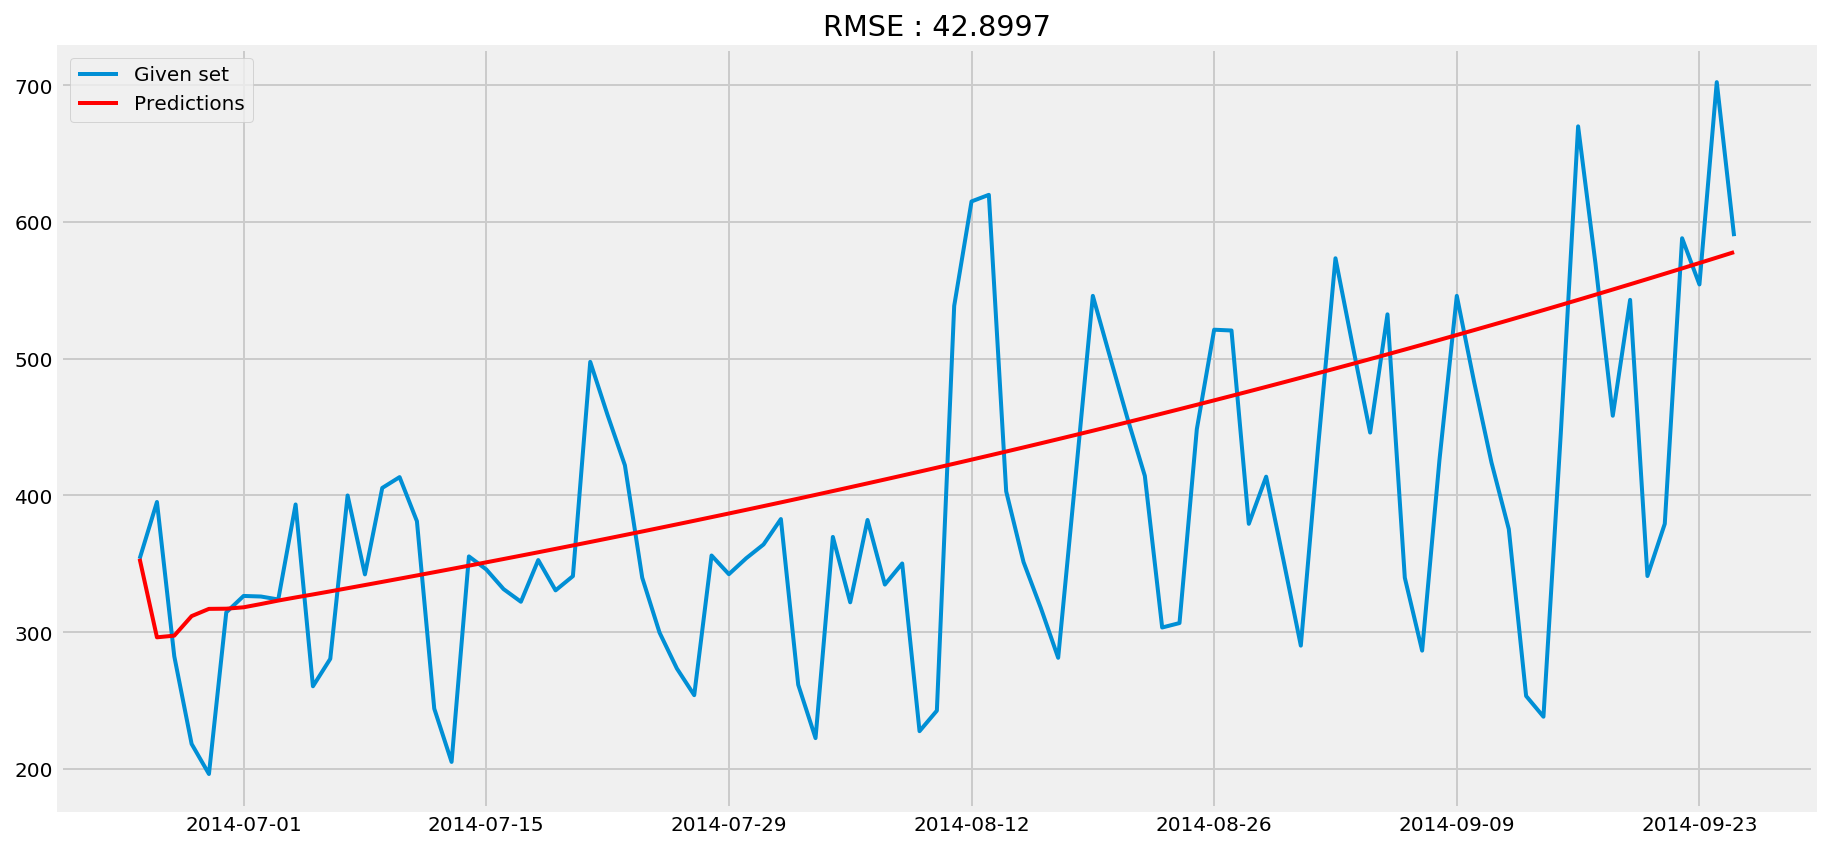

In [43]:
ARIMA_predict_diff = results_ARIMA.predict(
    start='2014-06-25', end='2014-09-25')
check_predictions(ARIMA_predict_diff, validation_Set_dataframe)

### SARIMAX (Seasonal ARIMA) Model on Daily Timeseries
SARIMAX model takes into account the seasonality of the time series.
* Order in the model represents the order of the autoregressive model(number of time lags), the degree of differencing(number of times the data have had past values subtracted) and the order of moving average model.
* Seasonal order represents the order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.
* Periodicity is 7 since it is daily time series and will repeat after every 7 days.

Count    year  month   day  Hour  day_of_week  weekend
Timestamp                                                         
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00

Count    year  month   day  Hour  day_of_week  weekend  sarima
Timestamp                                                                 
2014-06-25 353.67 2014.00   6.00 25.00 11.50         2.00     0.00  381.96
2014-06-26 395.25 2014.00   6.00 26.00 11.50         3.00     0.00  368.15
2014-06-27 282.33 2014.00   6.00 27.00 11.50         4.00     0.00  351.46
2014-06-28 218.25 2014.00   6.00 28.00 11.50         5.00     1.00  240.92
2014-06-29 196.25 2014.00   6.00 29.00 11.50         6.00     1.00  236.52

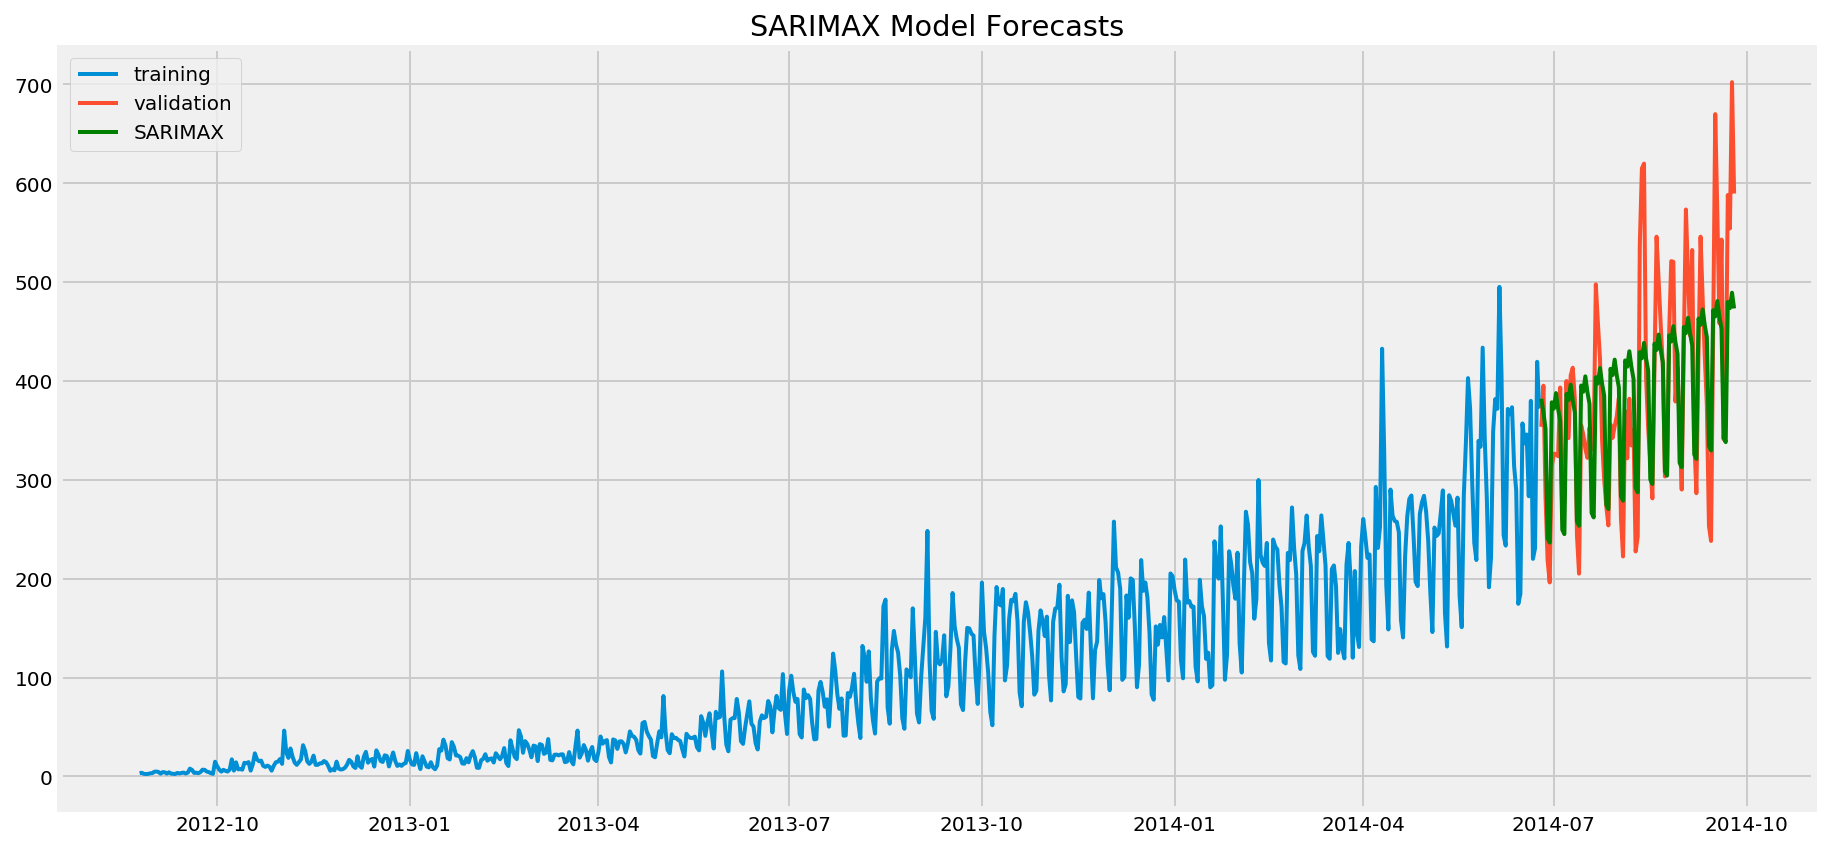

Root Mean Squared Error : 68.68862


In [44]:
y_hat_sarimax = validation_Set_dataframe.copy()
display.display(y_hat_sarimax.head())

fit_sarimax = sm.tsa.statespace.SARIMAX(
    train_dataframe.Count, order=(2, 1, 4), seasonal_order=(0, 1, 1, 7)).fit()

y_hat_sarimax['sarima'] = fit_sarimax.predict(
    start='2014-06-25', end='2014-09-25', dynamic=True)
display.display(y_hat_sarimax.head())

plt.figure(figsize=(14, 7))
plt.plot(
    train_set_dataframe.index,
    train_set_dataframe.Count,
    lw=2,
    label='training')
plt.plot(
    validation_Set_dataframe.index,
    validation_Set_dataframe.Count,
    lw=2,
    label='validation')
plt.plot(
    y_hat_sarimax.index, y_hat_sarimax.sarima, lw=2, c='g', label='SARIMAX')
plt.title('SARIMAX Model Forecasts')
plt.legend()
plt.show()

rmse_sarima = math.sqrt(
    metrics.mean_squared_error(validation_Set_dataframe.Count,
                               y_hat_sarimax.sarima))
print('Root Mean Squared Error : {:.5f}'.format(rmse_sarima))